In [1]:
#pip install -r requirements.txt

In [56]:
#18B4E9 Azul
#E36729 Gol
#ED1650 TAM

# Pacotes

In [3]:
import pandas as pd
import chardet
from functools import reduce
import os
import logging
import glob

# Pacote de geração de gráficos
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import missingno as msno #Pacote para ver dados missing


import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [4]:
pip freeze > requirements_analise_exploratoria.txt

Note: you may need to restart the kernel to use updated packages.


# Funções

In [5]:
def missing_values_table(df):
    """
    Cria uma tabela resumindo a quantidade e a porcentagem de valores ausentes em cada coluna do DataFrame.

    Args:
    df (pd.DataFrame): DataFrame para análise de valores ausentes.

    Etapas:
    1. Calcular a quantidade total de valores ausentes por coluna.
    2. Calcular a porcentagem de valores ausentes em relação ao total de linhas.
    3. Concatenar as duas métricas em um novo DataFrame.
    4. Renomear as colunas do DataFrame resultante para maior clareza.
    5. Filtrar e ordenar o DataFrame para mostrar apenas colunas com valores ausentes, em ordem decrescente de porcentagem.
    6. Imprimir um resumo sobre a presença de valores ausentes no DataFrame.

    Returns:
    pd.DataFrame: Uma tabela com o número e a porcentagem de valores ausentes por coluna.
    """
    # Calculando o número total de valores ausentes por coluna.
    mis_val = df.isnull().sum()
    
    # Calculando a porcentagem de valores ausentes.
    mis_val_percent = 100 * mis_val / len(df)
    
    # Criando um DataFrame com o número e a porcentagem de valores ausentes.
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renomeando as colunas do DataFrame para clareza.
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Filtrando o DataFrame para mostrar apenas colunas com valores ausentes e ordenando-as.
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # Imprimindo um resumo das colunas com valores ausentes.
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    
    return mis_val_table_ren_columns

def change_width_x(ax, new_value):
    """
    Ajusta a largura das barras em um gráfico de barras horizontal no Matplotlib.

    Args:
    ax (matplotlib.axes._subplots.AxesSubplot): Objeto Axes do Matplotlib.
    new_value (float): Nova largura das barras.

    Etapas:
    1. Iterar sobre cada barra no gráfico.
    2. Ajustar a largura da barra para o novo valor.
    3. Centralizar a barra horizontalmente após o ajuste.

    Returns:
    None: A função modifica o gráfico diretamente, sem retornar um valor.
    """
    # Iterando sobre cada barra no gráfico para ajustar a largura.
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # Ajustando a largura e reposicionando a barra.
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * 0.5)

def change_width_y(ax, new_value):
    """
    Ajusta a altura das barras em um gráfico de barras vertical no Matplotlib.

    Args:
    ax (matplotlib.axes._subplots.AxesSubplot): Objeto Axes do Matplotlib.
    new_value (float): Nova altura das barras.

    Etapas:
    1. Iterar sobre cada barra no gráfico.
    2. Ajustar a altura da barra para o novo valor.
    3. Centralizar a barra verticalmente após o ajuste.

    Returns:
    None: A função modifica o gráfico diretamente, sem retornar um valor.
    """
    # Iterando sobre cada barra no gráfico para ajustar a altura.
    for patch in ax.patches:
        current_height = patch.get_height()
        diff = current_height - new_value
        
        # Ajustando a altura e reposicionando a barra.
        patch.set_height(new_value)
        patch.set_y(patch.get_y() + diff * 0.5)

def add_annotations_percentage_y(ax, df_length, size=10, rotation= 0):
    """
    Adiciona anotações de porcentagem a um gráfico de barras horizontal no Matplotlib.

    Args:
    ax (matplotlib.axes._subplots.AxesSubplot): Objeto Axes do Matplotlib.
    df_length (int): Comprimento do DataFrame ou valor total para cálculo de porcentagens.
    size (int): Tamanho da fonte das anotações.

    Etapas:
    1. Verificar se 'df_length' é zero para evitar divisão por zero.
    2. Iterar sobre cada barra no gráfico.
    3. Calcular a porcentagem e adicionar a anotação à direita da barra.

    Returns:
    None: A função modifica o gráfico diretamente, sem retornar um valor.
    """
    # Verificando se o comprimento do DataFrame é zero para evitar divisão por zero.
    if df_length == 0:
        return
    
    # Iterando sobre cada barra para adicionar anotações de porcentagem.
    for bar in ax.patches:
        width = bar.get_width()
        percentage = '{:.1f}%'.format(100 * width / df_length)
        
        # Adicionando a anotação de porcentagem à barra.
        ax.annotate(percentage,
                    (width, bar.get_y() + bar.get_height() / 2), 
                    ha='left', va='center', rotation=rotation,
                    size=size, xytext=(5, 0),
                    textcoords='offset points')
        

def add_annotations_percentage_x(ax, df_length, size=10, rotation= 0):
    """
    Adiciona anotações de porcentagem acima das barras em um gráfico de barras vertical no Matplotlib.

    Parâmetros:
    ax (matplotlib.axes._subplots.AxesSubplot): Objeto Axes do Matplotlib.
    df_length (int): Comprimento do DataFrame ou valor total para cálculo de porcentagens.
    size (int): Tamanho da fonte das anotações.

    Retorna:
    None: A função modifica o gráfico diretamente, sem retornar um valor.
    """
    
    # Verificando se o comprimento do DataFrame é zero para evitar divisão por zero.
    if df_length == 0:
        return  # Saindo da função se df_length é zero.

    # Iterando sobre cada barra no gráfico.
    for bar in ax.patches:
        # Calculando a porcentagem da altura da barra em relação ao comprimento total do DataFrame.
        height = bar.get_height()
        percentage = '{:.1f}%'.format(100 * height / df_length) if df_length else '0%'

        # Adicionando a anotação de porcentagem acima da barra.
        # A anotação é centralizada horizontalmente na barra e posicionada logo acima dela.
        ax.annotate(percentage,
                    (bar.get_x() + bar.get_width() / 2, height), 
                    ha='center', va='bottom',  rotation=rotation,
                    size=size, xytext=(0, 3),
                    textcoords='offset points')

# Carregando Dados

In [6]:
# Carregamento de dados históricos de voos a partir de um arquivo CSV.

# Definindo o caminho do arquivo CSV que contém os dados históricos de voos.
file_path = 'dados_tratados/historico_voo_tratados.csv'

# Lendo o arquivo CSV e carregando os dados em um DataFrame do pandas.
df = pd.read_csv(file_path)

# Informações básicas do dataframe

In [7]:
df.head(5)

nome_empresas numero_voo  codigo_di codigo_tipo_linha     partida_prevista  \
0           TAM       8077        NaN                 I  2018-01-07 05:20:00   
1           TAM       8077        NaN                 I  2018-01-14 05:20:00   
2           TAM       8077        NaN                 I  2018-01-21 05:20:00   
3           TAM       8077        NaN                 I  2018-01-28 05:20:00   
4           TAM       8077        NaN                 I  2018-02-04 05:20:00   

          partida_real     chegada_prevista         chegada_real situacao_voo  \
0  2018-01-07 05:20:00  2018-01-07 10:45:00  2018-01-07 10:45:00    REALIZADO   
1  2018-01-14 05:20:00  2018-01-14 10:45:00  2018-01-14 10:45:00    REALIZADO   
2  2018-01-21 05:20:00  2018-01-21 10:45:00  2018-01-21 10:45:00    REALIZADO   
3  2018-01-28 05:20:00  2018-01-28 10:45:00  2018-01-28 10:45:00    REALIZADO   
4  2018-02-04 05:20:00  2018-02-04 10:45:00  2018-02-04 10:23:00    REALIZADO   

              descricao_origem                pais_origem continente_origem  \
0  MIAMI INTERNATIONAL AIRPORT  ESTADOS UNIDOS DA AMERICA  AMERICA DO NORTE   
1  MIAMI INTERNATIONAL AIRPORT  ESTADOS UNIDOS DA AMERICA  AMERICA DO NORTE   
2  MIAMI INTERNATIONAL AIRPORT  ESTADOS UNIDOS DA AMERICA  AMERICA DO NORTE   
3  MIAMI INTERNATIONAL AIRPORT  ESTADOS UNIDOS DA AMERICA  AMERICA DO NORTE   
4  MIAMI INTERNATIONAL AIRPORT  ESTADOS UNIDOS DA AMERICA  AMERICA DO NORTE   

  descricao_destino pais_destino continente_destino status_do_voo  \
0     EDUARDO GOMES       BRASIL     AMERICA DO SUL       Pontual   
1     EDUARDO GOMES       BRASIL     AMERICA DO SUL       Pontual   
2     EDUARDO GOMES       BRASIL     AMERICA DO SUL       Pontual   
3     EDUARDO GOMES       BRASIL     AMERICA DO SUL       Pontual   
4     EDUARDO GOMES       BRASIL     AMERICA DO SUL       Pontual   

  delta_tempo_partida_delta delta_tempo_chegada_delta  \
0           0 days 00:00:00           0 days 00:00:00   
1           0 days 00:00:00           0 days 00:00:00   
2           0 days 00:00:00           0 days 00:00:00   
3           0 days 00:00:00           0 days 00:00:00   
4           0 days 00:00:00           0 days 00:22:00   

   delta_tempo_partida_int  delta_tempo_chegada_int cidade_origem uf_origem  \
0                        0                        0         MIAMI       NaN   
1                        0                        0         MIAMI       NaN   
2                        0                        0         MIAMI       NaN   
3                        0                        0         MIAMI       NaN   
4                        0                       22         MIAMI       NaN   

  cidade_destino uf_destino  mes_partida  dia_semana_partida  dia_mes_partida  \
0         MANAUS         AM          1.0                 6.0              7.0   
1         MANAUS         AM          1.0                 6.0             14.0   
2         MANAUS         AM          1.0                 6.0             21.0   
3         MANAUS         AM          1.0                 6.0             28.0   
4         MANAUS         AM          2.0                 6.0              4.0   

   mes_chegada  dia_semana_chegada  dia_mes_chegada  \
0          1.0                 6.0              7.0   
1          1.0                 6.0             14.0   
2          1.0                 6.0             21.0   
3          1.0                 6.0             28.0   
4          2.0                 6.0              4.0   

                                           rota  
0  MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES  
1  MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES  
2  MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES  
3  MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES  
4  MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES

In [8]:
# Calculando o número de valores únicos em cada coluna do DataFrame.
# Isso ajuda a entender a diversidade dos dados em cada coluna.
df.nunique()

nome_empresas                     3
numero_voo                     5816
codigo_di                         9
codigo_tipo_linha                 8
partida_prevista             129117
partida_real                 349030
chegada_prevista             130781
chegada_real                 359260
situacao_voo                      2
descricao_origem                159
pais_origem                      29
continente_origem                 6
descricao_destino               164
pais_destino                     30
continente_destino                6
status_do_voo                     2
delta_tempo_partida_delta       648
delta_tempo_chegada_delta       658
delta_tempo_partida_int         647
delta_tempo_chegada_int         657
cidade_origem                   158
uf_origem                        27
cidade_destino                  163
uf_destino                       28
mes_partida                      12
dia_semana_partida                7
dia_mes_partida                  31
mes_chegada                 

In [9]:
# Exibindo informações gerais sobre o DataFrame, incluindo o número de linhas, colunas, tipos de dados e uso de memória.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779068 entries, 0 to 779067
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   nome_empresas              779068 non-null  object 
 1   numero_voo                 779068 non-null  object 
 2   codigo_di                  191716 non-null  float64
 3   codigo_tipo_linha          779068 non-null  object 
 4   partida_prevista           769159 non-null  object 
 5   partida_real               747131 non-null  object 
 6   chegada_prevista           769159 non-null  object 
 7   chegada_real               747131 non-null  object 
 8   situacao_voo               779068 non-null  object 
 9   descricao_origem           779068 non-null  object 
 10  pais_origem                779068 non-null  object 
 11  continente_origem          779068 non-null  object 
 12  descricao_destino          779068 non-null  object 
 13  pais_destino               77

# Describe

In [10]:
# Gerando um resumo estatístico das colunas numéricas do DataFrame.
# Inclui medidas como média, desvio padrão, valores mínimo/máximo e quartis.
df.describe()

codigo_di  delta_tempo_partida_int  delta_tempo_chegada_int  \
count  191716.000000            779068.000000            779068.000000   
mean        0.127287                11.473853                13.692947   
std         0.868757               232.266694               232.122776   
min         0.000000                 0.000000                 0.000000   
25%         0.000000                 0.000000                 0.000000   
50%         0.000000                 4.000000                 7.000000   
75%         0.000000                10.000000                15.000000   
max         9.000000             89294.000000             89292.000000   

         mes_partida  dia_semana_partida  dia_mes_partida    mes_chegada  \
count  769159.000000       769159.000000    769159.000000  769159.000000   
mean        6.459246            2.872368        15.677990       6.459246   
std         3.490906            1.978830         8.764077       3.490906   
min         1.000000            0.000000         1.000000       1.000000   
25%         3.000000            1.000000         8.000000       3.000000   
50%         7.000000            3.000000        16.000000       7.000000   
75%         9.000000            4.000000        23.000000       9.000000   
max        12.000000            6.000000        31.000000      12.000000   

       dia_semana_chegada  dia_mes_chegada  
count       769159.000000    769159.000000  
mean             2.872368        15.677990  
std              1.978830         8.764077  
min              0.000000         1.000000  
25%              1.000000         8.000000  
50%              3.000000        16.000000  
75%              4.000000        23.000000  
max              6.000000        31.000000

# Missing 

In [11]:
# Chamando a função 'missing_values_table' para obter um resumo dos valores ausentes no DataFrame.
# Esta função fornece o número e a porcentagem de valores ausentes por coluna.
missing_values_table(df)

Your selected dataframe has 31 columns.
There are 13 columns that have missing values.


Missing Values  % of Total Values
codigo_di                   587352               75.4
partida_real                 31937                4.1
chegada_real                 31937                4.1
uf_origem                    26590                3.4
uf_destino                   26527                3.4
partida_prevista              9909                1.3
chegada_prevista              9909                1.3
mes_partida                   9909                1.3
dia_semana_partida            9909                1.3
dia_mes_partida               9909                1.3
mes_chegada                   9909                1.3
dia_semana_chegada            9909                1.3
dia_mes_chegada               9909                1.3

<Axes: >

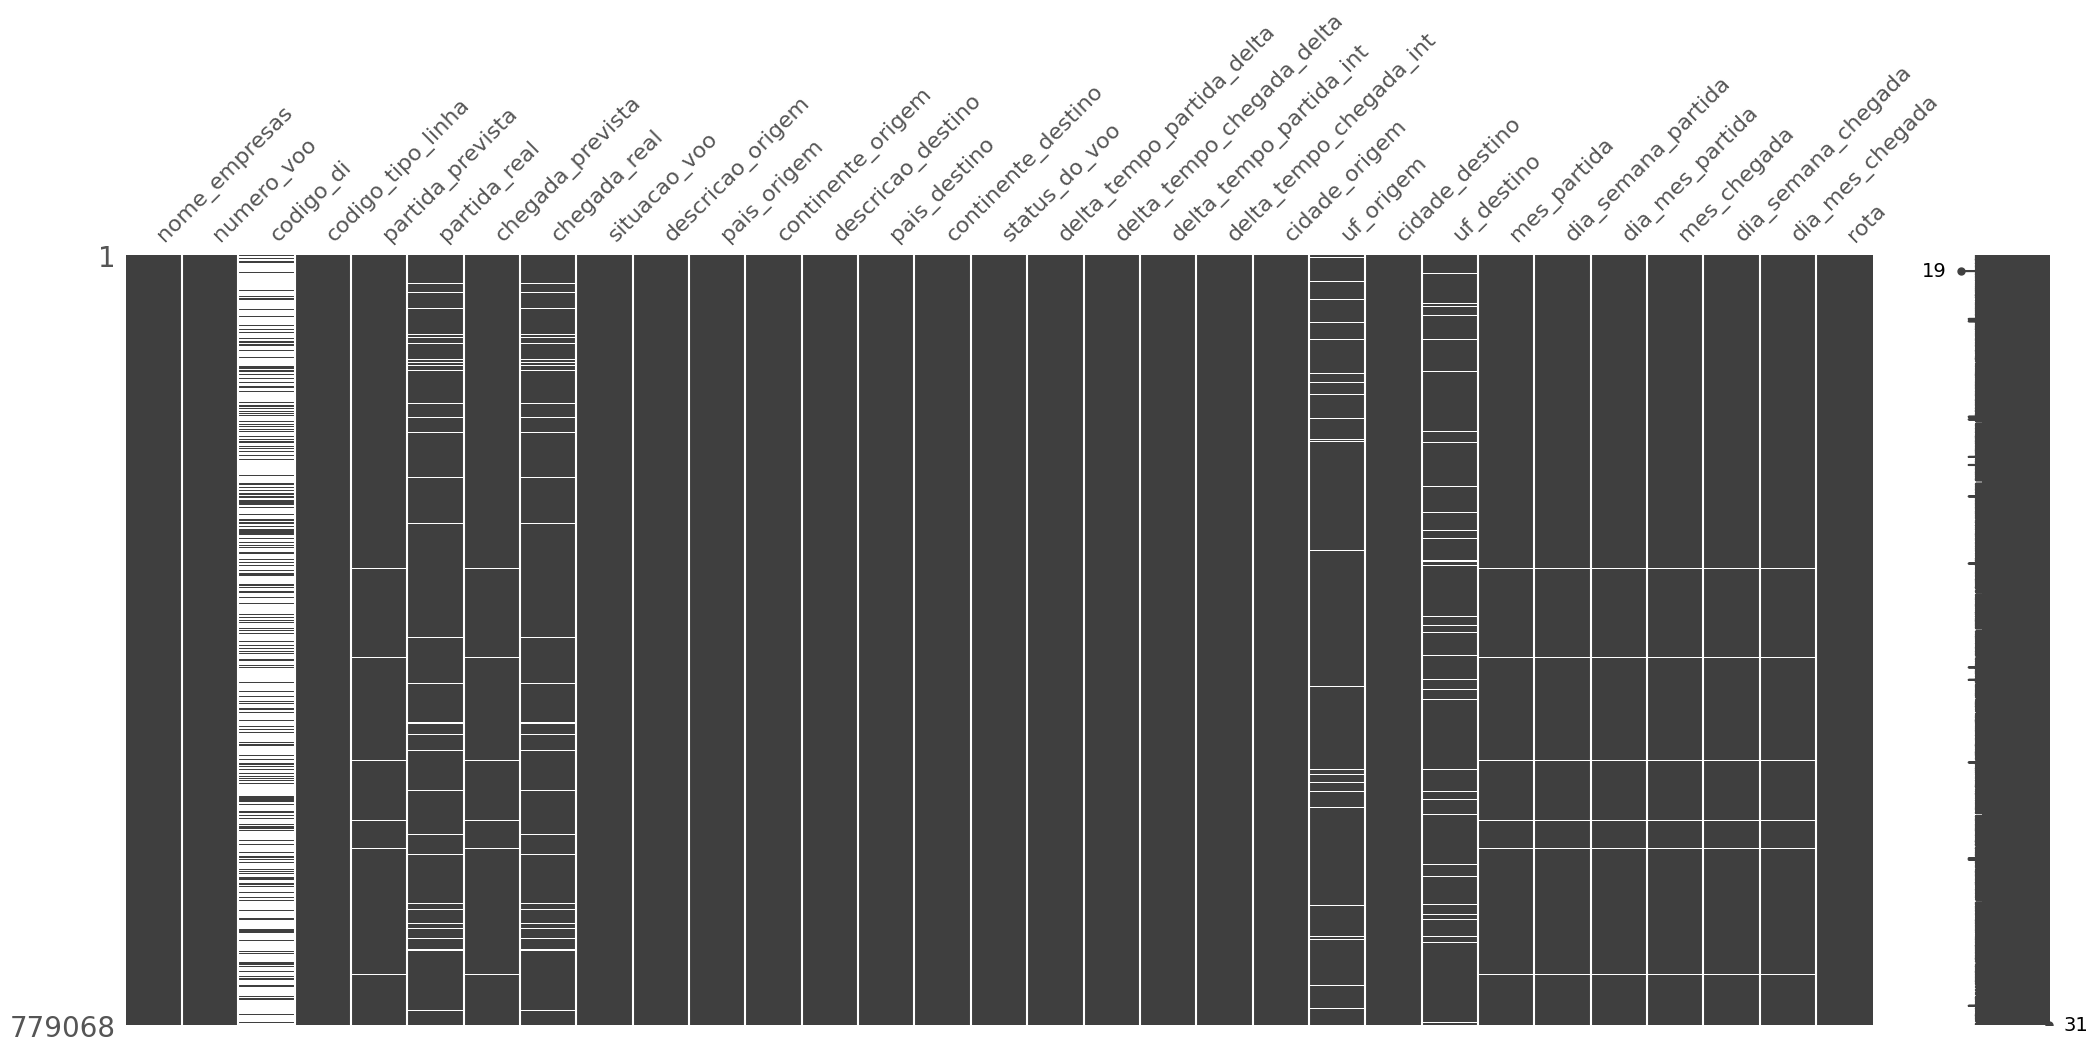

In [12]:
# Visualizando os valores ausentes no DataFrame com a biblioteca 'missingno'.
# O gráfico de matriz mostra a presença ou ausência de dados (valores não nulos) em cada coluna.
msno.matrix(df.sample([df.shape][0][0]))

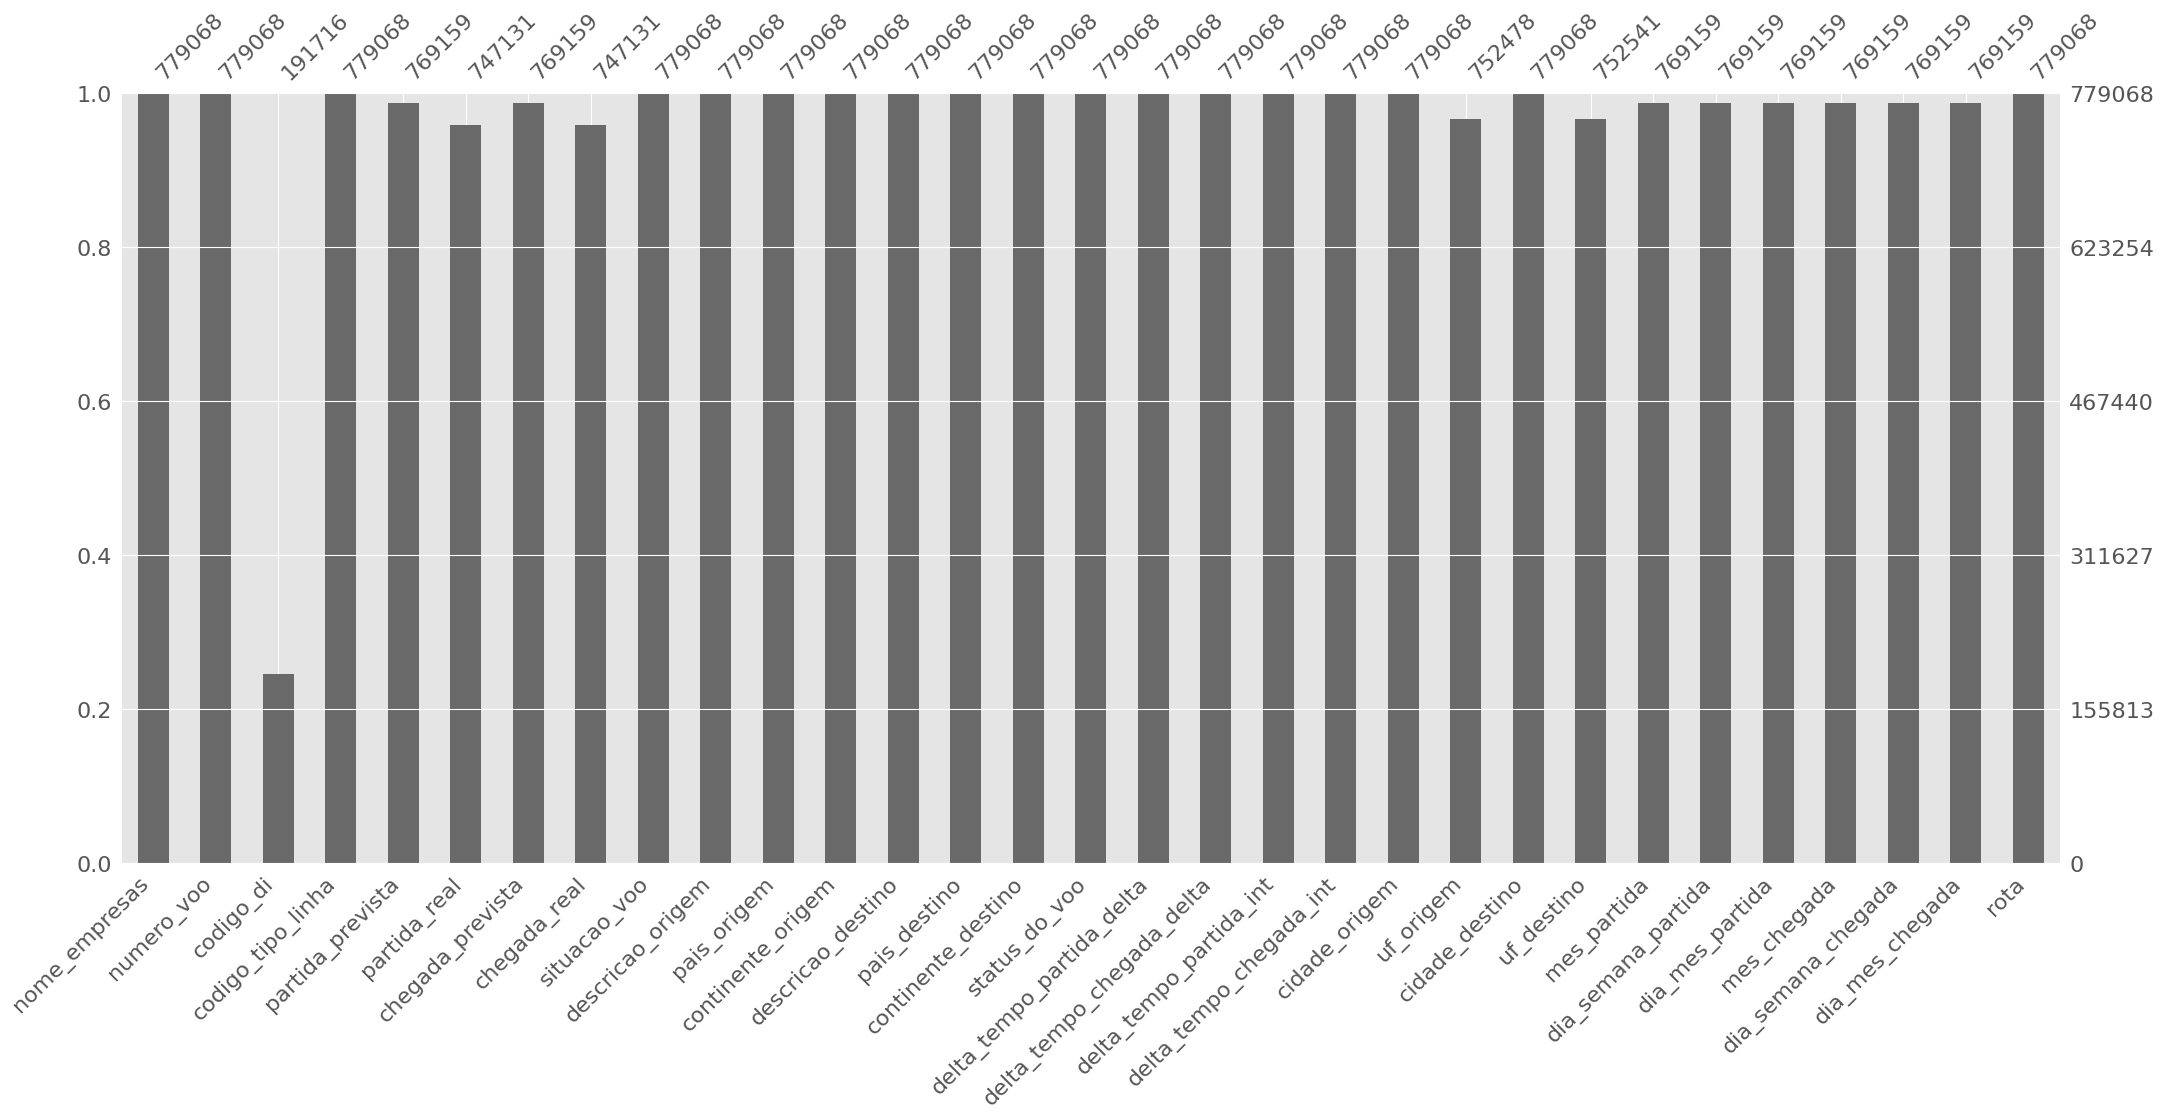

In [13]:
# Utilizando a biblioteca 'missingno' para gerar um gráfico de barras dos dados ausentes.
# Cada barra representa uma coluna do DataFrame e sua respectiva contagem de valores não nulos.
msno.bar(df)
plt.show()

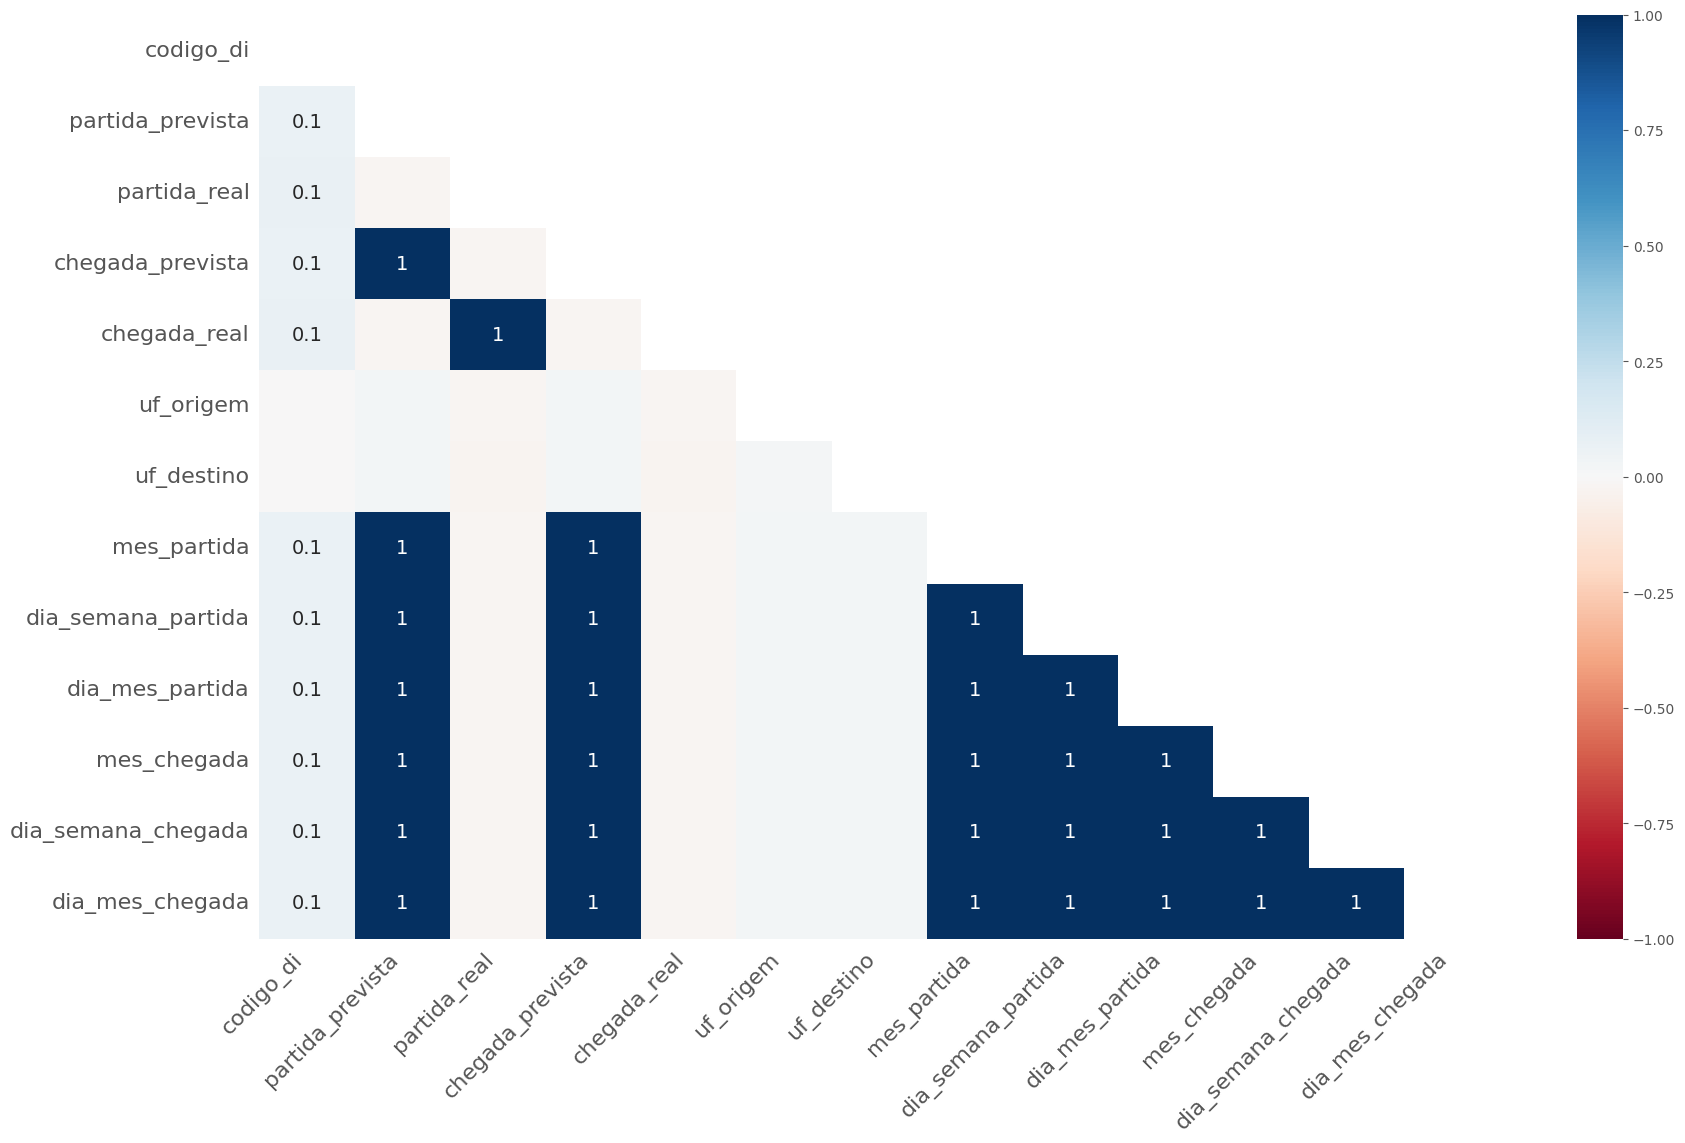

In [14]:
# Gerando um mapa de calor usando 'missingno' para visualizar as correlações de dados ausentes entre colunas.
# Valores próximos a 1 ou -1 indicam uma forte correlação positiva ou negativa, respectivamente.
msno.heatmap(df)
plt.show()

# Correlação

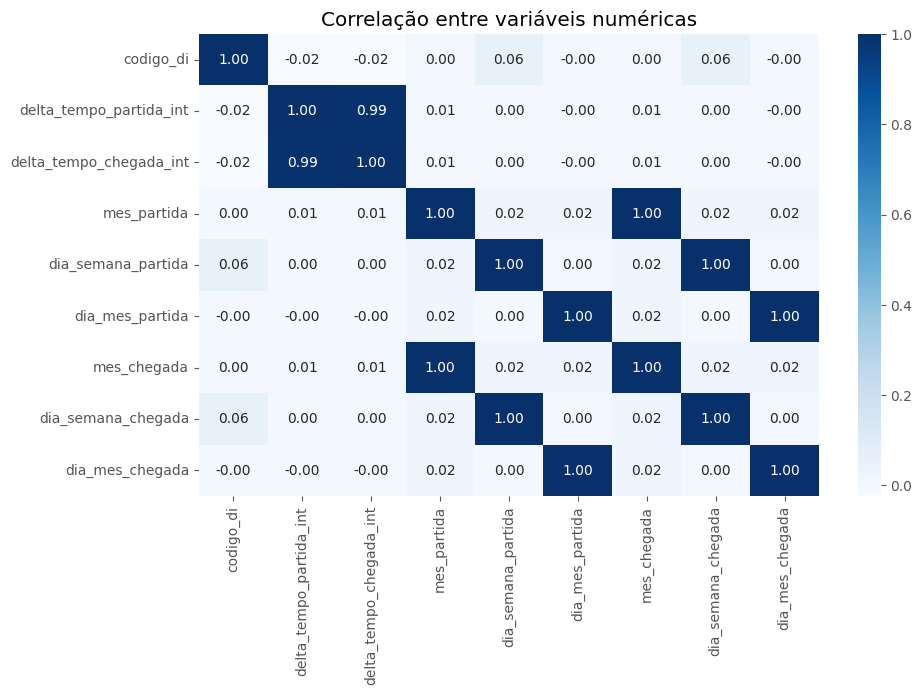

In [15]:
# Selecionar apenas colunas numéricas para a correlação
colunas_numericas = df.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação apenas com as colunas numéricas
corr = colunas_numericas.corr()

# Criar um heatmap com a matriz de correlação
plt.rcParams['figure.figsize'] = [10, 6]
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlação entre variáveis numéricas')
plt.show()

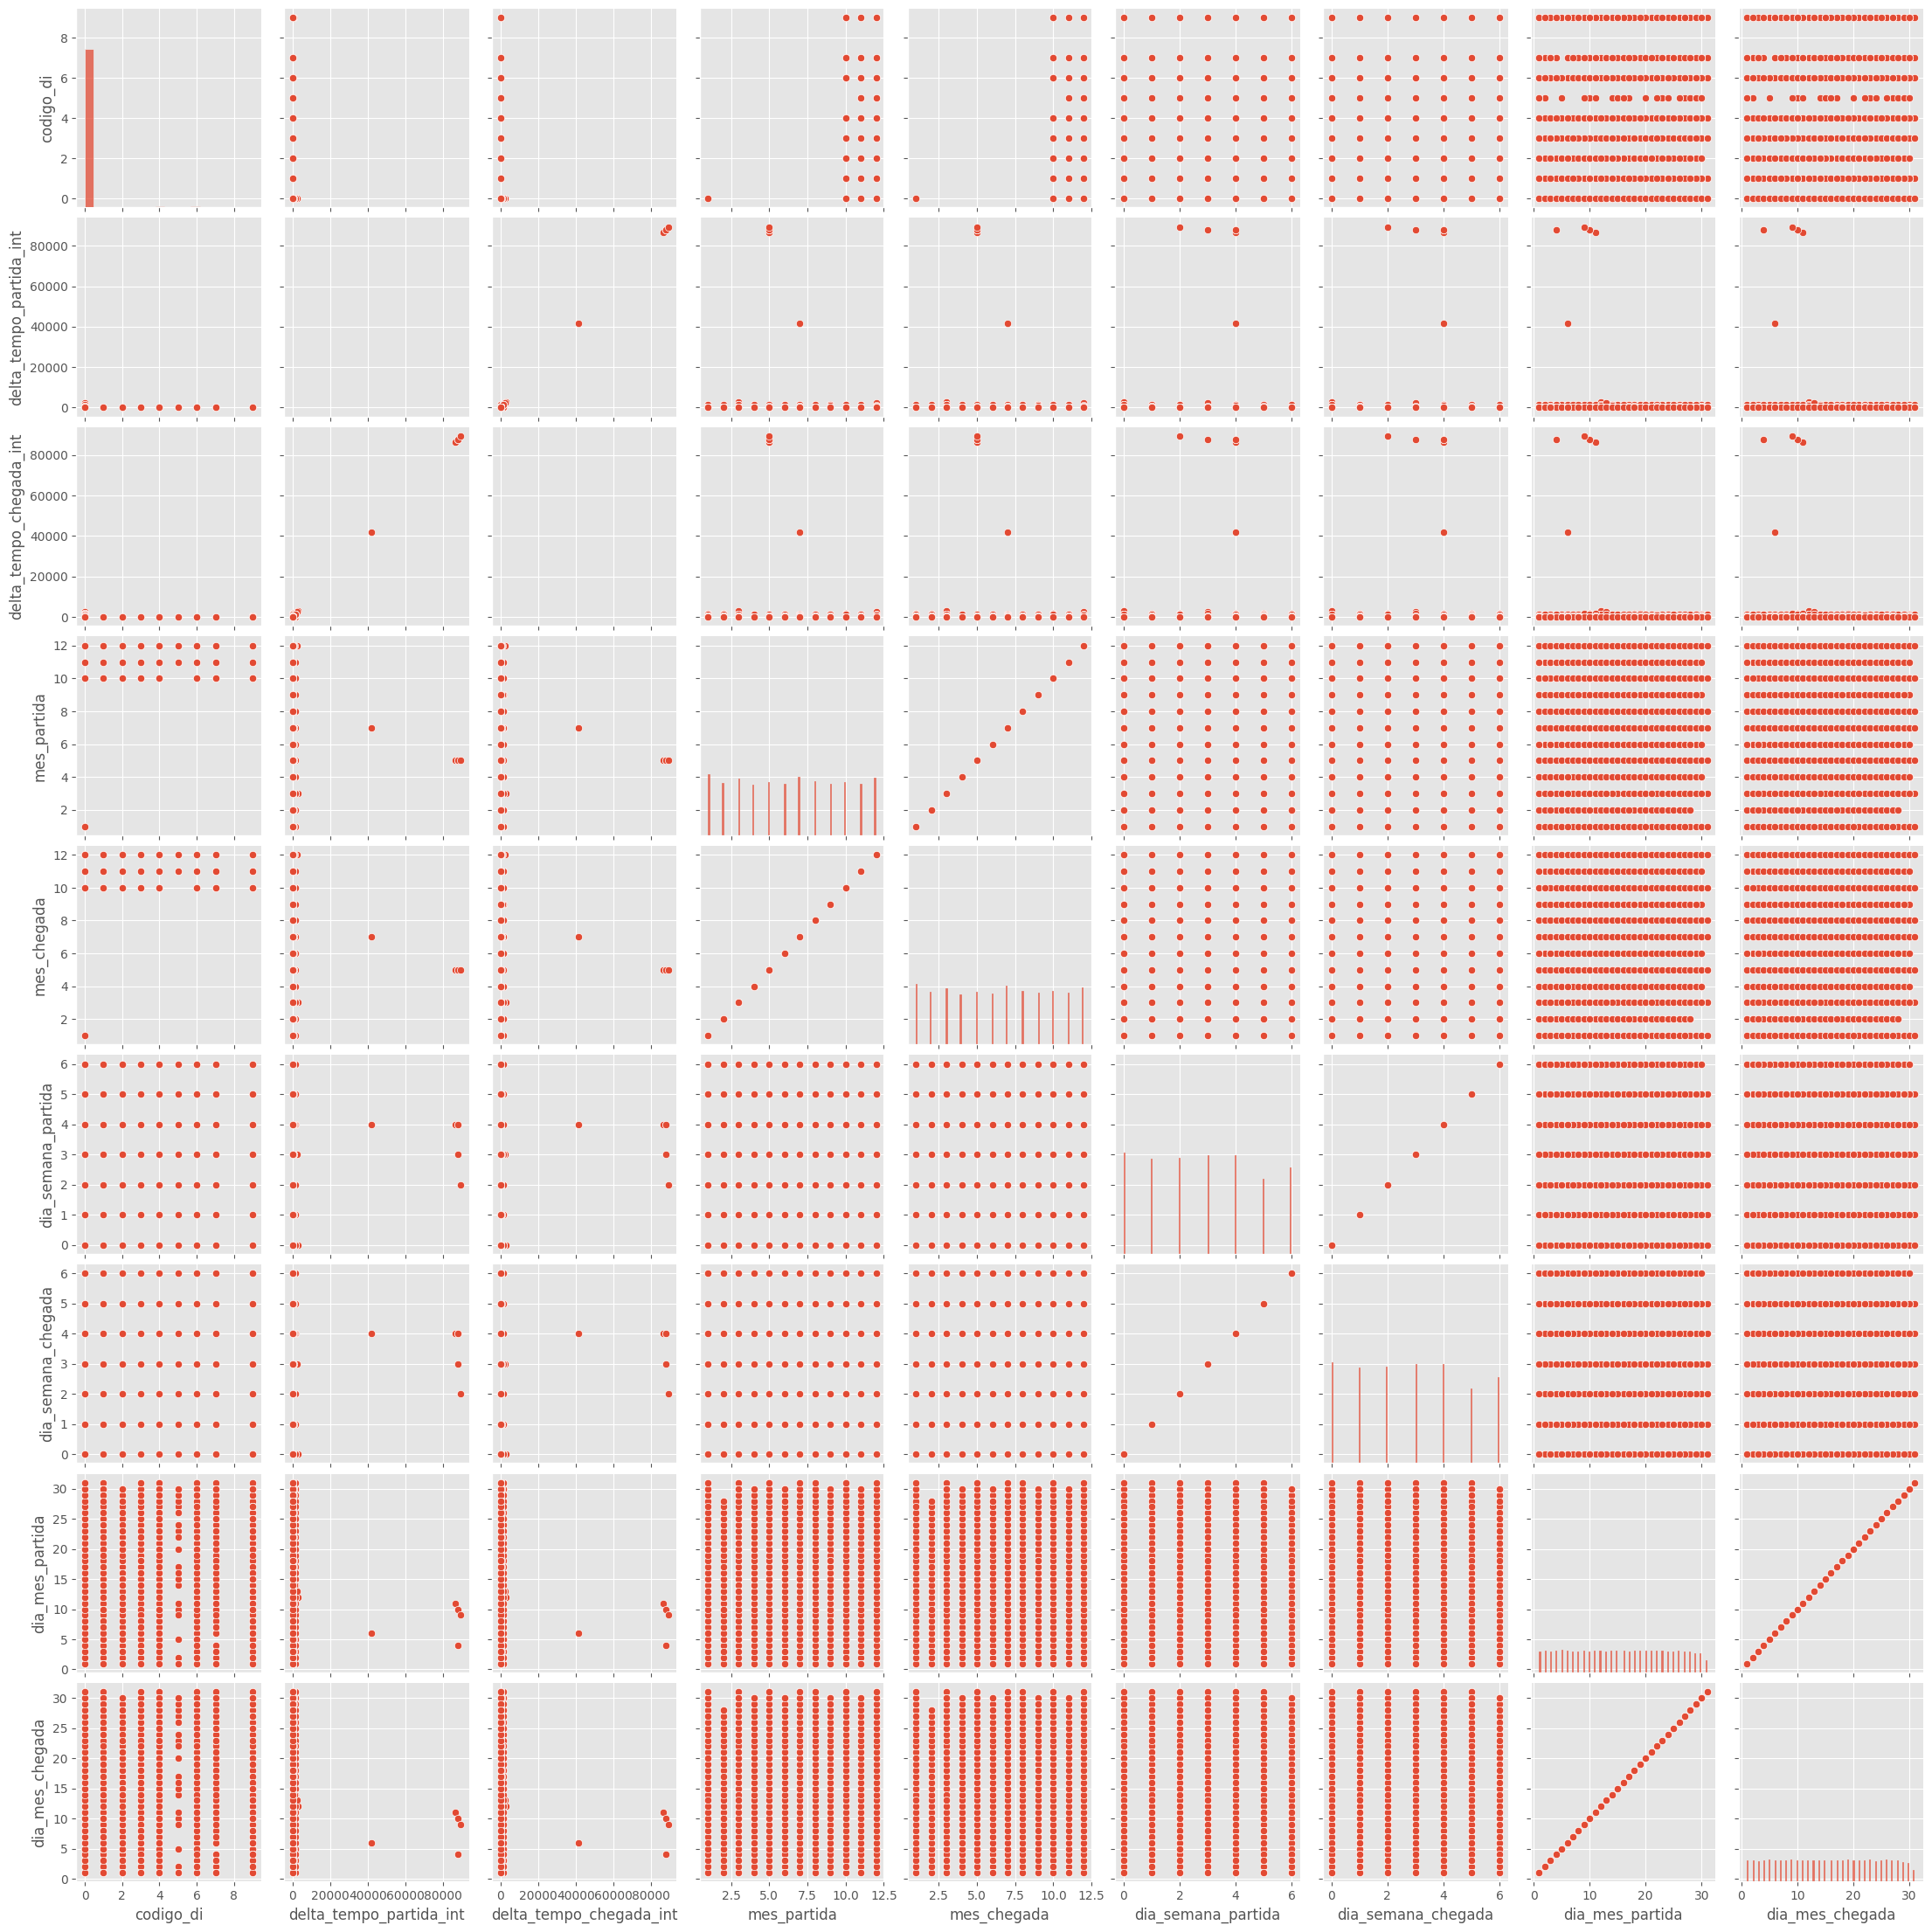

In [16]:
# Criando gráficos de pares para todas as colunas numéricas no DataFrame.
# 'sns.pairplot' cria uma grade de gráficos para cada par de colunas numéricas, mostrando sua relação.
sns.pairplot(colunas_numericas)

# Power Predict Score (PPscore)

CPU times: total: 22min 59s
Wall time: 23min 6s


<Axes: >

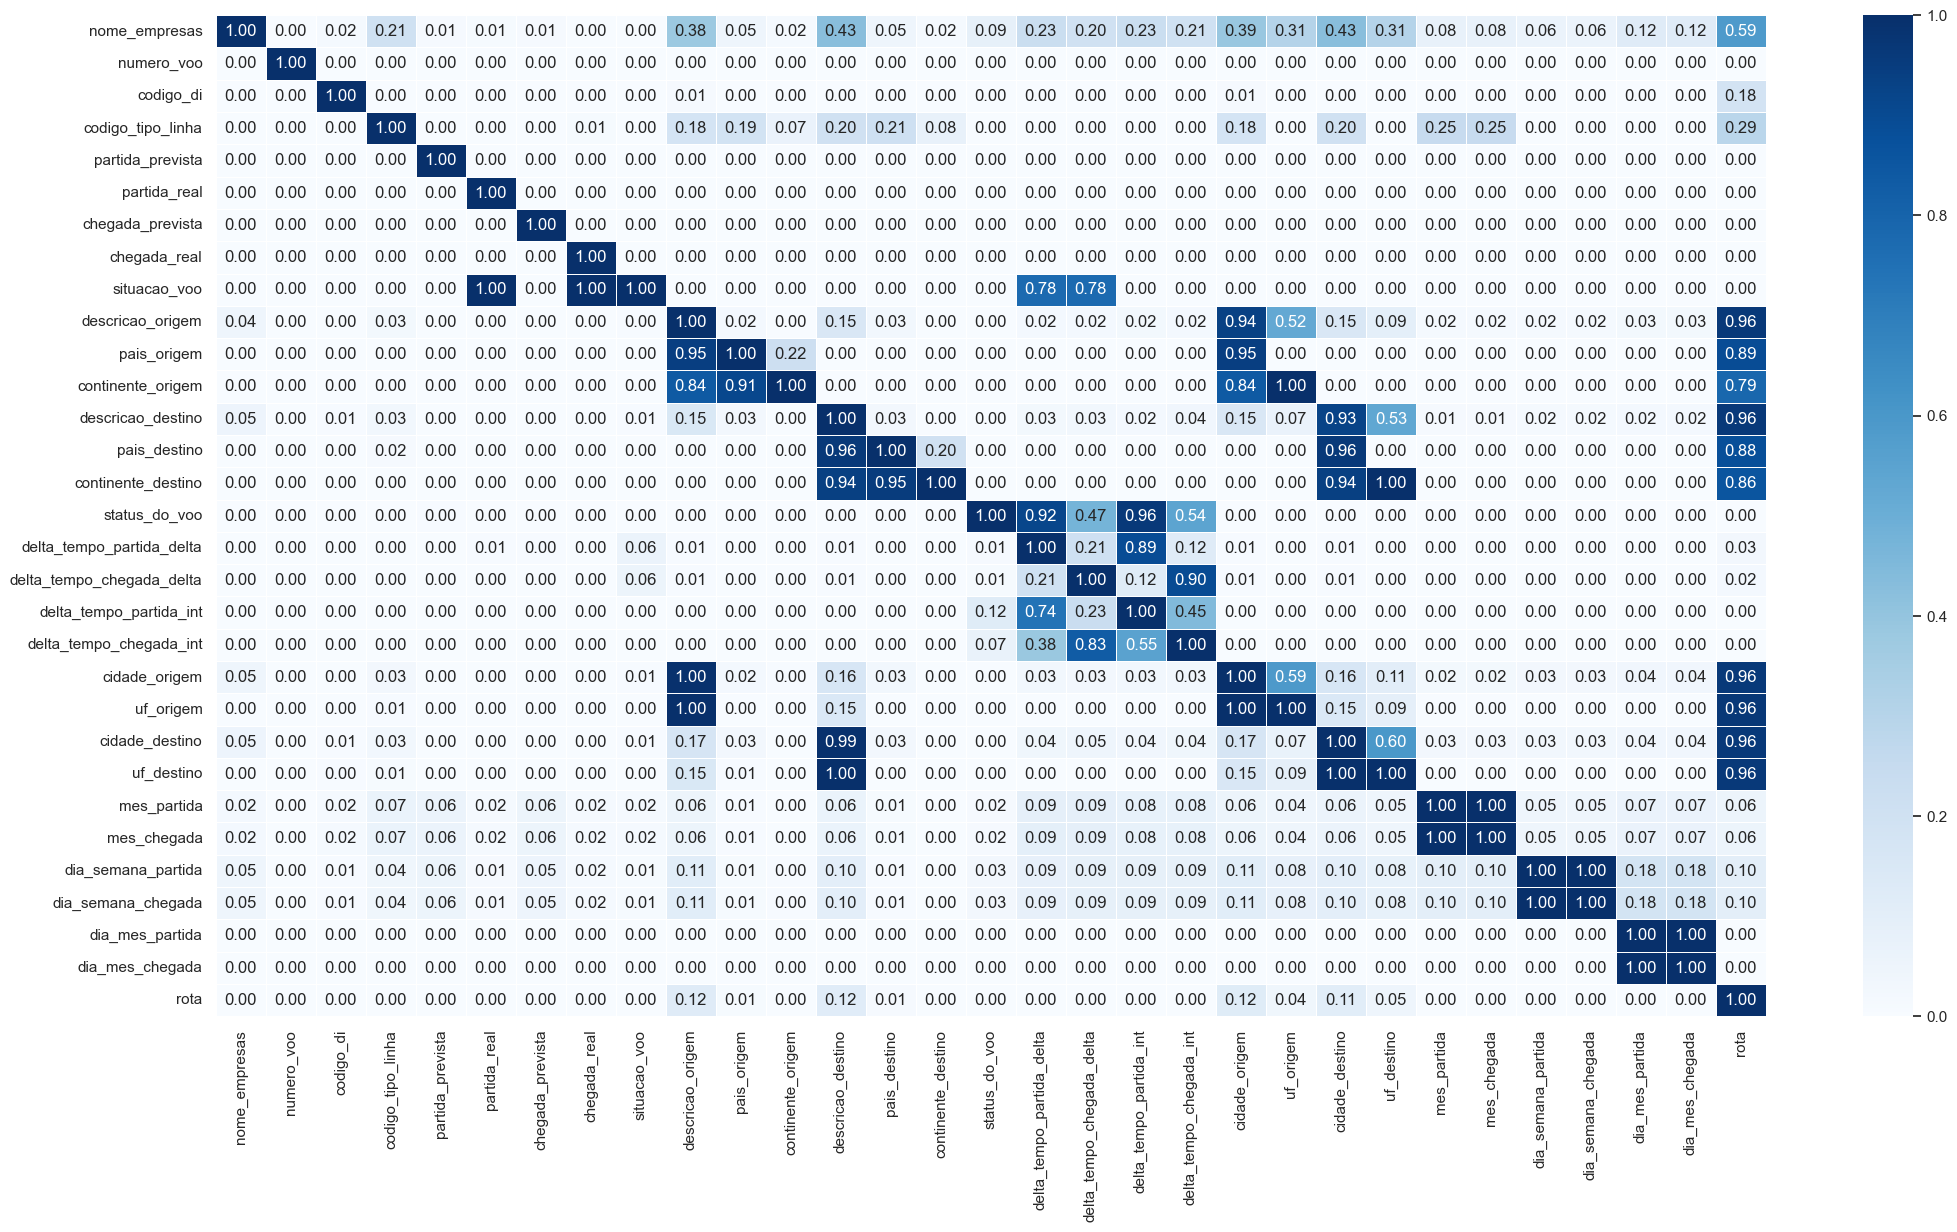

In [36]:
%%time
# Calculando e visualizando a matriz de preditividade de poder (Predictive Power Score - PPS).
# PPS é uma alternativa ao coeficiente de correlação de Pearson para medir a relação não linear entre variáveis.
# A pontuação varia de 0 (sem poder preditivo) a 1 (poder preditivo perfeito). Pode ser utilizado como alternativa à correlação (matriz).
df_matrix = pps.matrix(df)

# Criando um mapa de calor com os valores PPS.
# Valores de PPS variam de 0 a 1, onde 1 indica uma relação previsível perfeita entre duas variáveis.
sns.heatmap(df_matrix, vmin=0, vmax=1, annot=True, fmt='.2f', cmap="Blues", linewidths=0.5)

# Sobre o PPScore
# https://research.macrosynergy.com/the-predictive-power-score/
# https://pypi.org/project/ppscore/#:~:text=The%20PPS%20is%20an%20asymmetric,to%20the%20correlation%20(matrix).
# https://machinelearningknowledge.ai/predictive-power-score-vs-correlation-with-python-implementation/

# Gráficos descritivos

In [16]:
dic = {
    'font.sans-serif': ['Arial'],  # Fonte
    'font.family': ['Arial']}
sns.set_style(rc=dic)
plt.style.use('ggplot')

In [17]:
# Mapeamento para dias da semana e meses
mapeamento_dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

# Aplicando os mapeamentos
df['dia_semana_partida'] = df['dia_semana_partida'].map(mapeamento_dias)
df['dia_semana_chegada'] = df['dia_semana_chegada'].map(mapeamento_dias)
df['mes_partida'] = df['mes_partida'].map(mapeamento_meses)
df['mes_chegada'] = df['mes_chegada'].map(mapeamento_meses)

## Situação dos voos

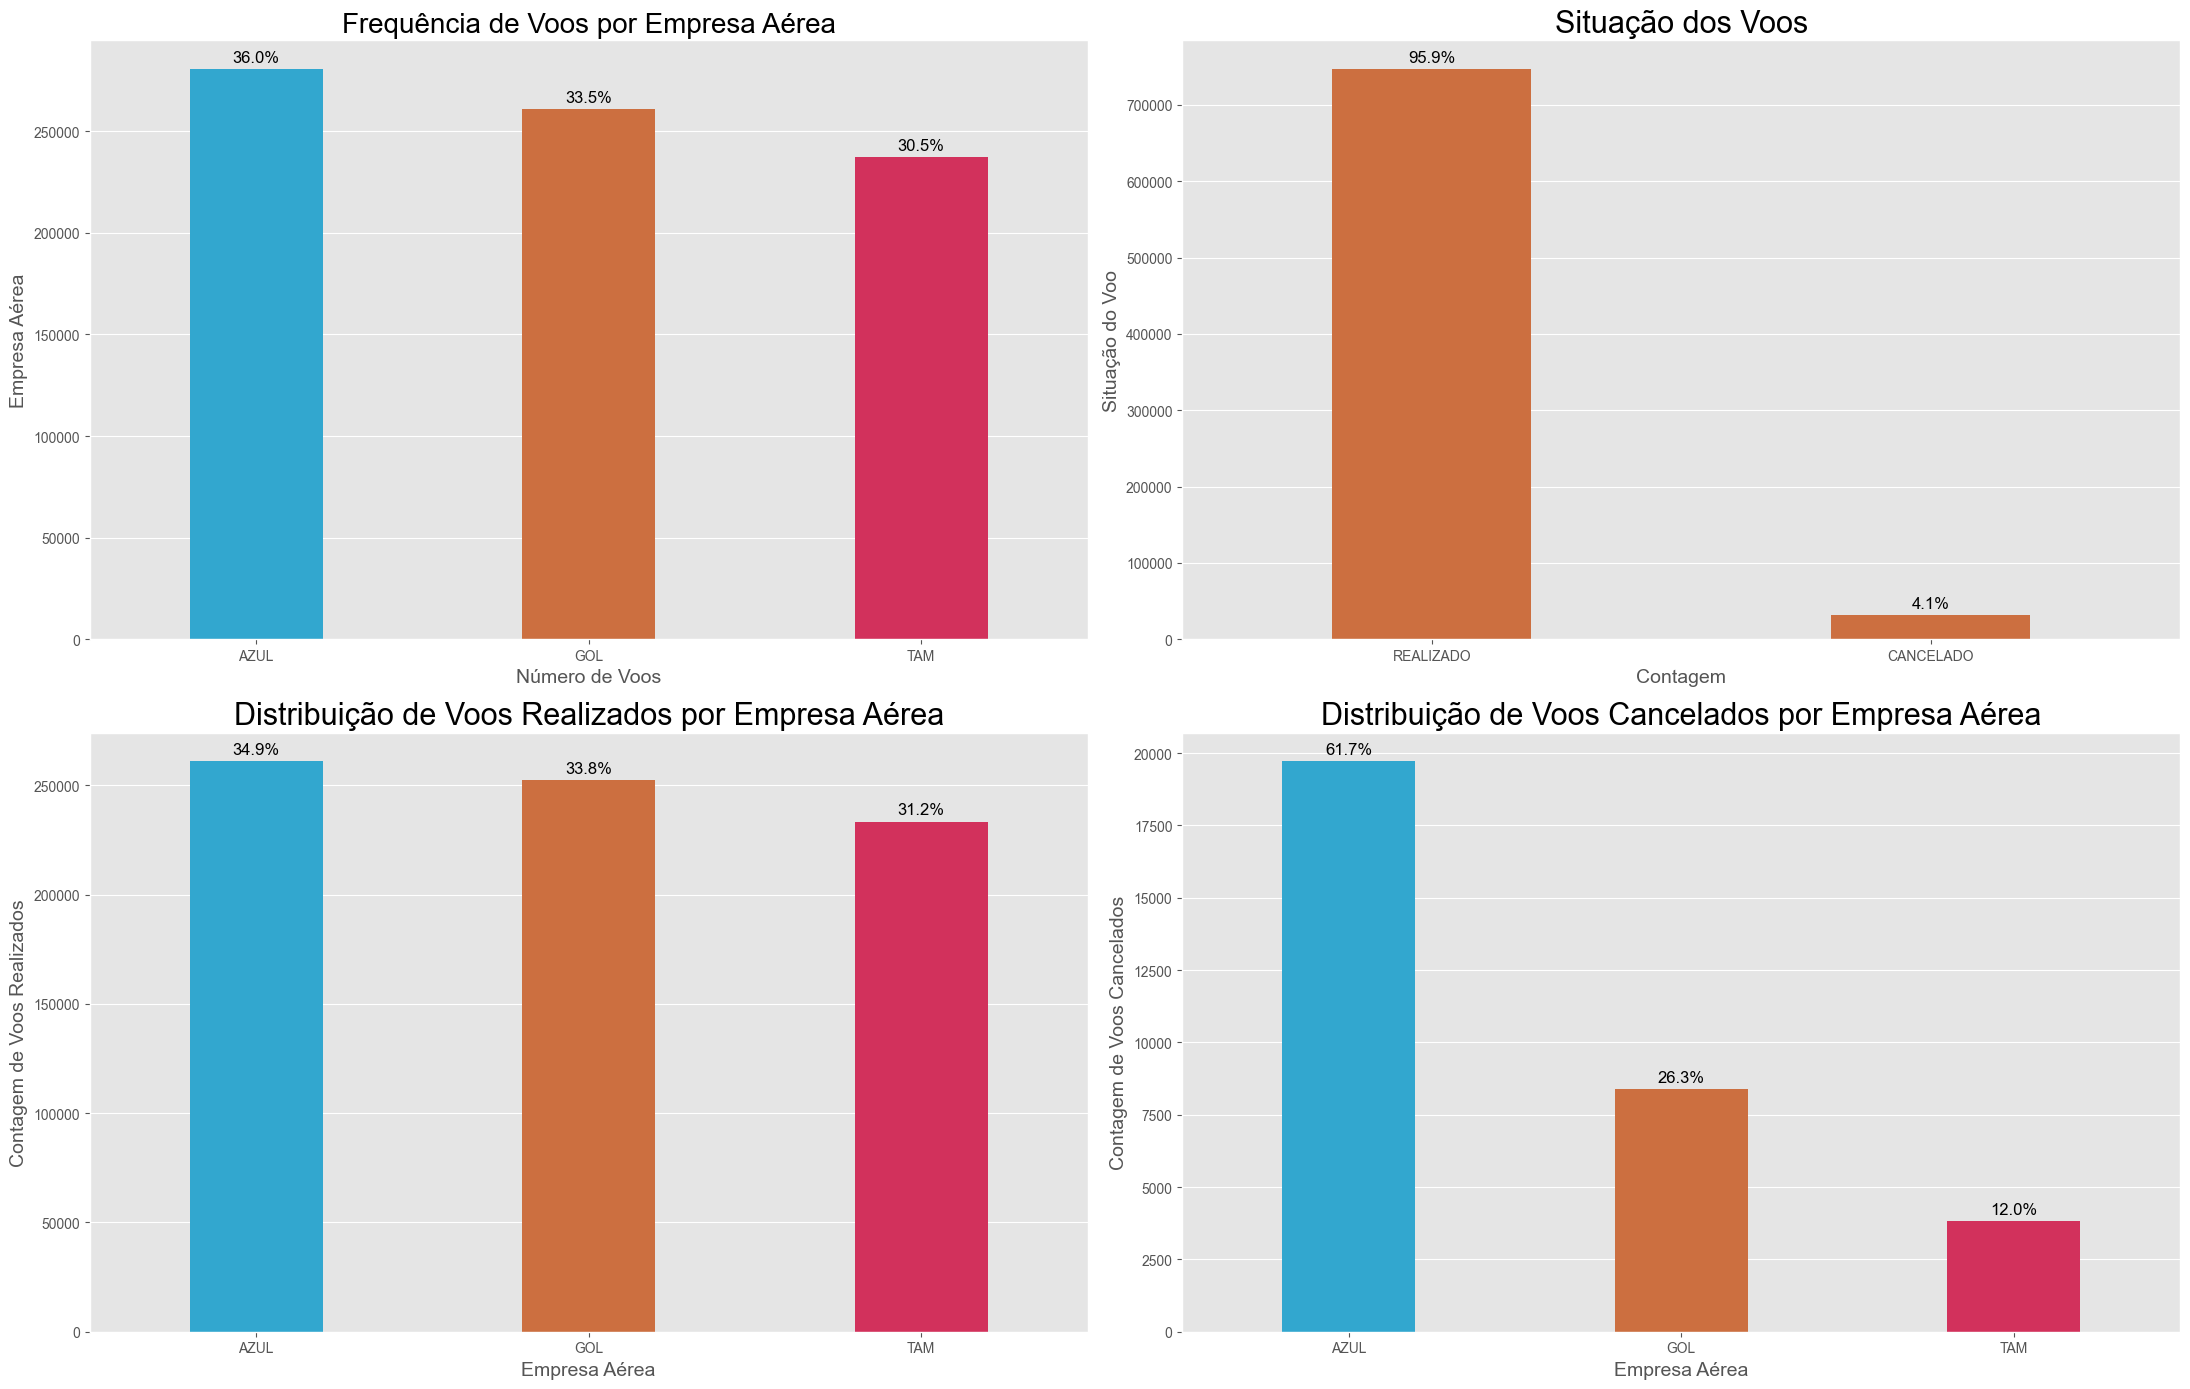

In [18]:
# Análise Visual da Frequência e Situação dos Voos por Empresa Aérea.

# Filtrando o DataFrame para separar voos cancelados e realizados.
voos_cancelados = df[df['situacao_voo'] == 'CANCELADO']
voos_realizados = df[df['situacao_voo'] == 'REALIZADO']

# Definindo a ordem e as cores para as companhias aéreas nos gráficos.
ordem = ['AZUL','GOL', 'TAM']
colors = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Configurando um ambiente de plotagem com subgráficos.
fig, axes = plt.subplots(2, 2, figsize=(22, 14))

# Criando um gráfico de contagem para a frequência geral de voos por empresa aérea.
sns.countplot(x='nome_empresas', data=df, ax=axes[0, 0], order=ordem, palette=colors)
axes[0, 0].set_title('Frequência de Voos por Empresa Aérea', fontsize=20)
axes[0, 0].set_xlabel('Número de Voos', fontsize=14)
axes[0, 0].set_ylabel('Empresa Aérea', fontsize=14)
change_width_x(axes[0, 0], new_value=0.4)
add_annotations_percentage_x(axes[0, 0], len(df), size=12)

# Criando um gráfico de contagem para a situação geral dos voos.
sns.countplot(x='situacao_voo', data=df, ax=axes[0, 1], order=df['situacao_voo'].value_counts().index, color='#E36729')
axes[0, 1].set_title('Situação dos Voos', fontsize=22)
axes[0, 1].set_xlabel('Contagem', fontsize=14)
axes[0, 1].set_ylabel('Situação do Voo', fontsize=14)
change_width_x(axes[0, 1], new_value=0.4)
add_annotations_percentage_x(axes[0, 1], len(df), size=12)

# Criando um gráfico de contagem para a distribuição de voos realizados por empresa aérea.
sns.countplot(x='nome_empresas', data=voos_realizados, ax=axes[1, 0], palette=colors, order=ordem)
axes[1, 0].set_title('Distribuição de Voos Realizados por Empresa Aérea', fontsize=22)
axes[1, 0].set_ylabel('Contagem de Voos Realizados', fontsize=14)
axes[1, 0].set_xlabel('Empresa Aérea', fontsize=14)
change_width_x(axes[1, 0], new_value=0.4)
add_annotations_percentage_x(axes[1, 0], len(voos_realizados), size=12)

# Criando um gráfico de contagem para a distribuição de voos cancelados por empresa aérea.
sns.countplot(x='nome_empresas', data=voos_cancelados, ax=axes[1, 1], palette=colors, order=ordem)
axes[1, 1].set_title('Distribuição de Voos Cancelados por Empresa Aérea', fontsize=22)
axes[1, 1].set_ylabel('Contagem de Voos Cancelados', fontsize=14)
axes[1, 1].set_xlabel('Empresa Aérea', fontsize=14)
change_width_x(axes[1, 1], new_value=0.4)
add_annotations_percentage_x(axes[1, 1], len(voos_cancelados), size=12)

# Ajustando o layout dos gráficos e exibindo-os.
plt.tight_layout()
plt.show()


### Dias da semana com principais cancelamentos

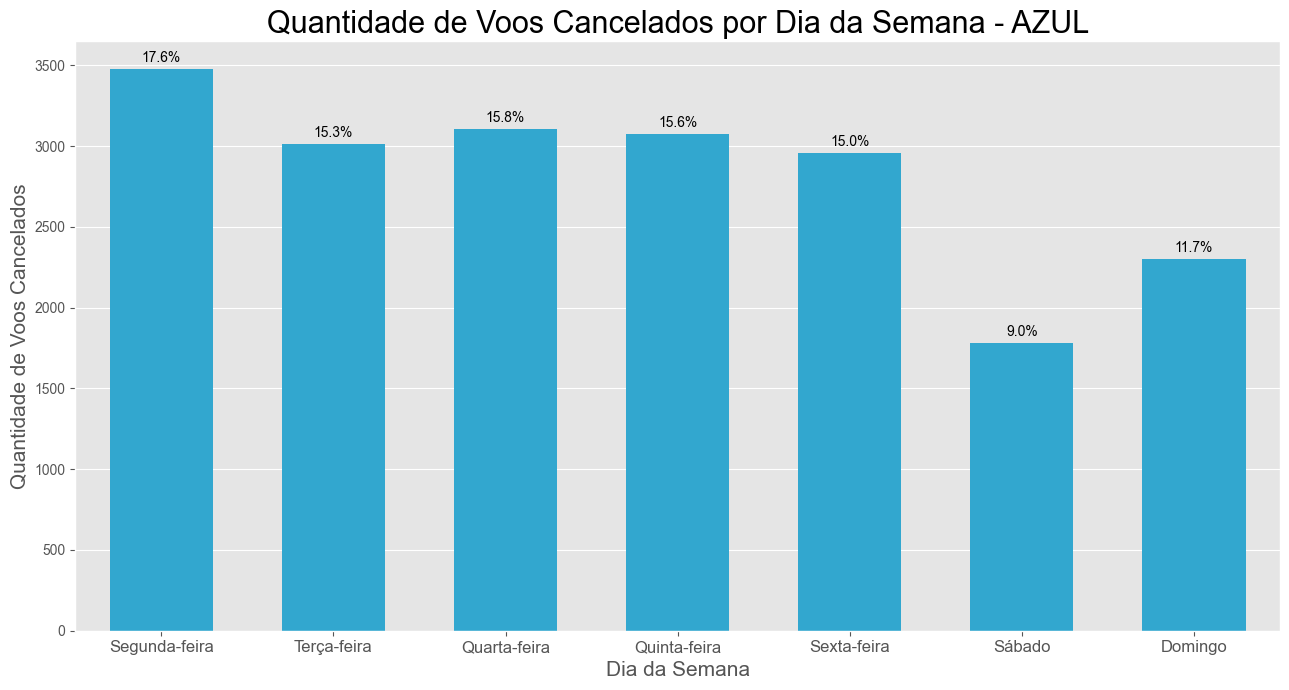

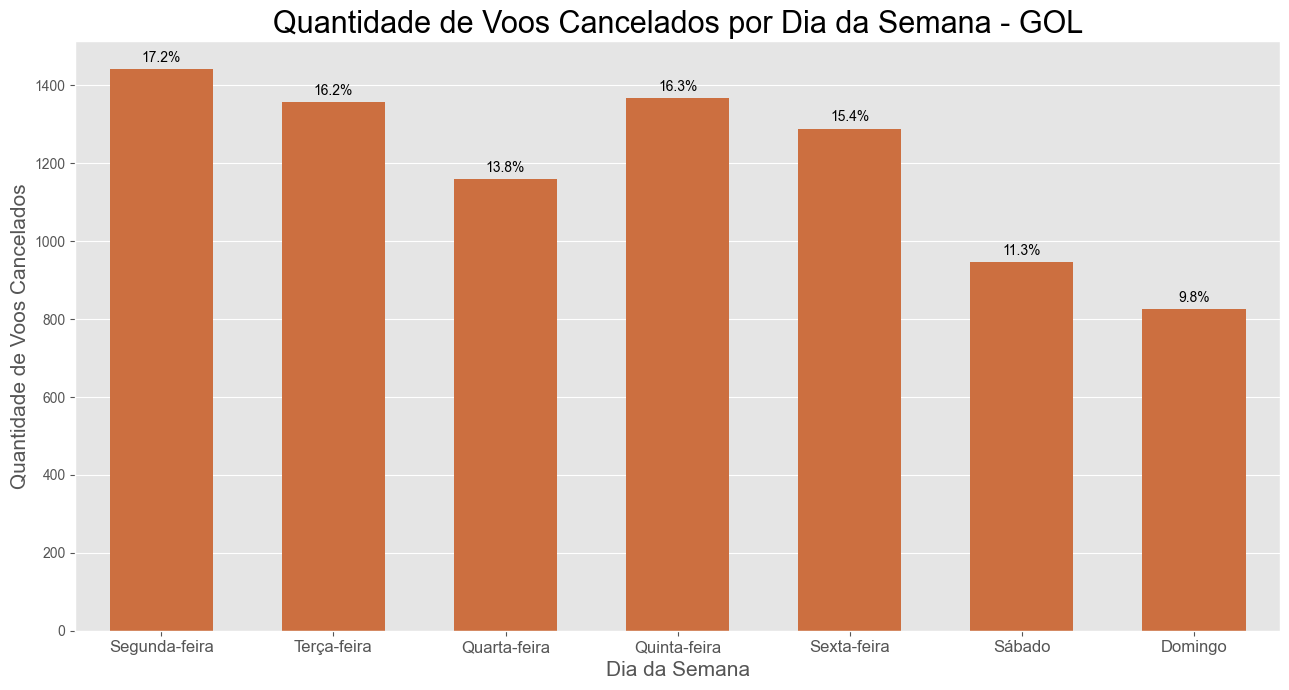

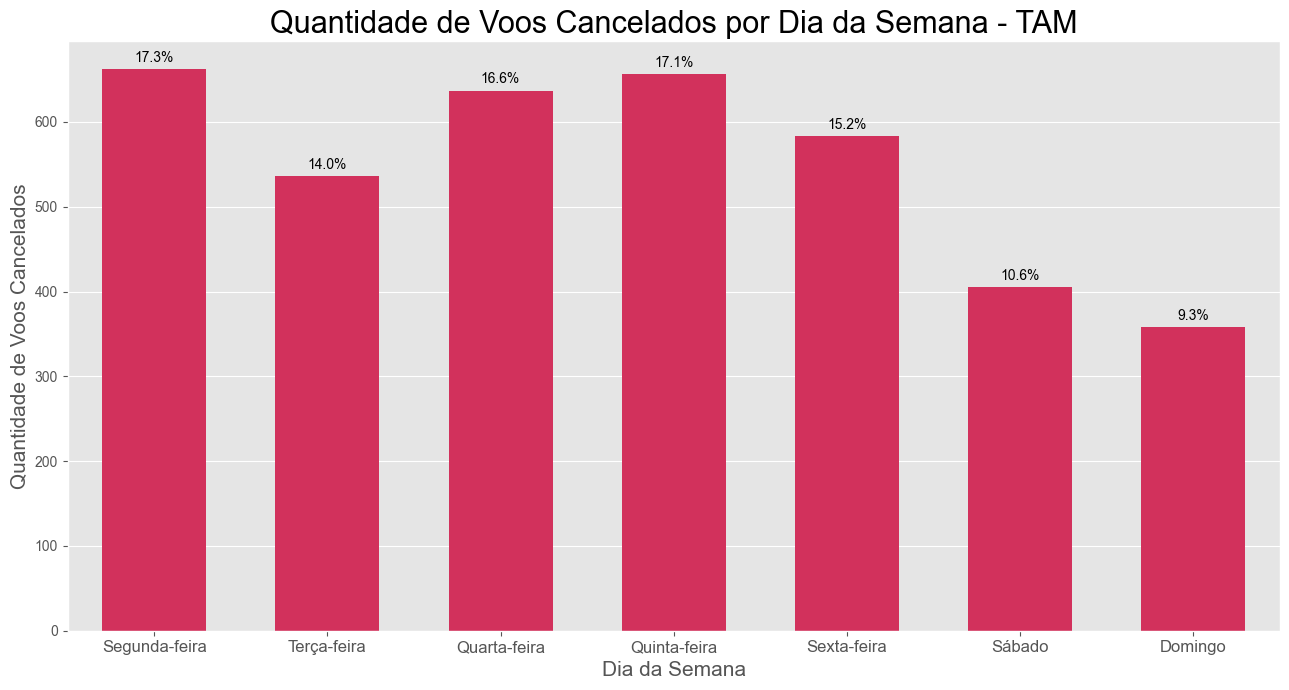

In [42]:
# Análise Visual dos Voos Cancelados por Dia da Semana para Cada Empresa Aérea.

# Filtrando os dados para obter apenas os voos cancelados.
df_cancelados = df[df['situacao_voo'] == 'CANCELADO']

# Ordenando os dias da semana para garantir a consistência nos gráficos.
dias_ordenados = list(mapeamento_dias.values())

# Definindo a paleta de cores para as empresas aéreas.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Agrupando os dados por nome da empresa e dia da semana da partida, contando os voos cancelados.
df_agrupado = df_cancelados.groupby(['nome_empresas', 'dia_semana_partida']).size().reset_index(name='quantidade')

# Criando um gráfico de barras para cada uma das principais empresas aéreas.
for empresa in ['AZUL','GOL', 'TAM']:
    df_empresa = df_agrupado[df_agrupado['nome_empresas'] == empresa]
    
    # Configurando o tamanho e criando o gráfico de barras.
    plt.figure(figsize=(13, 7))
    ax = sns.barplot(x='dia_semana_partida', y='quantidade', data=df_empresa, 
                     order=dias_ordenados, color=cores_empresas[empresa])
    
    # Definindo títulos e rótulos do gráfico.
    plt.title(f'Quantidade de Voos Cancelados por Dia da Semana - {empresa}', fontsize=22)
    plt.xlabel('Dia da Semana', fontsize=15)
    plt.ylabel('Quantidade de Voos Cancelados', fontsize=15)
    
    # Ajustando a orientação dos rótulos do eixo x.
    plt.xticks(rotation=0, fontsize=12)

    # Alterando a largura das barras e adicionando anotações de porcentagem.
    change_width_x(ax, new_value=0.6)
    total_count = df_empresa['quantidade'].sum()
    add_annotations_percentage_x(ax, total_count)

    # Ajustando o layout e exibindo o gráfico.
    plt.tight_layout()
    plt.show()


### Meses com mais cancelamentos de voos

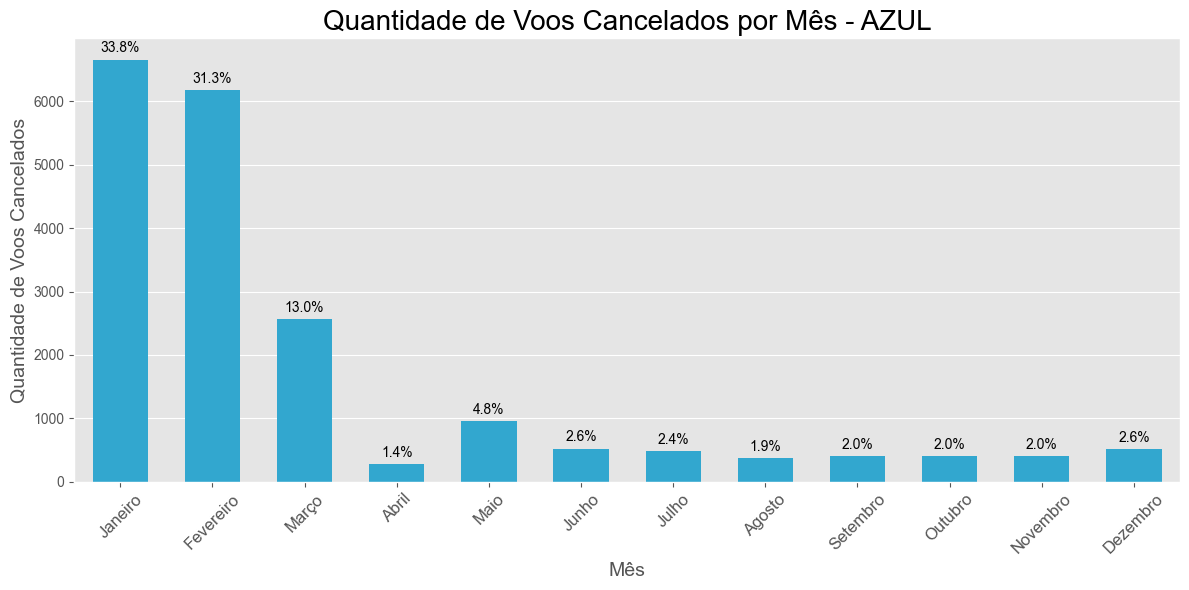

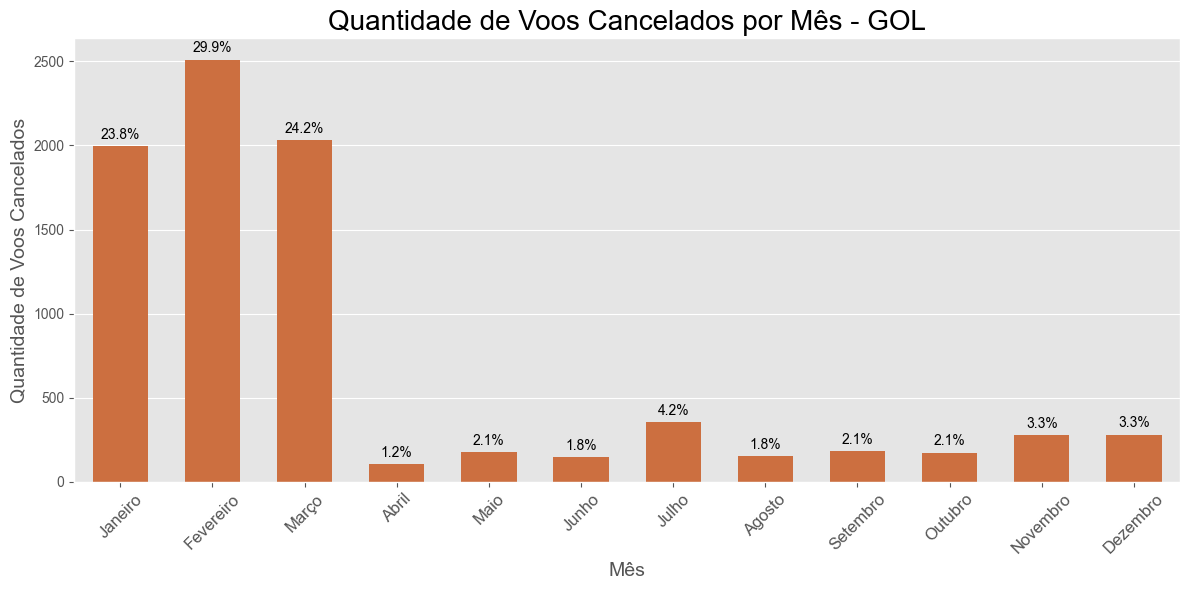

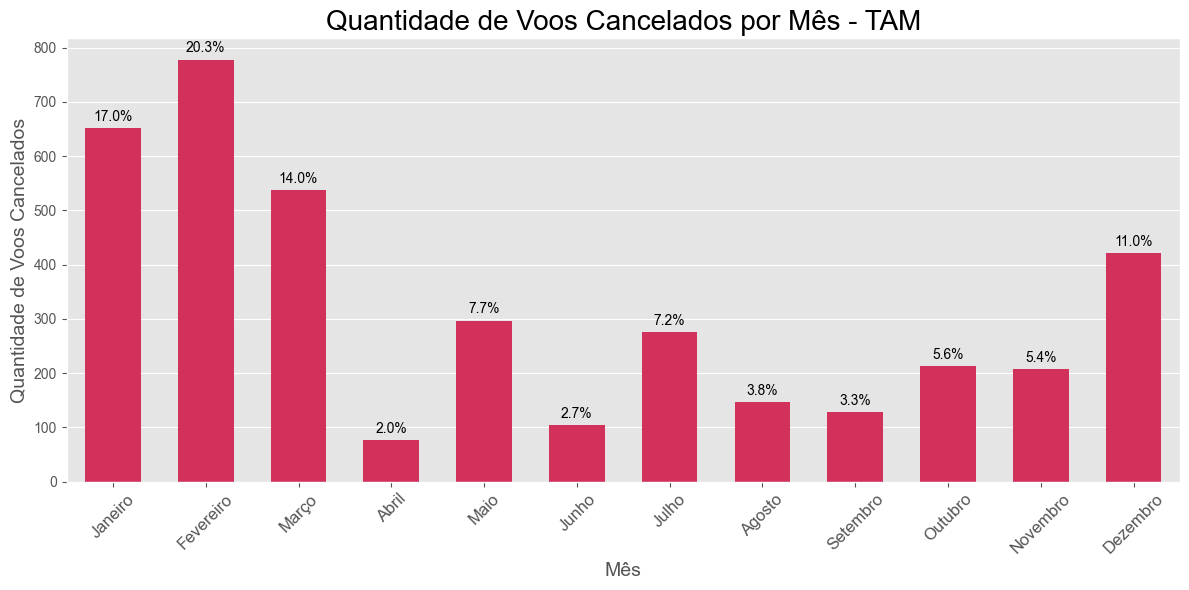

In [43]:
# Análise Visual dos Voos Cancelados por Mês para Cada Empresa Aérea.

# Filtrando o DataFrame para obter apenas os voos cancelados.
df_cancelados = df[df['situacao_voo'] == 'CANCELADO']

# Mapeando os números dos meses para os nomes correspondentes.
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
#df_cancelados['mes_partida'] = df_cancelados['mes_partida'].map(mapeamento_meses)

# Ordenando os meses para garantir a consistência nos gráficos.
meses_ordenados = list(mapeamento_meses.values())

# Agrupando os dados por nome da empresa e mês da partida, contando os voos cancelados.
df_agrupado = df_cancelados.groupby(['nome_empresas', 'mes_partida']).size().reset_index(name='quantidade')

# Definindo a paleta de cores para as empresas aéreas.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Criando um gráfico de barras para cada uma das principais empresas aéreas.
for empresa in ['AZUL','GOL', 'TAM']:
    df_empresa = df_agrupado[df_agrupado['nome_empresas'] == empresa]
    
    # Configurando o tamanho e criando o gráfico de barras.
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='mes_partida', y='quantidade', data=df_empresa, 
                     order=meses_ordenados, color=cores_empresas[empresa])
    
    # Definindo títulos e rótulos do gráfico.
    plt.title(f'Quantidade de Voos Cancelados por Mês - {empresa}', fontsize=20)
    plt.xlabel('Mês', fontsize=14)
    plt.ylabel('Quantidade de Voos Cancelados', fontsize=14)
    
    # Ajustando a orientação dos rótulos do eixo x.
    plt.xticks(rotation=45, fontsize=12)

    # Alterando a largura das barras e adicionando anotações de porcentagem.
    change_width_x(ax, new_value=0.6)
    total_count = df_empresa['quantidade'].sum()
    add_annotations_percentage_x(ax, total_count)

    # Ajustando o layout e exibindo o gráfico.
    plt.tight_layout()
    plt.show()


### Rotas com cancelamentos

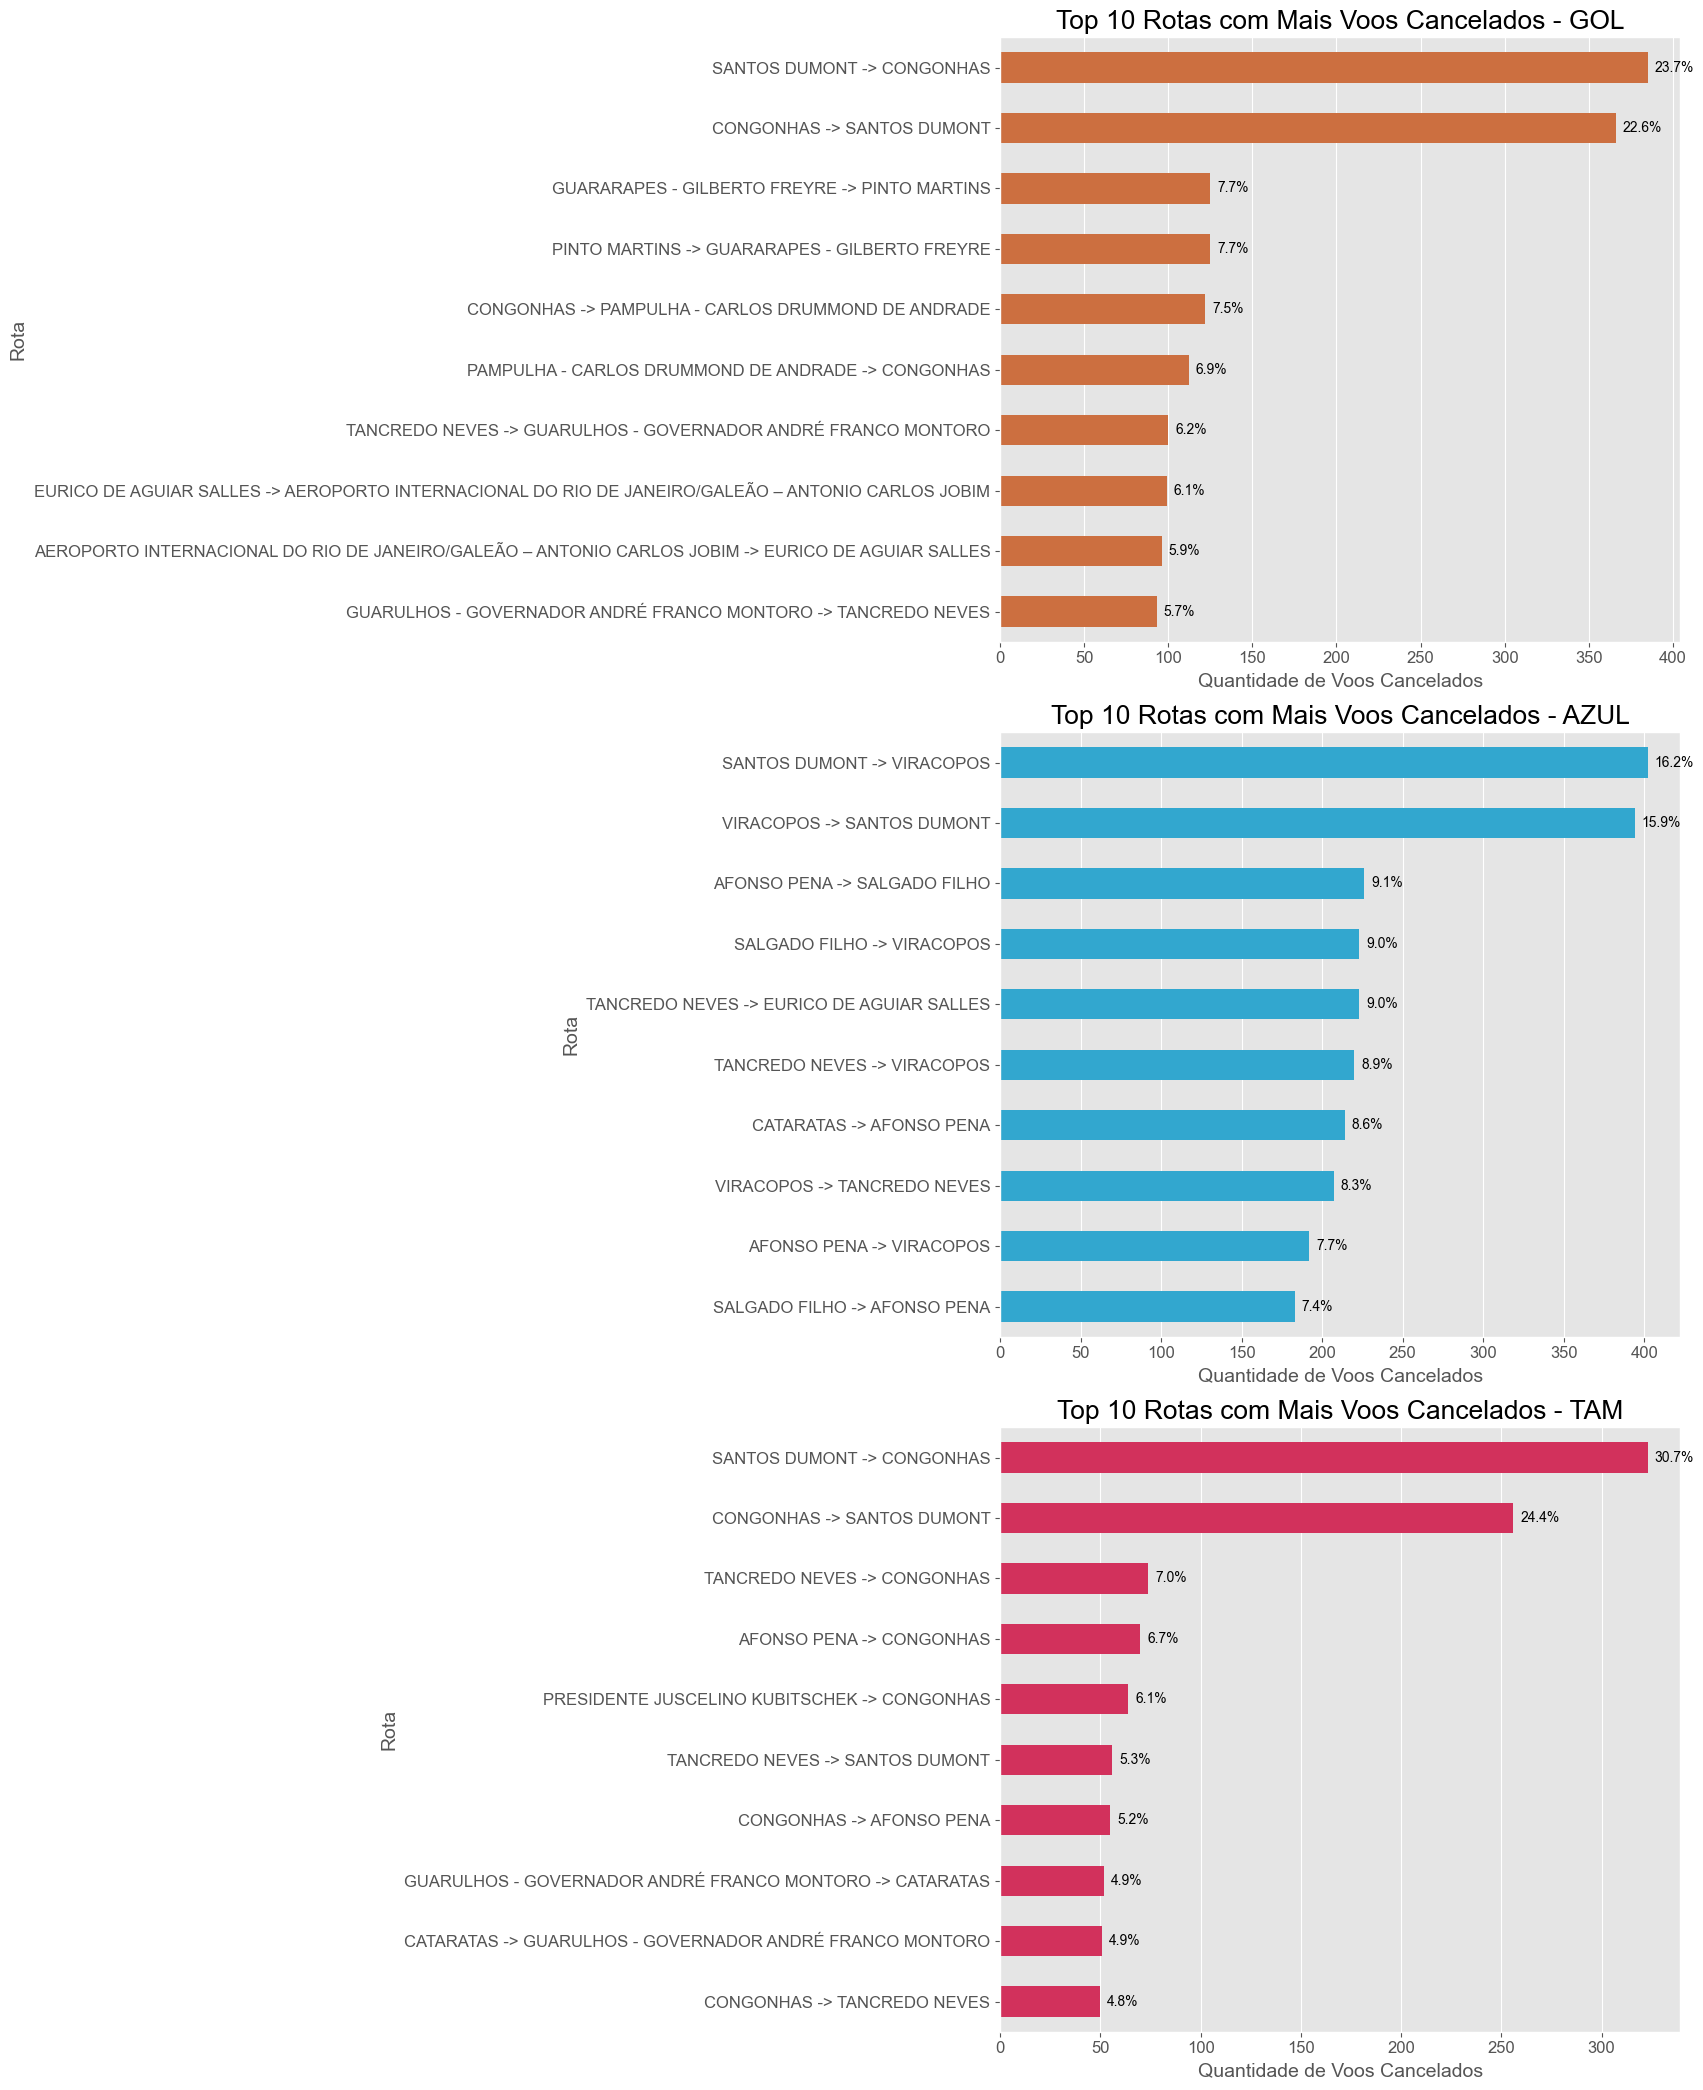

In [21]:
# Análise das Rotas Mais Comuns para Voos Cancelados por Empresa Aérea.

# Filtrando o DataFrame para incluir apenas voos cancelados.
df_cancelados = df[df['situacao_voo'] == 'CANCELADO']

# Verificação da existência da coluna 'rota' em df_cancelados.
# É necessário assegurar que a coluna 'rota' esteja presente para prosseguir com a análise.

# Agrupando os dados por nome da empresa e rota, contando a quantidade de voos cancelados.
df_agrupado = df_cancelados.groupby(['nome_empresas', 'rota']).size().reset_index(name='quantidade')

# Definindo a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Selecionando as principais empresas aéreas para análise.
empresas_selecionadas = list(cores_empresas.keys())

# Preparando o ambiente de plotagem com subgráficos para cada empresa.
fig, axes = plt.subplots(len(empresas_selecionadas), 1, figsize=(17, 7 * len(empresas_selecionadas)), squeeze=False)

# Criando um gráfico de barras para cada empresa aérea.
for i, empresa in enumerate(empresas_selecionadas):
    # Filtrando os dados para a empresa atual e selecionando as top 10 rotas com mais voos cancelados.
    df_empresa = df_agrupado[df_agrupado['nome_empresas'] == empresa]
    df_top_rotas = df_empresa.nlargest(10, 'quantidade')

    # Criando o gráfico de barras para as rotas com mais voos cancelados.
    ax = sns.barplot(x='quantidade', y='rota', data=df_top_rotas, ax=axes[i, 0], color=cores_empresas[empresa])
    
    # Definindo títulos e rótulos do gráfico.
    axes[i, 0].set_title(f'Top 10 Rotas com Mais Voos Cancelados - {empresa}', fontsize=19)
    axes[i, 0].set_xlabel('Quantidade de Voos Cancelados', fontsize=14)
    axes[i, 0].set_ylabel('Rota', fontsize=14)
    axes[i, 0].tick_params(axis='y', labelsize=12)
    axes[i, 0].tick_params(axis='x', labelsize=12)

    # Alterando a altura das barras e adicionando anotações de porcentagem.
    change_width_y(axes[i, 0], 0.5)
    total_count = df_top_rotas['quantidade'].sum()
    add_annotations_percentage_y(axes[i, 0], total_count)

# Ajustando o layout e exibindo os gráficos.
plt.tight_layout()
plt.show()


## Status do voo

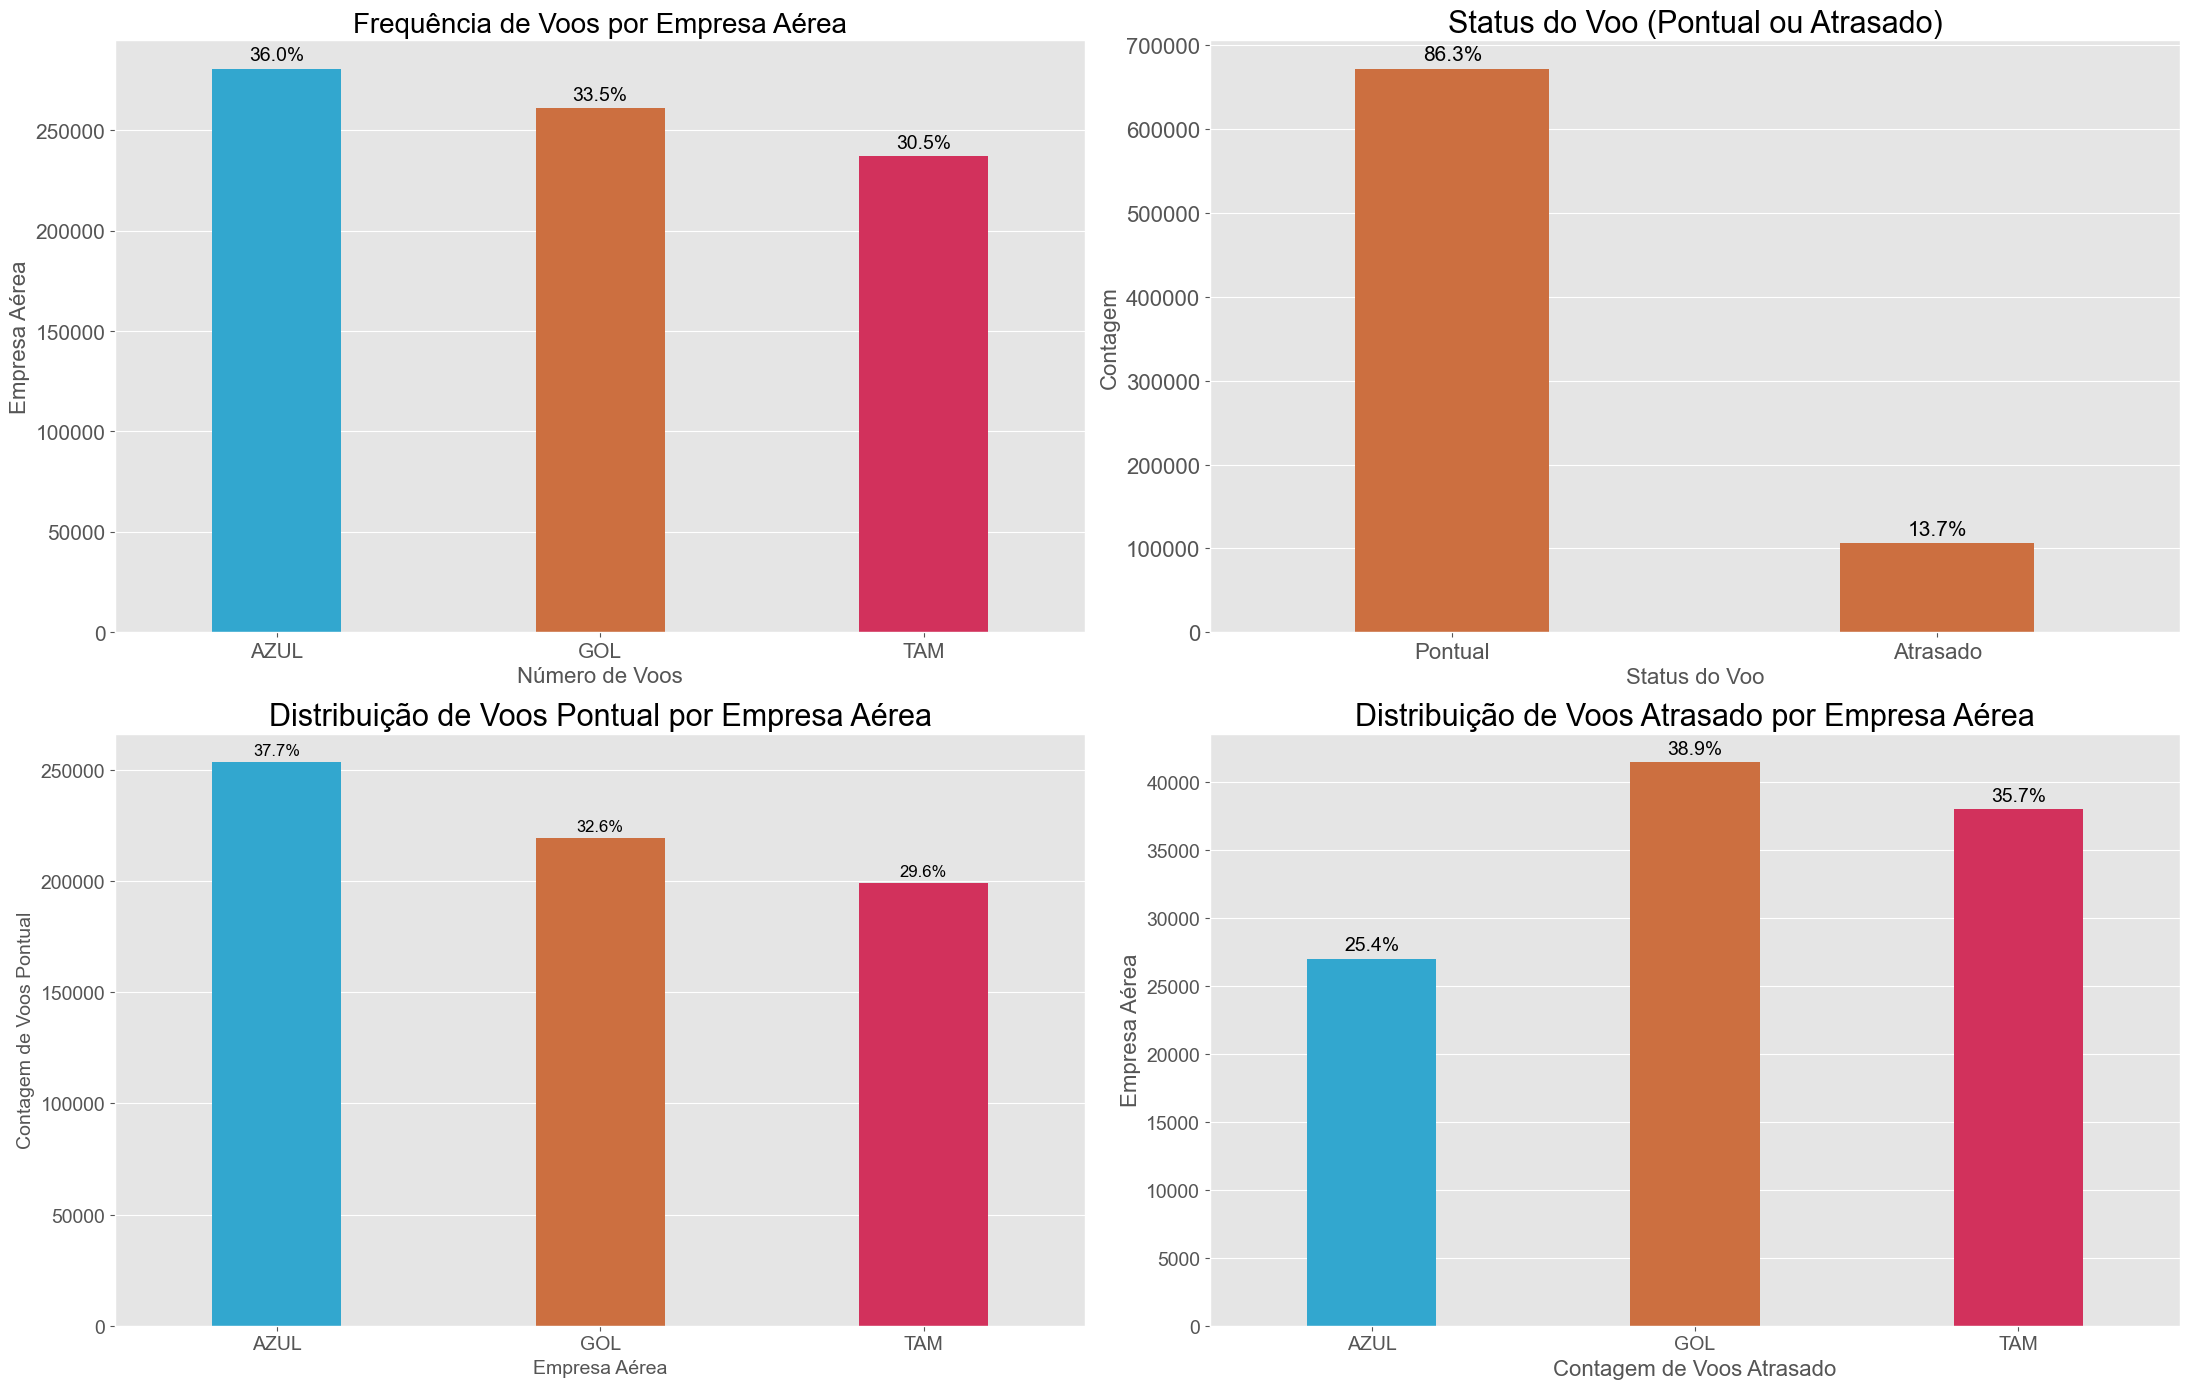

In [44]:
# Análise Visual da Frequência e Status dos Voos por Empresa Aérea.

# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Filtrando o DataFrame para separar voos pontuais e atrasados.
voos_pontual = df[df['status_do_voo'] == 'Pontual']
voos_atrasado = df[df['status_do_voo'] == 'Atrasado']

# Definindo a ordem específica das companhias aéreas e suas respectivas cores para os gráficos.
ordem = ['AZUL','GOL', 'TAM']
colors = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Configurando um ambiente de plotagem com subgráficos.
fig, axes = plt.subplots(2, 2, figsize=(22, 14))

# Criando um gráfico de contagem para o status geral dos voos (Pontual ou Atrasado).
sns.countplot(x='status_do_voo', data=df, ax=axes[0, 1], 
              order=df['status_do_voo'].value_counts().index, color='#E36729')
axes[0, 1].set_title('Status do Voo (Pontual ou Atrasado)', fontsize=22)
axes[0, 1].set_ylabel('Contagem', fontsize=16)
axes[0, 1].set_xlabel('Status do Voo', fontsize=16)
axes[0, 1].tick_params(axis='y', labelsize=16)
axes[0, 1].tick_params(axis='x', labelsize=16)
change_width_x(axes[0, 1], new_value=0.4)
add_annotations_percentage_x(axes[0, 1], len(df), size=15)


# Criando um gráfico de contagem para a frequência geral de voos por empresa aérea.
sns.countplot(x='nome_empresas', data=df, ax=axes[0, 0], order=ordem, palette=colors)
axes[0, 0].set_title('Frequência de Voos por Empresa Aérea', fontsize=20)
axes[0, 0].set_xlabel('Número de Voos', fontsize=16)
axes[0, 0].set_ylabel('Empresa Aérea', fontsize=16)
axes[0, 0].tick_params(axis='y', labelsize=15)
axes[0, 0].tick_params(axis='x', labelsize=15)
change_width_x(axes[0, 0], new_value=0.4)
add_annotations_percentage_x(axes[0, 0], len(df), size=14)

# Criando gráficos separados para voos pontuais e atrasados, por empresa aérea.
# Gráfico para voos pontuais.
sns.countplot(x='nome_empresas', data=voos_pontual, ax=axes[1, 0], palette=colors, order=ordem)
axes[1, 0].set_title('Distribuição de Voos Pontual por Empresa Aérea', fontsize=22)
axes[1, 0].set_ylabel('Contagem de Voos Pontual', fontsize=14)
axes[1, 0].set_xlabel('Empresa Aérea', fontsize=14)
axes[1, 0].tick_params(axis='y', labelsize=14)
axes[1, 0].tick_params(axis='x', labelsize=14)
change_width_x(axes[1, 0], new_value=0.4)
add_annotations_percentage_x(axes[1, 0], len(voos_pontual), size=12)

# Gráfico para voos atrasados.
sns.countplot(x='nome_empresas', data=voos_atrasado, ax=axes[1, 1], palette=colors, order=ordem)
axes[1, 1].set_title('Distribuição de Voos Atrasado por Empresa Aérea', fontsize=22)
axes[1, 1].set_xlabel('Contagem de Voos Atrasado', fontsize=16)
axes[1, 1]. set_ylabel('Empresa Aérea', fontsize=16)
change_width_x(axes[1, 1], new_value=0.4)
add_annotations_percentage_x(axes[1, 1], len(voos_atrasado), size=14)
axes[1, 1].tick_params(axis='y', labelsize=14)
axes[1, 1].tick_params(axis='x', labelsize=14)

# Ajustando o layout e exibindo os gráficos.
plt.tight_layout()
plt.show()


### Dias da semana com mais voos atrasados

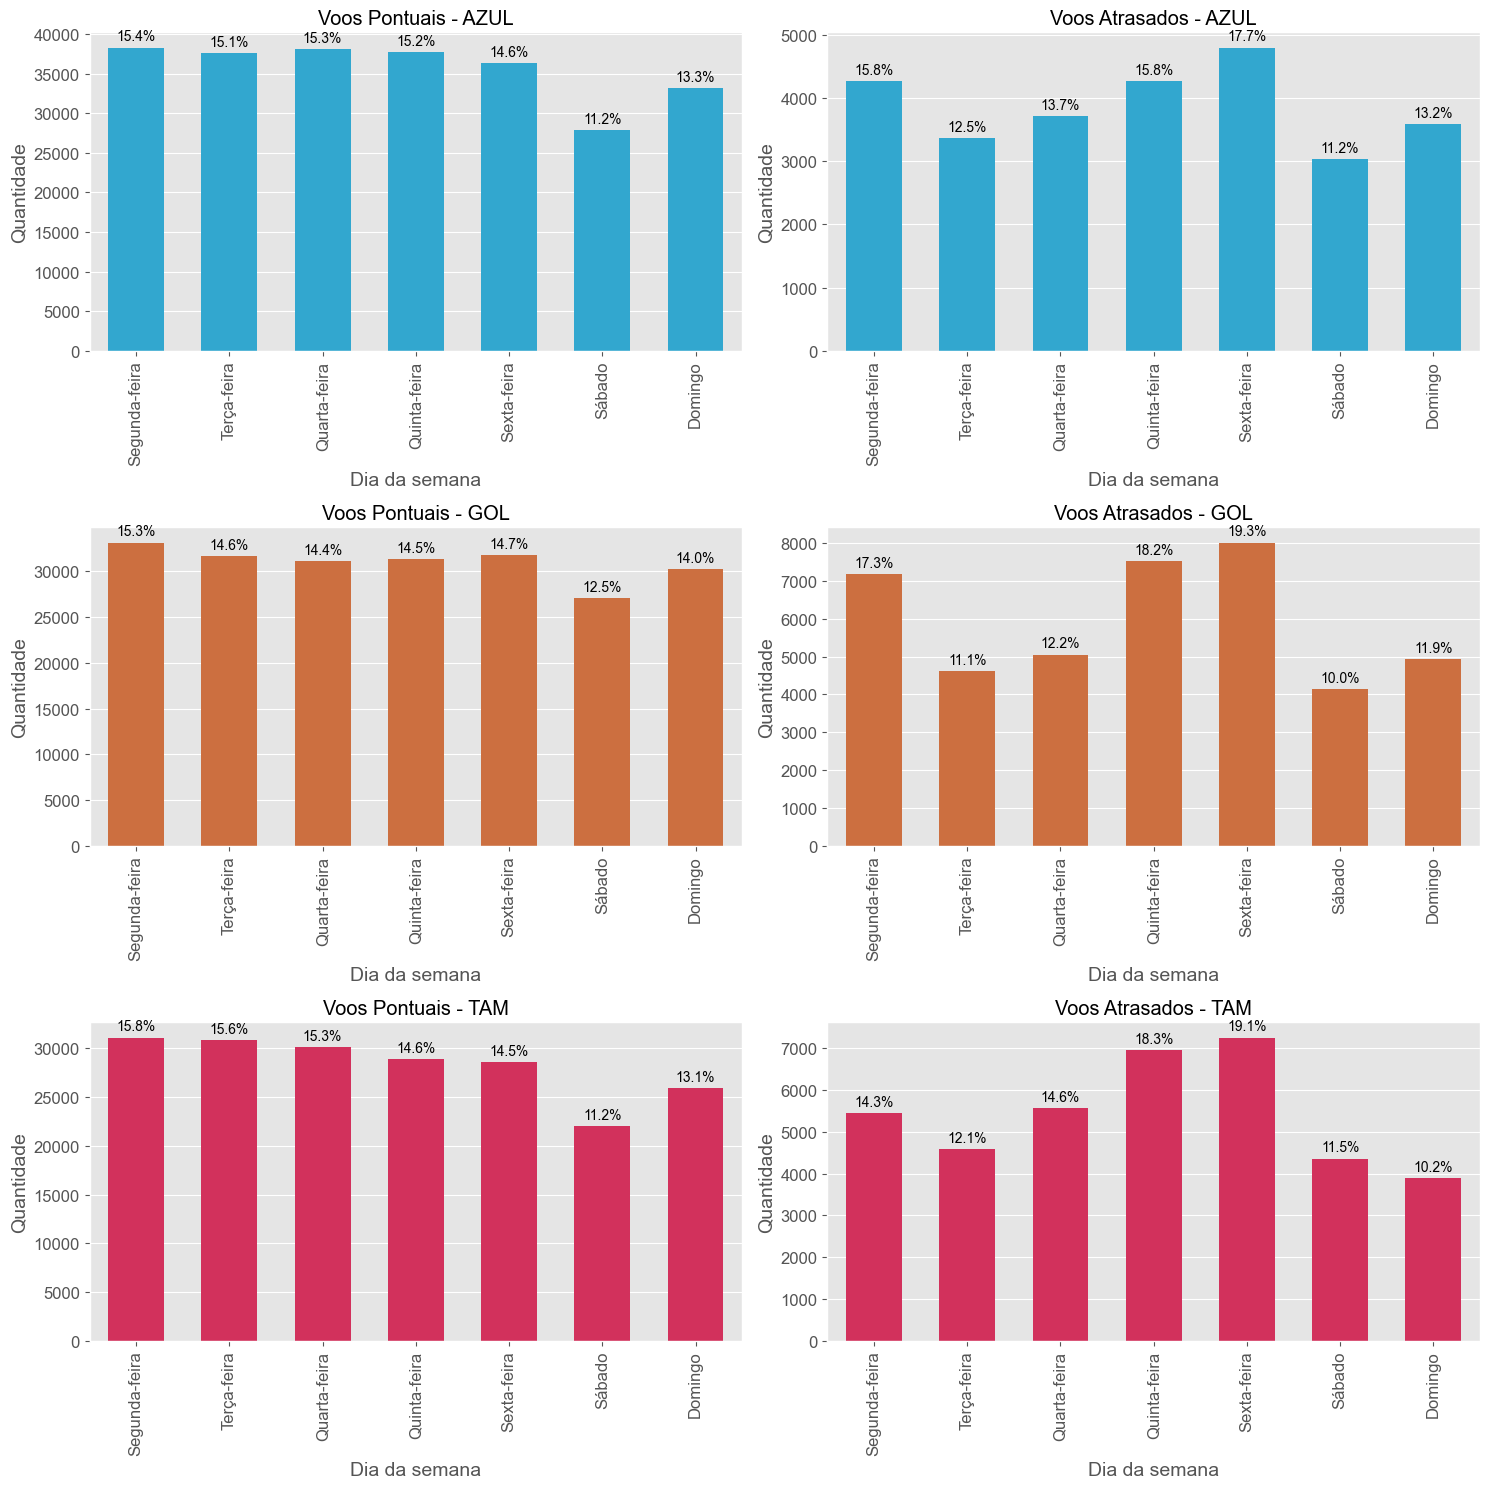

In [45]:
# Análise Visual da Distribuição de Voos Pontuais e Atrasados por Dia da Semana para Cada Empresa Aérea.

# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Filtrando o DataFrame para separar voos pontuais e atrasados.
voos_pontual = df[df['status_do_voo'] == 'Pontual']
voos_atrasado = df[df['status_do_voo'] == 'Atrasado']

# Mapeando e ordenando os dias da semana.
mapeamento_dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
dias_ordenados = list(mapeamento_dias.values())

# Definindo a ordem específica das empresas aéreas para análise.
ordem = ['AZUL','GOL', 'TAM']

# Configurando um ambiente de plotagem com subgráficos para cada empresa e status do voo.
fig, axes = plt.subplots(len(ordem), 2, figsize=(15, 5 * len(ordem)))

# Criando um gráfico de barras para cada empresa aérea, tanto para voos pontuais quanto para atrasados.
for i, empresa in enumerate(ordem):
    cor_empresa = cores_empresas.get(empresa, '#969696')  # Cor padrão se a empresa não estiver no dicionário.

    # Gráfico para voos pontuais da empresa.
    df_pontual_empresa = voos_pontual[voos_pontual['nome_empresas'] == empresa]
    df_pontual_agrupado = df_pontual_empresa.groupby('dia_semana_partida').size().reset_index(name='quantidade')
    ax_pontual = sns.barplot(x='dia_semana_partida', y='quantidade', data=df_pontual_agrupado, order=dias_ordenados, ax=axes[i, 0], color=cor_empresa)
    axes[i, 0].set_title(f'Voos Pontuais - {empresa}')
    axes[i, 0].set_xlabel('Dia da semana', fontsize=14)
    axes[i, 0].set_ylabel('Quantidade', fontsize=14)
    change_width_x(ax_pontual, 0.6)
    add_annotations_percentage_x(ax_pontual, df_pontual_agrupado['quantidade'].sum())

    # Gráfico para voos atrasados da empresa.
    df_atrasado_empresa = voos_atrasado[voos_atrasado['nome_empresas'] == empresa]
    df_atrasado_agrupado = df_atrasado_empresa.groupby('dia_semana_partida').size().reset_index(name='quantidade')
    ax_atrasado = sns.barplot(x='dia_semana_partida', y='quantidade', data=df_atrasado_agrupado, order=dias_ordenados, ax=axes[i, 1], color=cor_empresa)
    axes[i, 1].set_title(f'Voos Atrasados - {empresa}')
    axes[i, 1].set_xlabel('Dia da semana', fontsize=14)
    axes[i, 1].set_ylabel('Quantidade', fontsize=14)
    change_width_x(ax_atrasado, 0.6)
    add_annotations_percentage_x(ax_atrasado, df_atrasado_agrupado['quantidade'].sum())

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte para todos os gráficos.
for ax in axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.tick_params(axis='both', labelsize=12)

# Ajustando o layout e exibindo os gráficos.
plt.tight_layout()
plt.show()


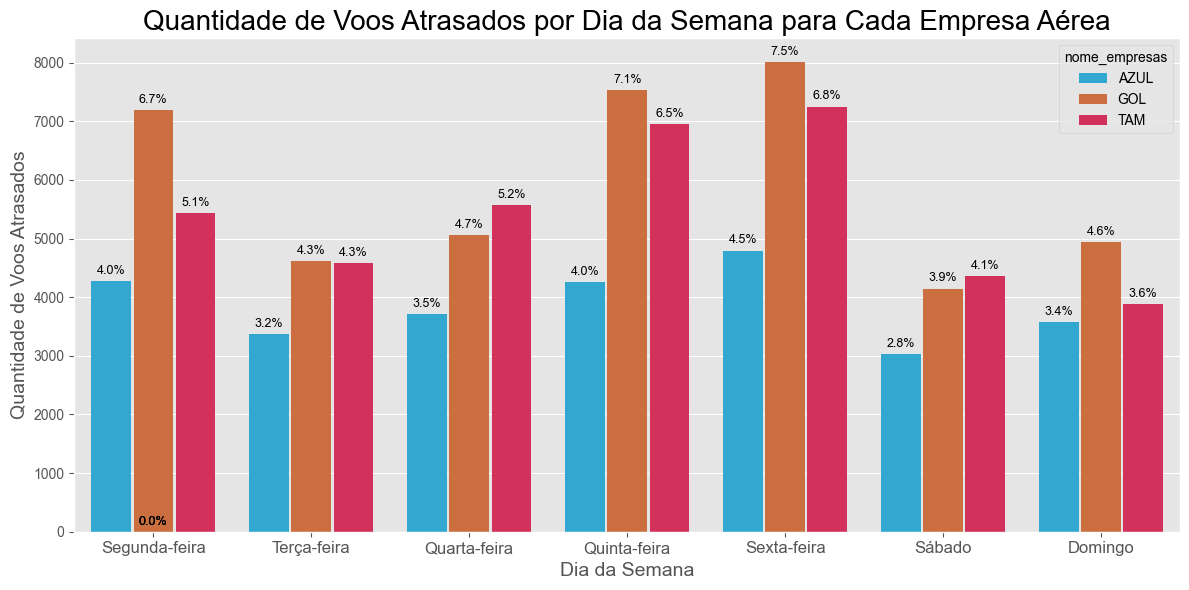

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supondo que 'df' seja o seu DataFrame original.

# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Filtrando o DataFrame para incluir apenas voos atrasados.
df_atrasados = df[df['status_do_voo'] == 'Atrasado']

# Mapeando os dias da semana para nomes correspondentes.
mapeamento_dias = {
    0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 
    4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'
}

# Ordenando os dias da semana para garantir a consistência nos gráficos.
dias_semana_ordenados = list(mapeamento_dias.values())

# Agrupando os dados por nome da empresa e dia da semana da partida, contando a quantidade de voos atrasados.
df_agrupado = df_atrasados.groupby(['nome_empresas', 'dia_semana_partida']).size().reset_index(name='quantidade')

# Criando um único gráfico de barras com hue para as empresas aéreas
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='dia_semana_partida',
    y='quantidade',
    hue='nome_empresas',
    data=df_agrupado,
    order=dias_semana_ordenados,
    palette=cores_empresas
)

# Definindo títulos e rótulos do gráfico.
plt.title('Quantidade de Voos Atrasados por Dia da Semana para Cada Empresa Aérea', fontsize=20)
plt.xlabel('Dia da Semana', fontsize=14)
plt.ylabel('Quantidade de Voos Atrasados', fontsize=14)
plt.xticks(rotation=0, fontsize=12)

# Ajustando o layout e exibindo o
change_width_x(ax, new_value=0.25)
total_count = df_agrupado['quantidade'].sum()
add_annotations_percentage_x(ax, total_count, size=9)

# Ajustando o layout e exibindo o gráfico.
plt.tight_layout()
plt.show()


### Distribuição dos meses com mais voo atrasados

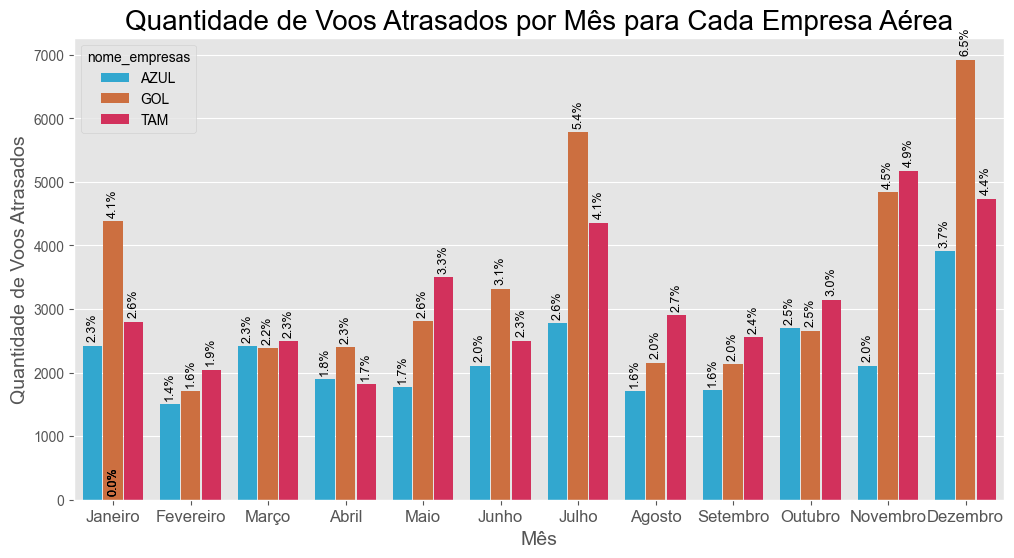

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Filtrando o DataFrame para incluir apenas voos atrasados.
df_atrasados = df[df['status_do_voo'] == 'Atrasado']

# Mapeando os números dos meses para os nomes correspondentes.
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

# Ordenando os meses para garantir a consistência nos gráficos.
meses_ordenados = list(mapeamento_meses.values())

# Agrupando os dados por nome da empresa e mês da partida, contando a quantidade de voos atrasados.
df_agrupado = df_atrasados.groupby(['nome_empresas', 'mes_partida']).size().reset_index(name='quantidade')

# Criando um único gráfico de barras com hue para as empresas aéreas
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='mes_partida',
    y='quantidade',
    hue='nome_empresas',
    data=df_agrupado,
    order=meses_ordenados,
    palette=cores_empresas
)

# Definindo títulos e rótulos do gráfico.
plt.title('Quantidade de Voos Atrasados por Mês para Cada Empresa Aérea', fontsize=20)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Quantidade de Voos Atrasados', fontsize=14)
plt.xticks(rotation=0, fontsize=12)

# Opcional: Alterando a largura das barras (se necessário) e adicionando anotações de porcentagem
# change_width_x(ax, new_value=0.6) # Se essa função estiver definida no seu código
# add_annotations_percentage_x(ax) # Se essa função estiver definida no seu código

# Ajustando o layout e exibindo o
change_width_x(ax, new_value=0.25)
total_count = df_agrupado['quantidade'].sum()
add_annotations_percentage_x(ax, total_count, size=9, rotation=90)

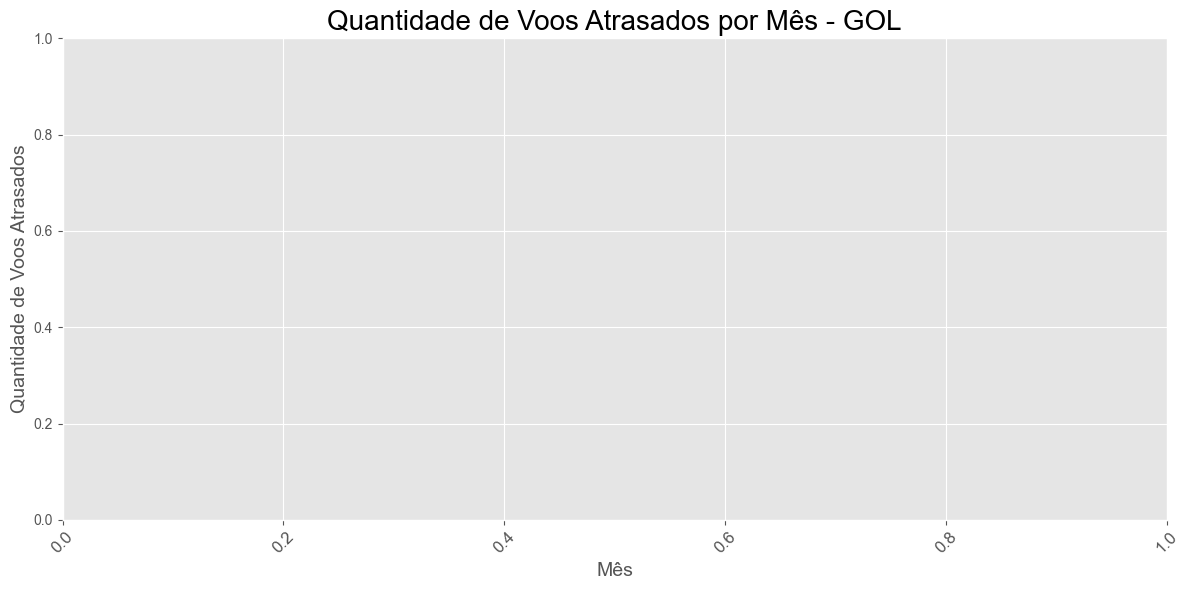

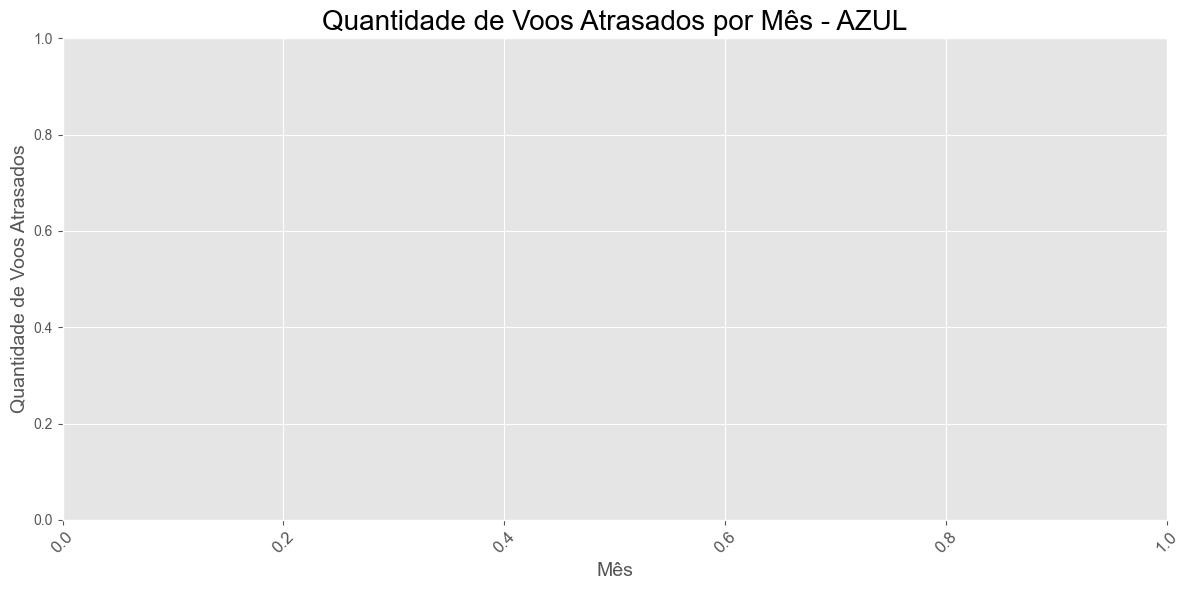

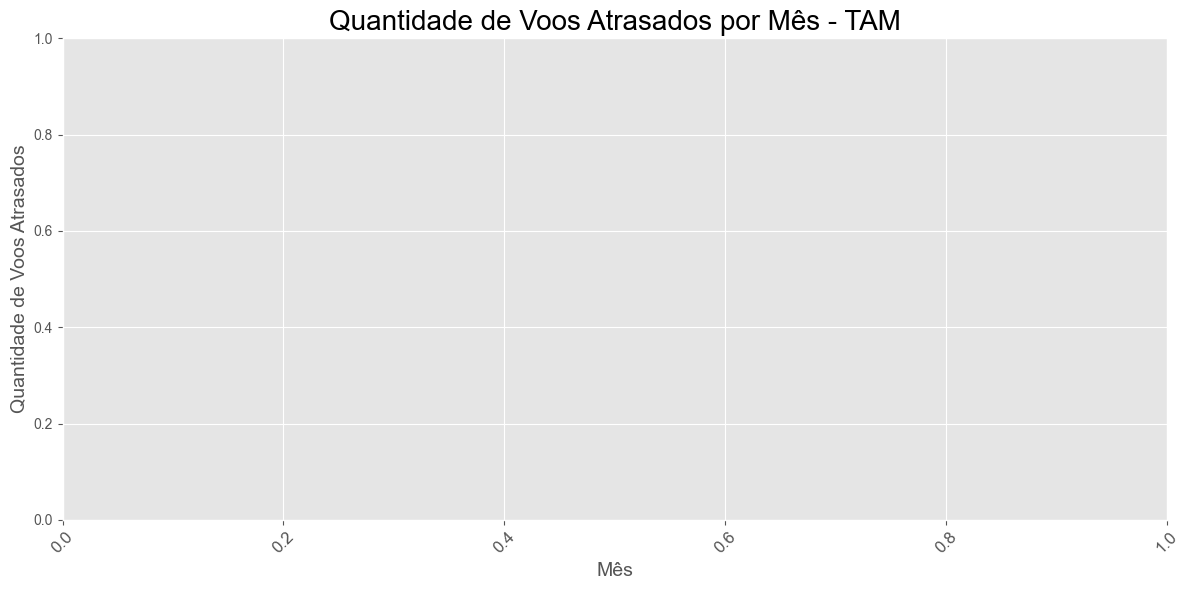

In [49]:
# Análise Visual da Quantidade de Voos Atrasados por Mês para Cada Empresa Aérea.

# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Filtrando o DataFrame para incluir apenas voos atrasados.
df_atrasados = df[df['status_do_voo'] == 'Atrasado']

# Mapeando os números dos meses para os nomes correspondentes.
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
df_atrasados['mes_partida'] = df_atrasados['mes_partida'].map(mapeamento_meses)

# Ordenando os meses para garantir a consistência nos gráficos.
meses_ordenados = list(mapeamento_meses.values())

# Agrupando os dados por nome da empresa e mês da partida, contando a quantidade de voos atrasados.
df_agrupado = df_atrasados.groupby(['nome_empresas', 'mes_partida']).size().reset_index(name='quantidade')

# Definindo a ordem específica das empresas aéreas para análise.
ordem_empresas = ['AZUL','GOL', 'TAM']

# Criando um gráfico de barras para cada empresa aérea.
for empresa in ordem_empresas:
    # Filtrando os dados para a empresa atual e preparando o gráfico.
    df_empresa = df_agrupado[df_agrupado['nome_empresas'] == empresa]
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='mes_partida', y='quantidade', data=df_empresa, order=meses_ordenados, color=cores_empresas[empresa])

    # Definindo títulos e rótulos do gráfico.
    plt.title(f'Quantidade de Voos Atrasados por Mês - {empresa}', fontsize=20)
    plt.xlabel('Mês', fontsize=14)
    plt.ylabel('Quantidade de Voos Atrasados', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)

    # Alterando a largura das barras e adicionando anotações de porcentagem.
    change_width_x(ax, new_value=0.6)
    total_count = df_empresa['quantidade'].sum()
    add_annotations_percentage_x(ax, total_count)

    # Ajustando o layout e exibindo o gráfico.
    plt.tight_layout()
    plt.show()


### Rotas com Atraso

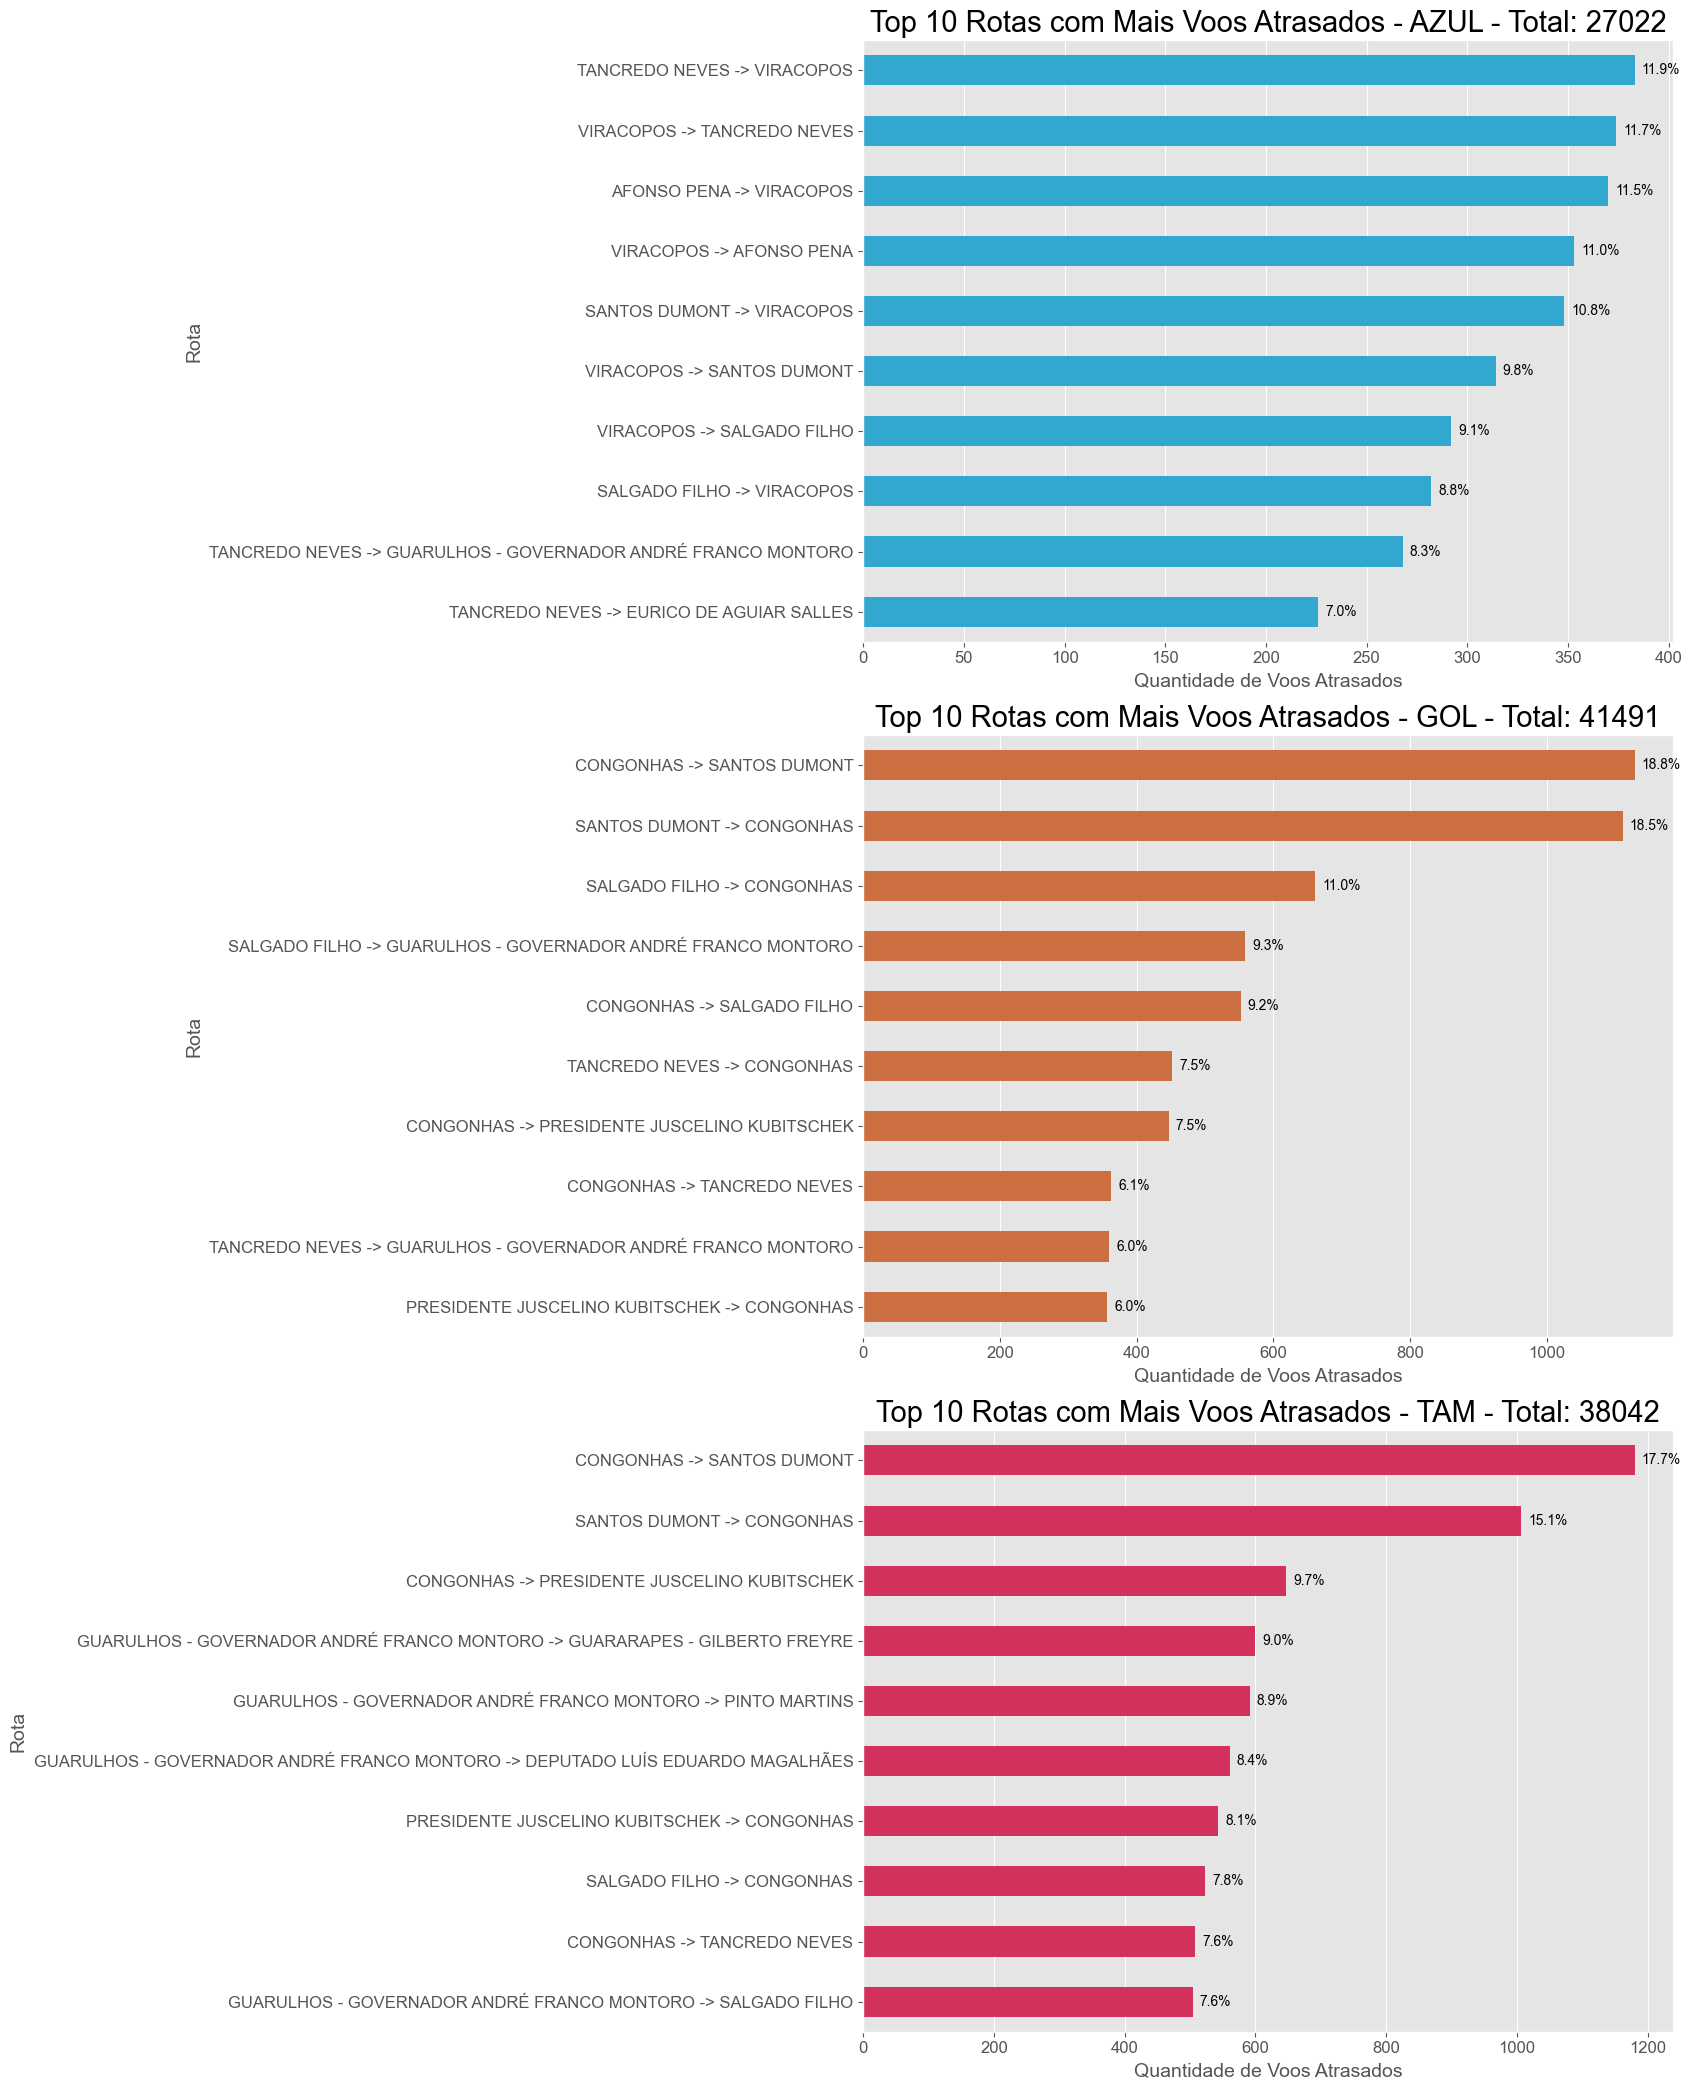

In [51]:
# Análise Visual das Rotas Mais Afetadas por Atrasos de Voos para Cada Empresa Aérea.

# Filtrando o DataFrame para incluir apenas voos atrasados.
df_atrasados = df[df['status_do_voo'] == 'Atrasado']

# Agrupando os dados por nome da empresa e rota, contando a quantidade de voos atrasados.
df_agrupado = df_atrasados.groupby(['nome_empresas', 'rota']).size().reset_index(name='quantidade')

# Calculando o total de atrasos por companhia aérea.
df_total_atraso = df_atrasados.groupby(['nome_empresas']).size().reset_index(name='quantidade')

# Definindo a paleta de cores para as empresas aéreas.
cores_empresas = {'AZUL': '#18B4E9','GOL': '#E36729',  'TAM': '#ED1650'}

# Selecionando as principais empresas aéreas para análise.
empresas_selecionadas = list(cores_empresas.keys())

# Configurando um ambiente de plotagem com subgráficos para cada empresa.
fig, axes = plt.subplots(len(empresas_selecionadas), 1, figsize=(17, 7 * len(empresas_selecionadas)))

# Criando um gráfico de barras para cada empresa aérea.
for i, empresa in enumerate(empresas_selecionadas):
    # Filtrando os dados para a empresa atual e selecionando as top 10 rotas com mais atrasos.
    df_empresa = df_agrupado[df_agrupado['nome_empresas'] == empresa]
    df_top_rotas = df_empresa.nlargest(10, 'quantidade')

    # Criando o gráfico de barras para as rotas com mais atrasos.
    sns.barplot(x='quantidade', y='rota', data=df_top_rotas, ax=axes[i], color=cores_empresas[empresa])

    # Ajustando a altura das barras e os rótulos do eixo y.
    change_width_y(axes[i], 0.5)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=12)

    # Definindo títulos e rótulos do gráfico.
    total_atrasos_empresa = df_total_atraso[df_total_atraso['nome_empresas'] == empresa]['quantidade'].iloc[0]
    axes[i].set_title(f'Top 10 Rotas com Mais Voos Atrasados - {empresa} - Total: {total_atrasos_empresa}', fontsize=21)
    axes[i].set_xlabel('Quantidade de Voos Atrasados', fontsize=14)
    axes[i].set_ylabel('Rota', fontsize=14)

    # Adicionando anotações de porcentagem sobre as barras.
    total_atrasos = df_top_rotas['quantidade'].sum()
    add_annotations_percentage_y(axes[i], total_atrasos, size=10)

# Ajustando o layout para evitar sobreposição de elementos e exibindo os gráficos.
plt.tight_layout()
plt.show()


# Indicador de Pontualidade

## Cia. Aérea 

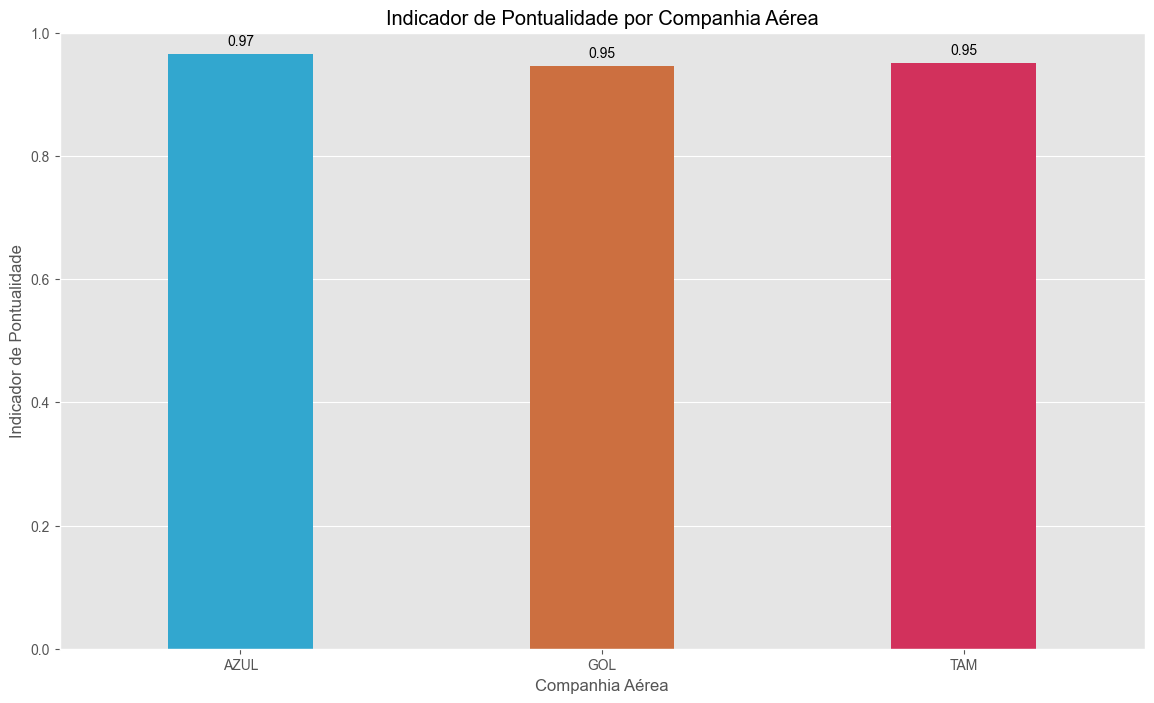

In [52]:
# Recálculo e Visualização do Indicador de Pontualidade para Companhias Aéreas.

# Agrupando os voos por companhia aérea e status do voo, preenchendo valores ausentes com zero.
voos_por_companhia = df.groupby('nome_empresas')['status_do_voo'].value_counts().unstack(fill_value=0)

# Calculando o indicador de pontualidade para cada companhia aérea.
# O indicador é definido como 1 menos a proporção de voos atrasados em relação ao total de voos.
voos_por_companhia['Indicador_Pontualidade'] = 1 - (voos_por_companhia.get('Atrasado', 0) / df['status_do_voo'].count())

# Definindo manualmente a ordem desejada para as companhias aéreas.
ordem_desejada = ['AZUL','GOL', 'TAM']

# Convertendo 'nome_empresas' de índice para coluna após o agrupamento e desempilhamento.
voos_por_companhia.reset_index(inplace=True)

# Reordenando o DataFrame de acordo com a ordem desejada (GOL, AZUL, TAM).
voos_por_companhia_manual = voos_por_companhia.set_index('nome_empresas').loc[ordem_desejada].reset_index()

# Atualizando as cores para as companhias aéreas de acordo com a nova ordem.
colors_manual = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Criando um gráfico de barras para o indicador de pontualidade de cada companhia aérea.
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='nome_empresas', y='Indicador_Pontualidade', data=voos_por_companhia_manual, palette=colors_manual)
plt.title('Indicador de Pontualidade por Companhia Aérea')
plt.ylabel('Indicador de Pontualidade')
plt.xlabel('Companhia Aérea')
plt.ylim(0, 1)  # O indicador de pontualidade varia de 0 a 1.

# Adicionando anotações de porcentagem sobre as barras do gráfico.
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
    
# Ajustando a largura das barras.
change_width_x(ax, new_value=0.4)

# Exibindo o gráfico.
plt.show()


## Indicador de pontualidade mês a mês cia aérea

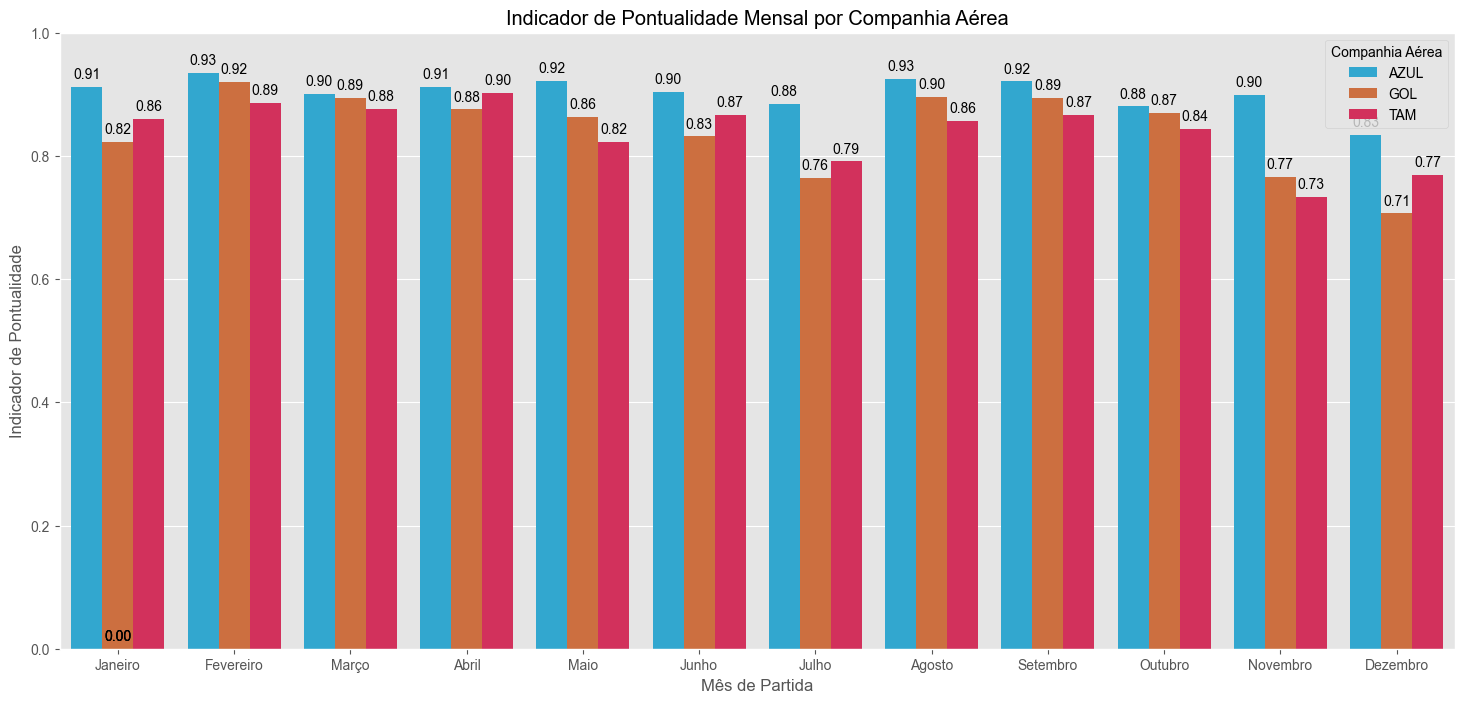

In [53]:
# Agrupar por mês e nome da empresa, e calcular o total de voos e voos atrasados.
total_voos_por_mes = df.groupby(['mes_partida', 'nome_empresas']).size().reset_index(name='total_voos')
atrasos_por_mes = df[df['status_do_voo'] == 'Atrasado'].groupby(['mes_partida', 'nome_empresas']).size().reset_index(name='voos_atrasados')
df_agrupado = pd.merge(total_voos_por_mes, atrasos_por_mes, on=['mes_partida', 'nome_empresas'])

# Calculando o indicador de pontualidade para cada grupo.
df_agrupado['Indicador_Pontualidade'] = 1 - (df_agrupado['voos_atrasados'] / df_agrupado['total_voos'])

# Preparando a paleta de cores para cada empresa.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Ordenando as empresas e meses manualmente.
ordem_desejada = ['AZUL','GOL', 'TAM']
ordem_meses = list(mapeamento_meses.values())
df_agrupado['mes_partida'] = pd.Categorical(df_agrupado['mes_partida'], categories=ordem_meses, ordered=True)
df_agrupado['nome_empresas'] = pd.Categorical(df_agrupado['nome_empresas'], categories=ordem_desejada, ordered=True)

# Criando o gráfico com a ordem desejada de empresas e meses.
plt.figure(figsize=(18, 8))
ax = sns.barplot(x='mes_partida', y='Indicador_Pontualidade', hue='nome_empresas', data=df_agrupado, palette=cores_empresas)
plt.title('Indicador de Pontualidade Mensal por Companhia Aérea')
plt.ylabel('Indicador de Pontualidade')
plt.xlabel('Mês de Partida')
plt.ylim(0, 1)

# Adicionando anotações de porcentagem.
for p in ax.patches:
    height = p.get_height()
    ax.annotate(format(height, '.2f'), 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.legend(title='Companhia Aérea')
plt.show()

## Indicador de pontualidade por dia da semana e cia aérea

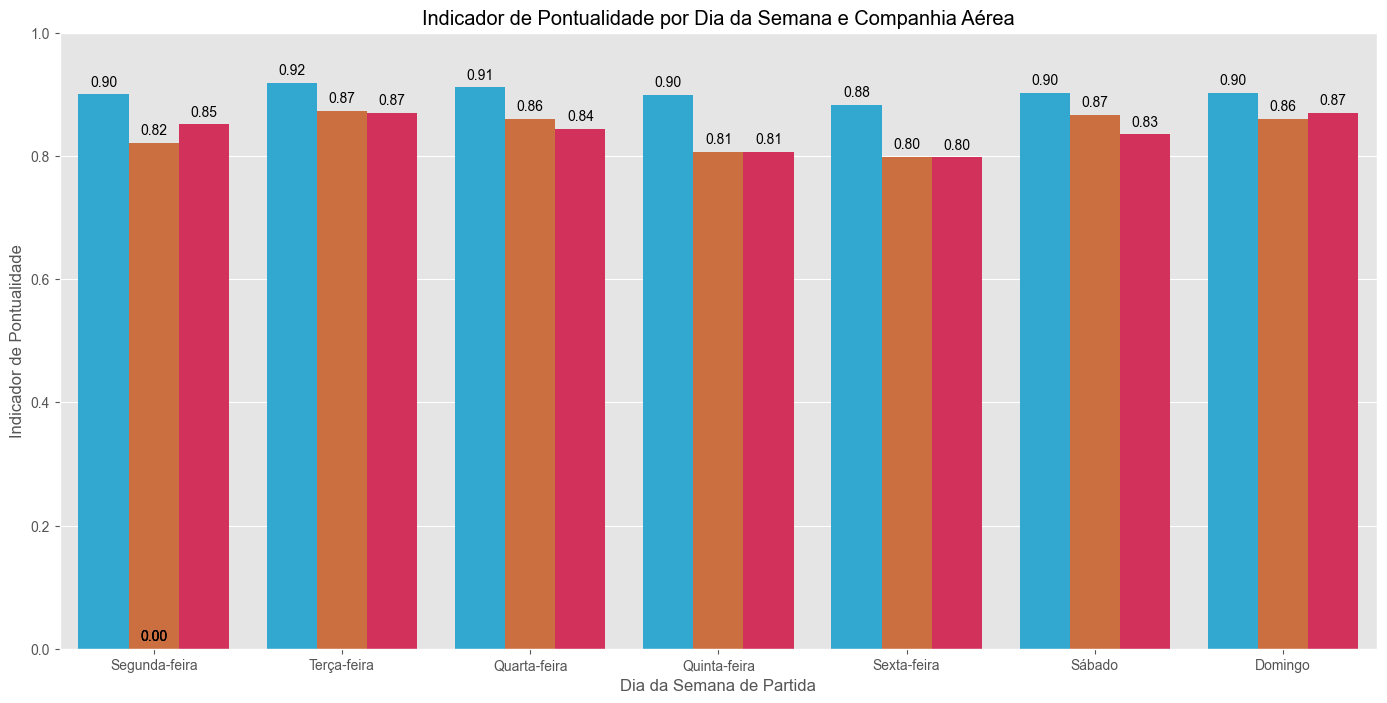

In [54]:
# Agrupar por dia da semana e nome da empresa, e calcular o total de voos e voos atrasados.
total_voos_por_dia = df.groupby(['dia_semana_partida', 'nome_empresas']).size().reset_index(name='total_voos')
atrasos_por_dia = df[df['status_do_voo'] == 'Atrasado'].groupby(['dia_semana_partida', 'nome_empresas']).size().reset_index(name='voos_atrasados')
df_agrupado = pd.merge(total_voos_por_dia, atrasos_por_dia, on=['dia_semana_partida', 'nome_empresas'])

# Calculando o indicador de pontualidade para cada grupo.
df_agrupado['Indicador_Pontualidade'] = 1 - (df_agrupado['voos_atrasados'] / df_agrupado['total_voos'])

# Preparando a paleta de cores para cada empresa.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Ordenando as empresas e dias da semana manualmente.
ordem_desejada = ['AZUL','GOL', 'TAM']
ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_agrupado['dia_semana_partida'] = pd.Categorical(df_agrupado['dia_semana_partida'], categories=ordem_dias, ordered=True)
df_agrupado['nome_empresas'] = pd.Categorical(df_agrupado['nome_empresas'], categories=ordem_desejada, ordered=True)

# Criando o gráfico com a ordem desejada de empresas e dias da semana.
plt.figure(figsize=(17, 8))
ax = sns.barplot(x='dia_semana_partida', y='Indicador_Pontualidade', hue='nome_empresas', data=df_agrupado, palette=cores_empresas)
plt.title('Indicador de Pontualidade por Dia da Semana e Companhia Aérea')
plt.ylabel('Indicador de Pontualidade')
plt.xlabel('Dia da Semana de Partida')
plt.ylim(0, 1)

# Adicionando anotações de porcentagem.
for p in ax.patches:
    height = p.get_height()
    ax.annotate(format(height, '.2f'), 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.legend(title='Companhia Aérea')
plt.legend().set_visible(False)
plt.show()

### Indicador de pontualidade vs aeroportos, cidades e temporal

In [31]:
# Calculando os indicadores de pontualidade
def calcular_indicador_pontualidade(df, coluna):
    grupo = df.groupby(coluna)['status_do_voo'].value_counts().unstack(fill_value=0)
    grupo['Indicador_Pontualidade'] = 1 - (grupo.get('Atrasado', 0) / grupo.sum(axis=1))
    grupo.reset_index(inplace=True)
    return grupo

# Preparando os DataFrames para os gráficos
df_nome_empresas = calcular_indicador_pontualidade(df, 'nome_empresas')

df_cidade_origem = calcular_indicador_pontualidade(df, 'cidade_origem')
df_cidade_origem_10_nsmallest = df_cidade_origem[(df_cidade_origem['Atrasado']+df_cidade_origem['Pontual']>=750)].nsmallest(15, 'Indicador_Pontualidade')
df_cidade_origem_10_nlargest = df_cidade_origem[(df_cidade_origem['Atrasado']+df_cidade_origem['Pontual']>=750)].nlargest(15, 'Indicador_Pontualidade')

df_cidade_brasil = calcular_indicador_pontualidade(df[(df['pais_origem']== 'BRASIL')], 'cidade_origem')
df_cidade_brasil_10_nsmallest = df_cidade_brasil[(df_cidade_brasil['Atrasado']+df_cidade_brasil['Pontual']>=750)].nsmallest(15, 'Indicador_Pontualidade')
df_cidade_brasil_10_10_nlargest = df_cidade_brasil[(df_cidade_brasil['Atrasado']+df_cidade_brasil['Pontual']>=750)].nlargest(15, 'Indicador_Pontualidade')

df_dia_mes = calcular_indicador_pontualidade(df, 'dia_mes_partida')
df_dia_semana = calcular_indicador_pontualidade(df, 'dia_semana_chegada')
df_mes_chegada = calcular_indicador_pontualidade(df, 'mes_chegada')

df_uf = calcular_indicador_pontualidade(df, 'uf_origem')
df_uf_10_nsmallest = df_uf.nsmallest(10, 'Indicador_Pontualidade')

df_aeroporto_origem = calcular_indicador_pontualidade(df, 'descricao_origem')
df_aeroporto_origem_10_nsmallest = df_aeroporto_origem[(df_aeroporto_origem['Atrasado']+df_aeroporto_origem['Pontual']>=750)].nsmallest(15, 'Indicador_Pontualidade')
df_aeroporto_origem_10_nlargest = df_aeroporto_origem[(df_aeroporto_origem['Atrasado']+df_aeroporto_origem['Pontual']>=750)].nlargest(15, 'Indicador_Pontualidade')

df_aeroporto_origem_brasil = calcular_indicador_pontualidade(df[(df['pais_origem']== 'BRASIL')], 'descricao_origem')
df_aeroporto_origem_brasil_10_nsmallest = df_aeroporto_origem_brasil[(df_aeroporto_origem_brasil['Atrasado']+df_aeroporto_origem_brasil['Pontual']>=750)].nsmallest(15, 'Indicador_Pontualidade')
df_aeroporto_origem_brasil_10_nlargest = df_aeroporto_origem_brasil[(df_aeroporto_origem_brasil['Atrasado']+df_aeroporto_origem_brasil['Pontual']>=750)].nlargest(15, 'Indicador_Pontualidade')

df_rota_brasil = calcular_indicador_pontualidade(df[(df['pais_origem']== 'BRASIL')], 'rota')
df_rota_brasil_10_nsmallest = df_rota_brasil[(df_rota_brasil['Atrasado']+df_rota_brasil['Pontual']>=750)].nsmallest(15, 'Indicador_Pontualidade')
df_rota_brasil_10_nlargest = df_rota_brasil[(df_rota_brasil['Atrasado']+df_rota_brasil['Pontual']>=750)].nlargest(15, 'Indicador_Pontualidade')


### Cidades origem e indicador de pontualidade

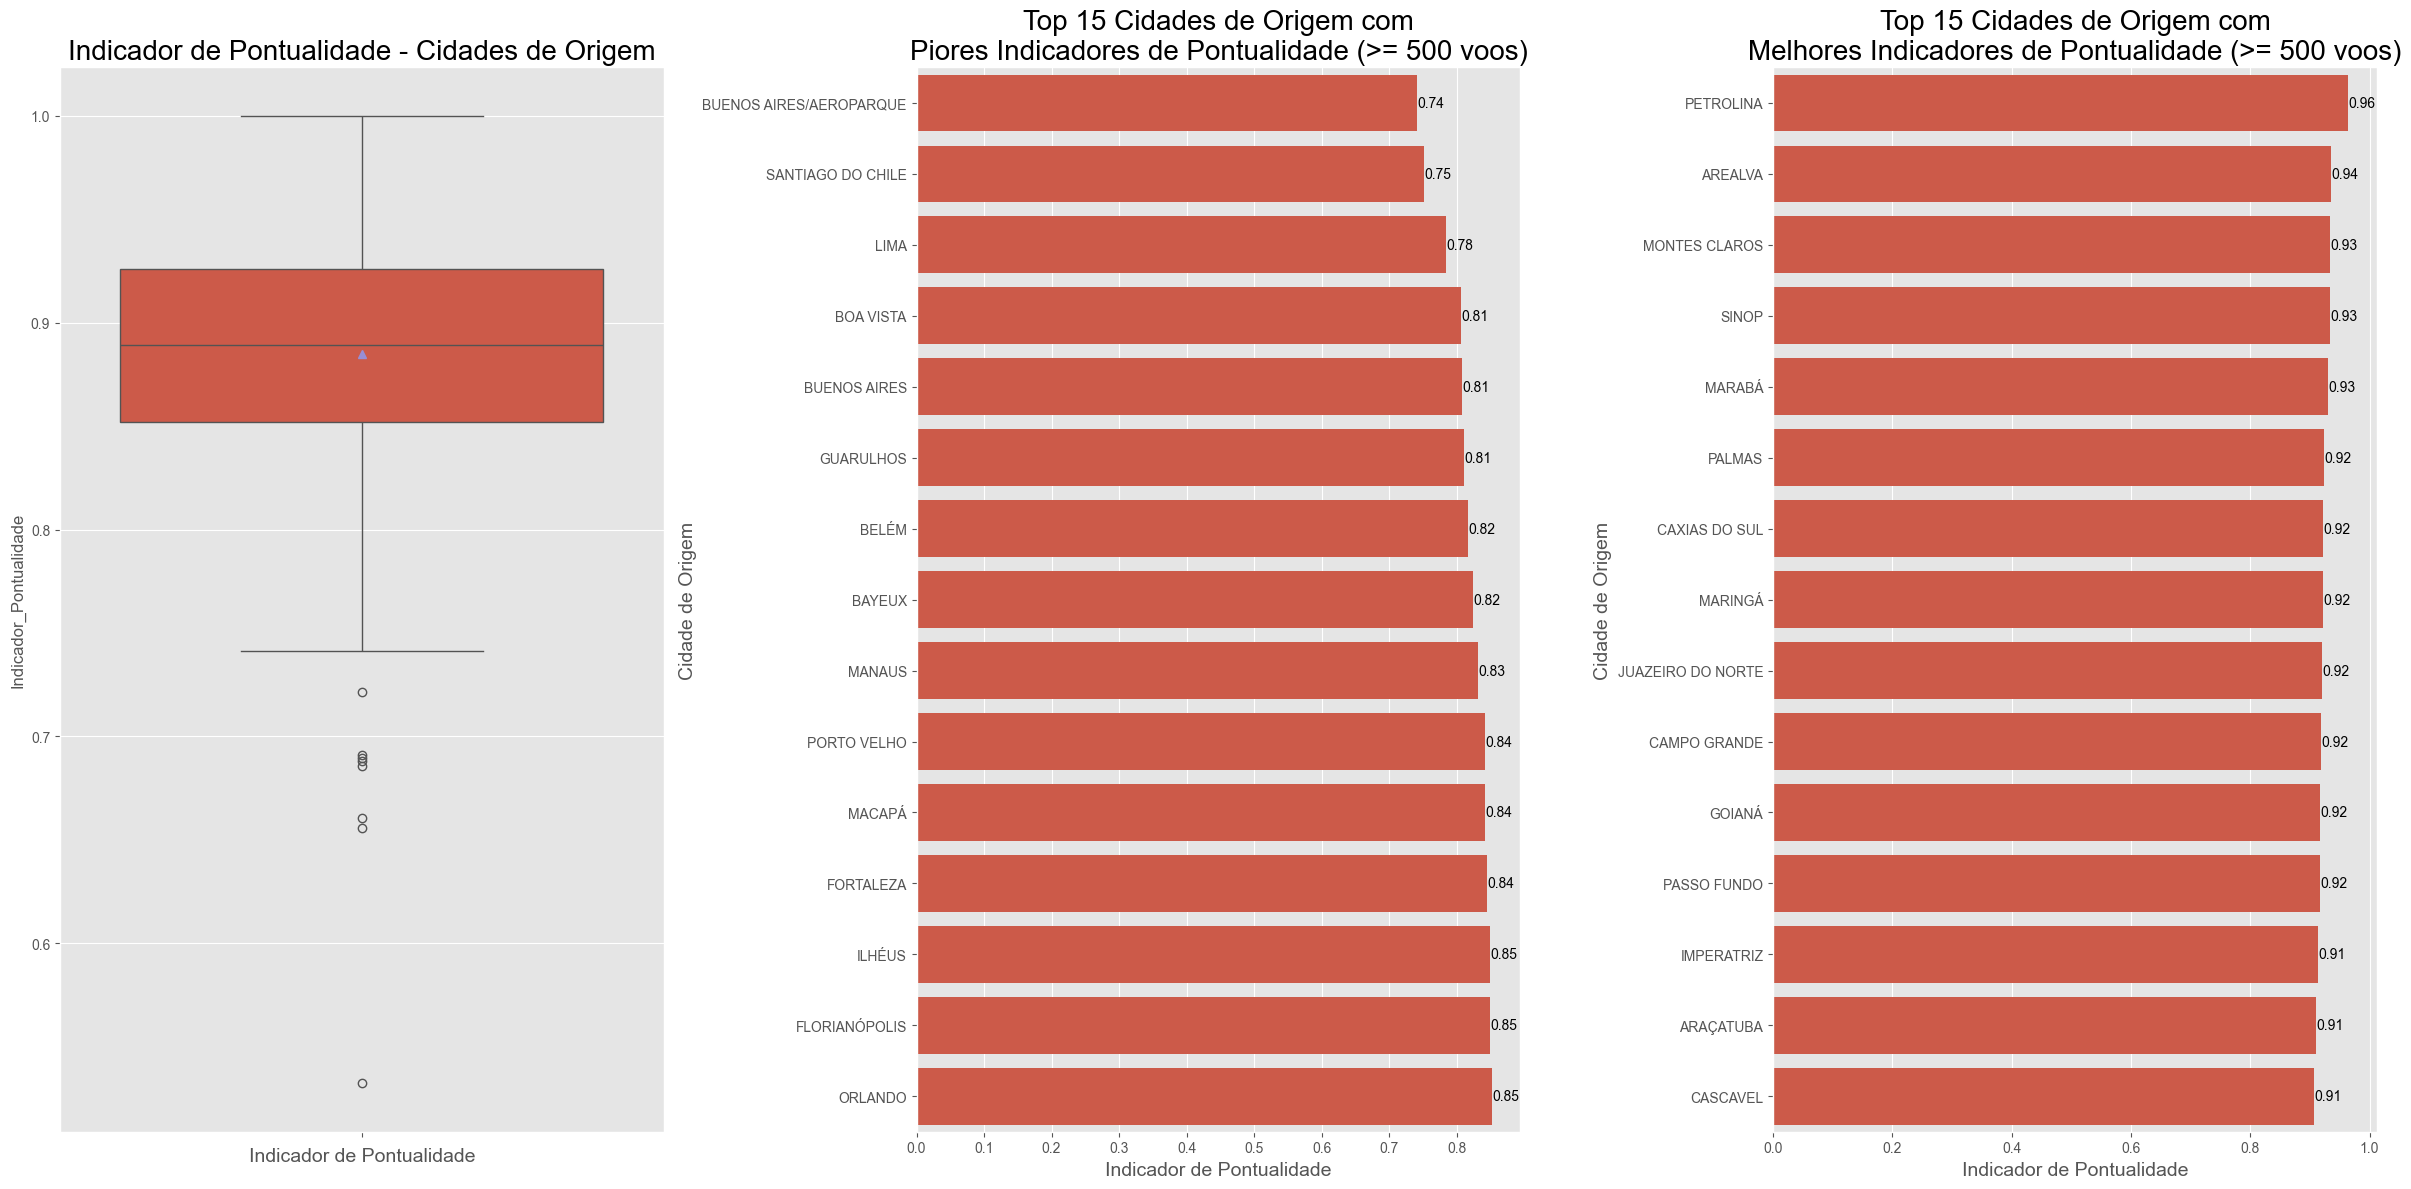

In [32]:
# Criação de Subplots para Análise do Indicador de Pontualidade por Cidades de Origem.

# Configurando um ambiente de plotagem com três subgráficos.
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

# Boxplot para indicador de pontualidade de todas as cidades de origem.
# Mostra a distribuição do indicador de pontualidade com a média.
sns.boxplot(y='Indicador_Pontualidade', data=df_cidade_origem, ax=axes[0], showmeans=True)
axes[0].set_title('Indicador de Pontualidade - Cidades de Origem', fontsize=20)
axes[0].set_xlabel('Indicador de Pontualidade', fontsize=14)

# Gráfico de barras para as 10 cidades de origem com os piores indicadores de pontualidade.
# Mostra as cidades com os menores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='cidade_origem', data=df_cidade_origem_10_nsmallest, ax=axes[1])
axes[1].set_title('Top 15 Cidades de Origem com\nPiores Indicadores de Pontualidade (>= 500 voos)', fontsize=20)
axes[1].set_xlabel('Indicador de Pontualidade', fontsize=14)
axes[1].set_ylabel('Cidade de Origem', fontsize=14)

# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico das piores cidades.
for i, p in enumerate(axes[1].patches):
    axes[1].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(10, 0), textcoords='offset points')

# Gráfico de barras para as 10 cidades de origem com os melhores indicadores de pontualidade.
# Mostra as cidades com os maiores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='cidade_origem', data=df_cidade_origem_10_nlargest, ax=axes[2])
axes[2].set_title('Top 15 Cidades de Origem com\nMelhores Indicadores de Pontualidade (>= 500 voos)', fontsize=20)
axes[2].set_xlabel('Indicador de Pontualidade', fontsize=14)
axes[2].set_ylabel('Cidade de Origem', fontsize=14)

# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico das melhores cidades.
for i, p in enumerate(axes[2].patches):
    axes[2].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(10, 0), textcoords='offset points')

# Ajustando o layout para evitar sobreposição de elementos e melhorar a visualização.
plt.tight_layout()

# Exibindo os gráficos.
plt.show()


### Cidades origem no brasil e indicador de pontualidade

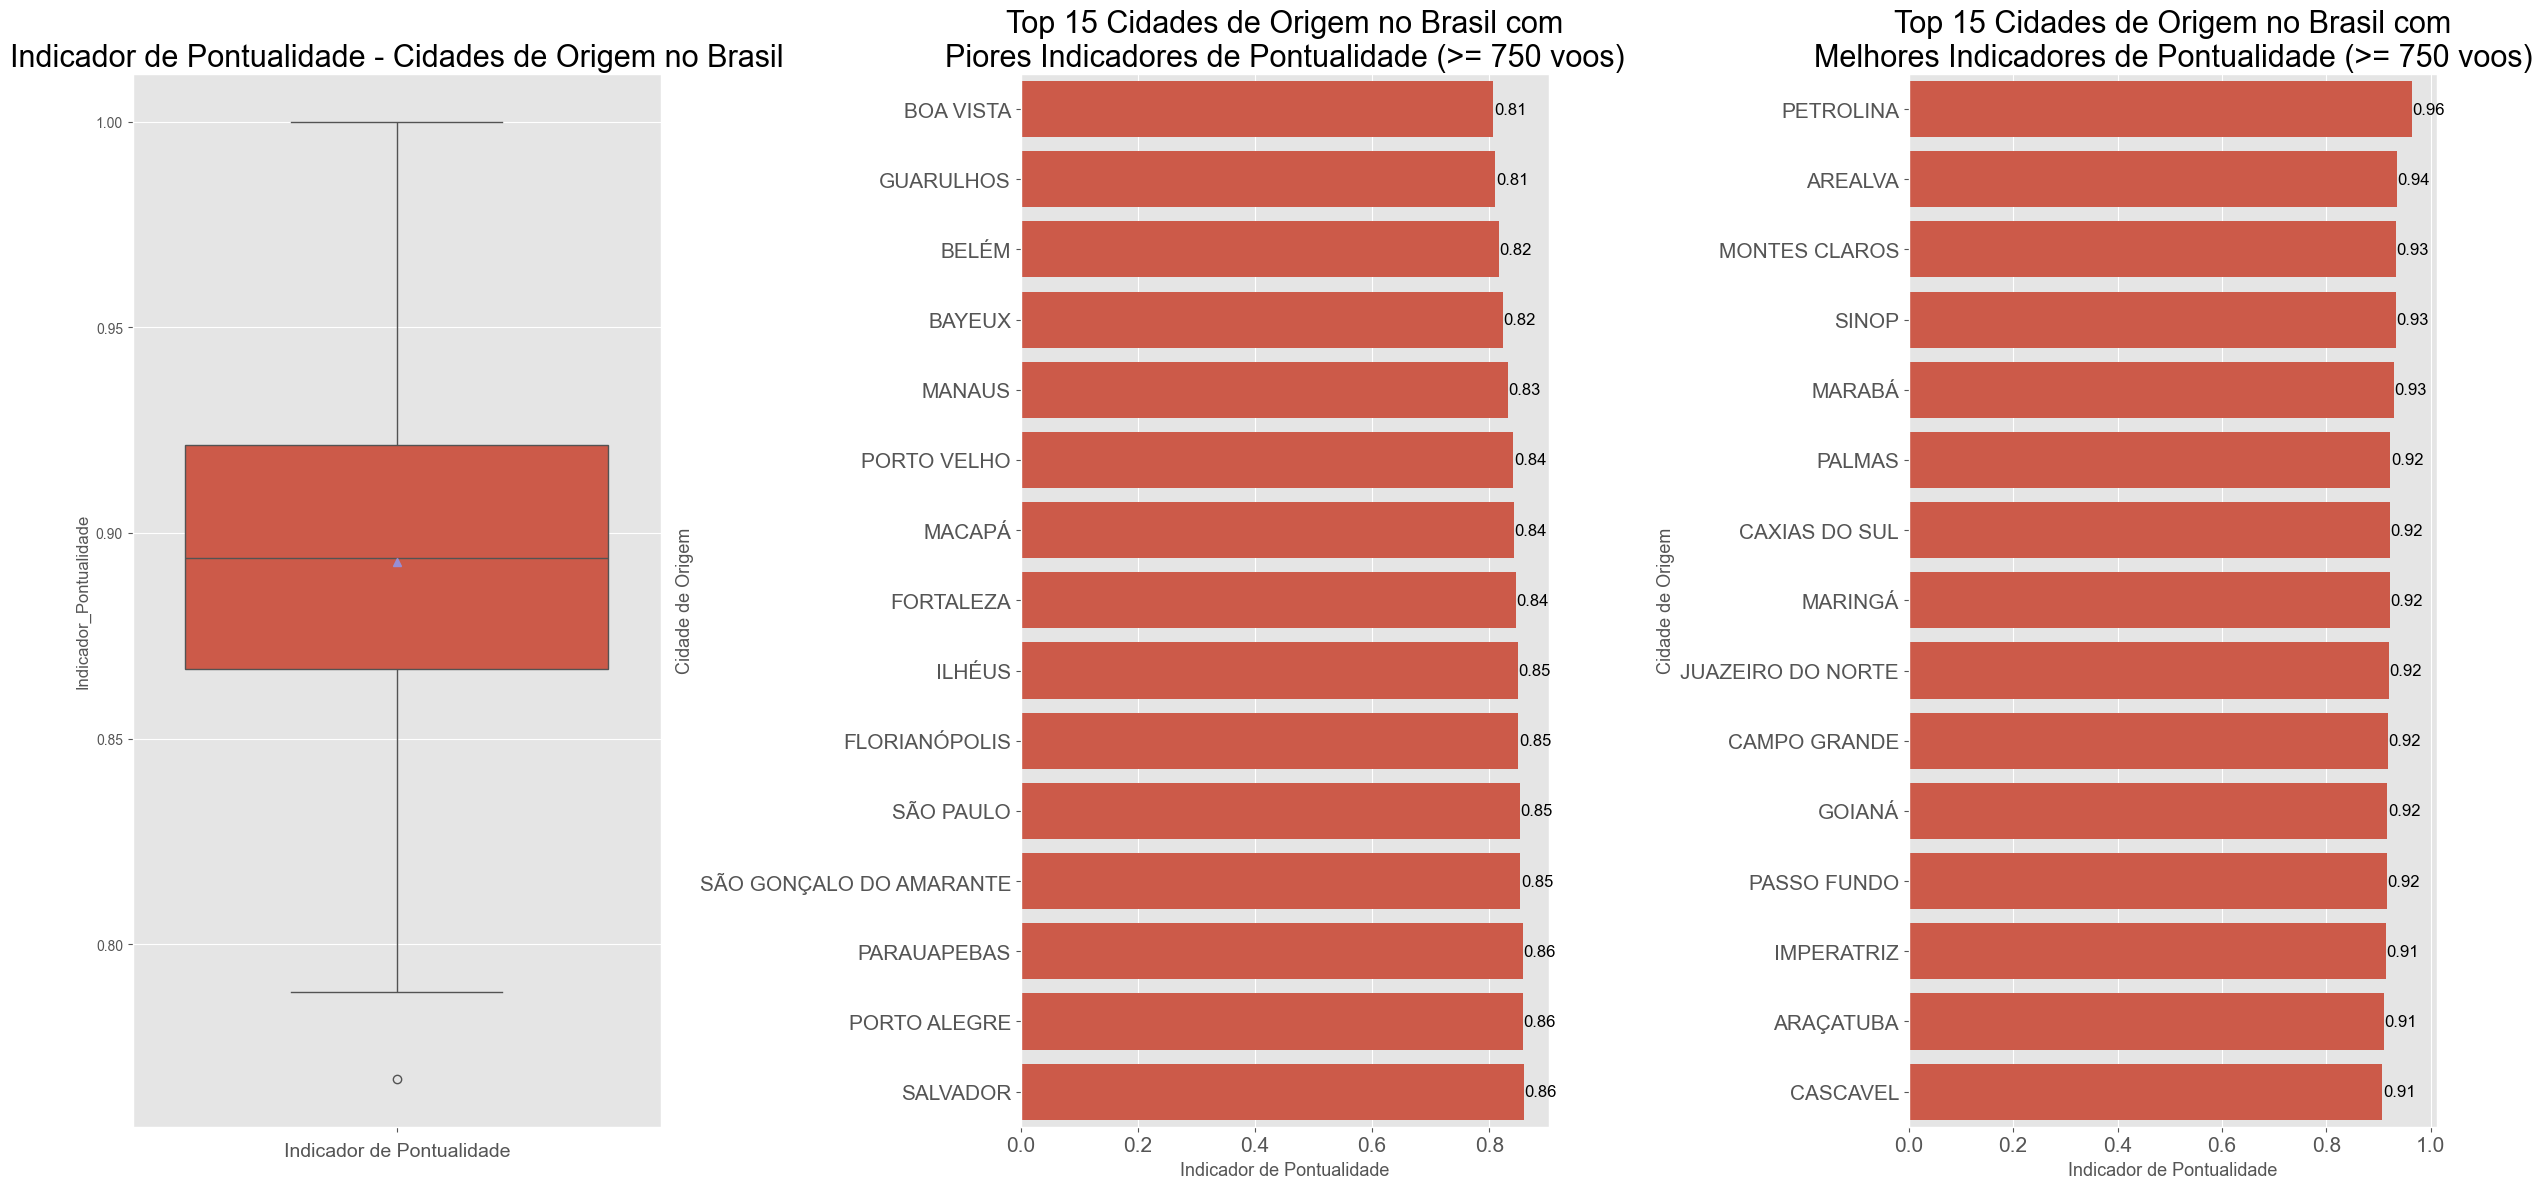

In [33]:
# Criação de Subplots para Análise do Indicador de Pontualidade por Cidades de Origem no Brasil.

# Configurando um ambiente de plotagem com três subgráficos.
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

# Boxplot para o indicador de pontualidade de todas as cidades de origem no Brasil.
# Este gráfico mostra a distribuição do indicador de pontualidade com a média incluída.
sns.boxplot(y='Indicador_Pontualidade', data=df_cidade_brasil, ax=axes[0], showmeans=True)
axes[0].set_title('Indicador de Pontualidade - Cidades de Origem no Brasil', fontsize=22)
axes[0].set_xlabel('Indicador de Pontualidade', fontsize=14)

# Gráfico de barras para as 10 cidades de origem no Brasil com os piores indicadores de pontualidade.
# Este gráfico mostra as cidades com os menores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='cidade_origem', data=df_cidade_brasil_10_nsmallest, ax=axes[1])
axes[1].set_title('Top 15 Cidades de Origem no Brasil com\nPiores Indicadores de Pontualidade (>= 750 voos)', fontsize=22)
axes[1].set_xlabel('Indicador de Pontualidade', fontsize=13)
axes[1].set_ylabel('Cidade de Origem', fontsize=13)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, fontsize=15)  # Configuração dos rótulos do eixo x
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=15)
# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico das piores cidades.
for i, p in enumerate(axes[1].patches):
    axes[1].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=12, color='black', xytext=(12, 0), textcoords='offset points')

# Gráfico de barras para as 10 cidades de origem no Brasil com os melhores indicadores de pontualidade.
# Este gráfico mostra as cidades com os maiores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='cidade_origem', data=df_cidade_brasil_10_10_nlargest, ax=axes[2])
axes[2].set_title('Top 15 Cidades de Origem no Brasil com\nMelhores Indicadores de Pontualidade (>= 750 voos)', fontsize=22)
axes[2].set_xlabel('Indicador de Pontualidade', fontsize=13)
axes[2].set_ylabel('Cidade de Origem', fontsize=13)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0, fontsize=15)  # Configuração dos rótulos do eixo x
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0, fontsize=15)
# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico das melhores cidades.
for i, p in enumerate(axes[2].patches):
    axes[2].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=12, color='black', xytext=(12, 0), textcoords='offset points')

# Ajustando o layout para evitar sobreposição de elementos e melhorar a visualização.
plt.tight_layout()

# Exibindo os gráficos.
plt.show()


### Aeroportos e indicador de pontualidade

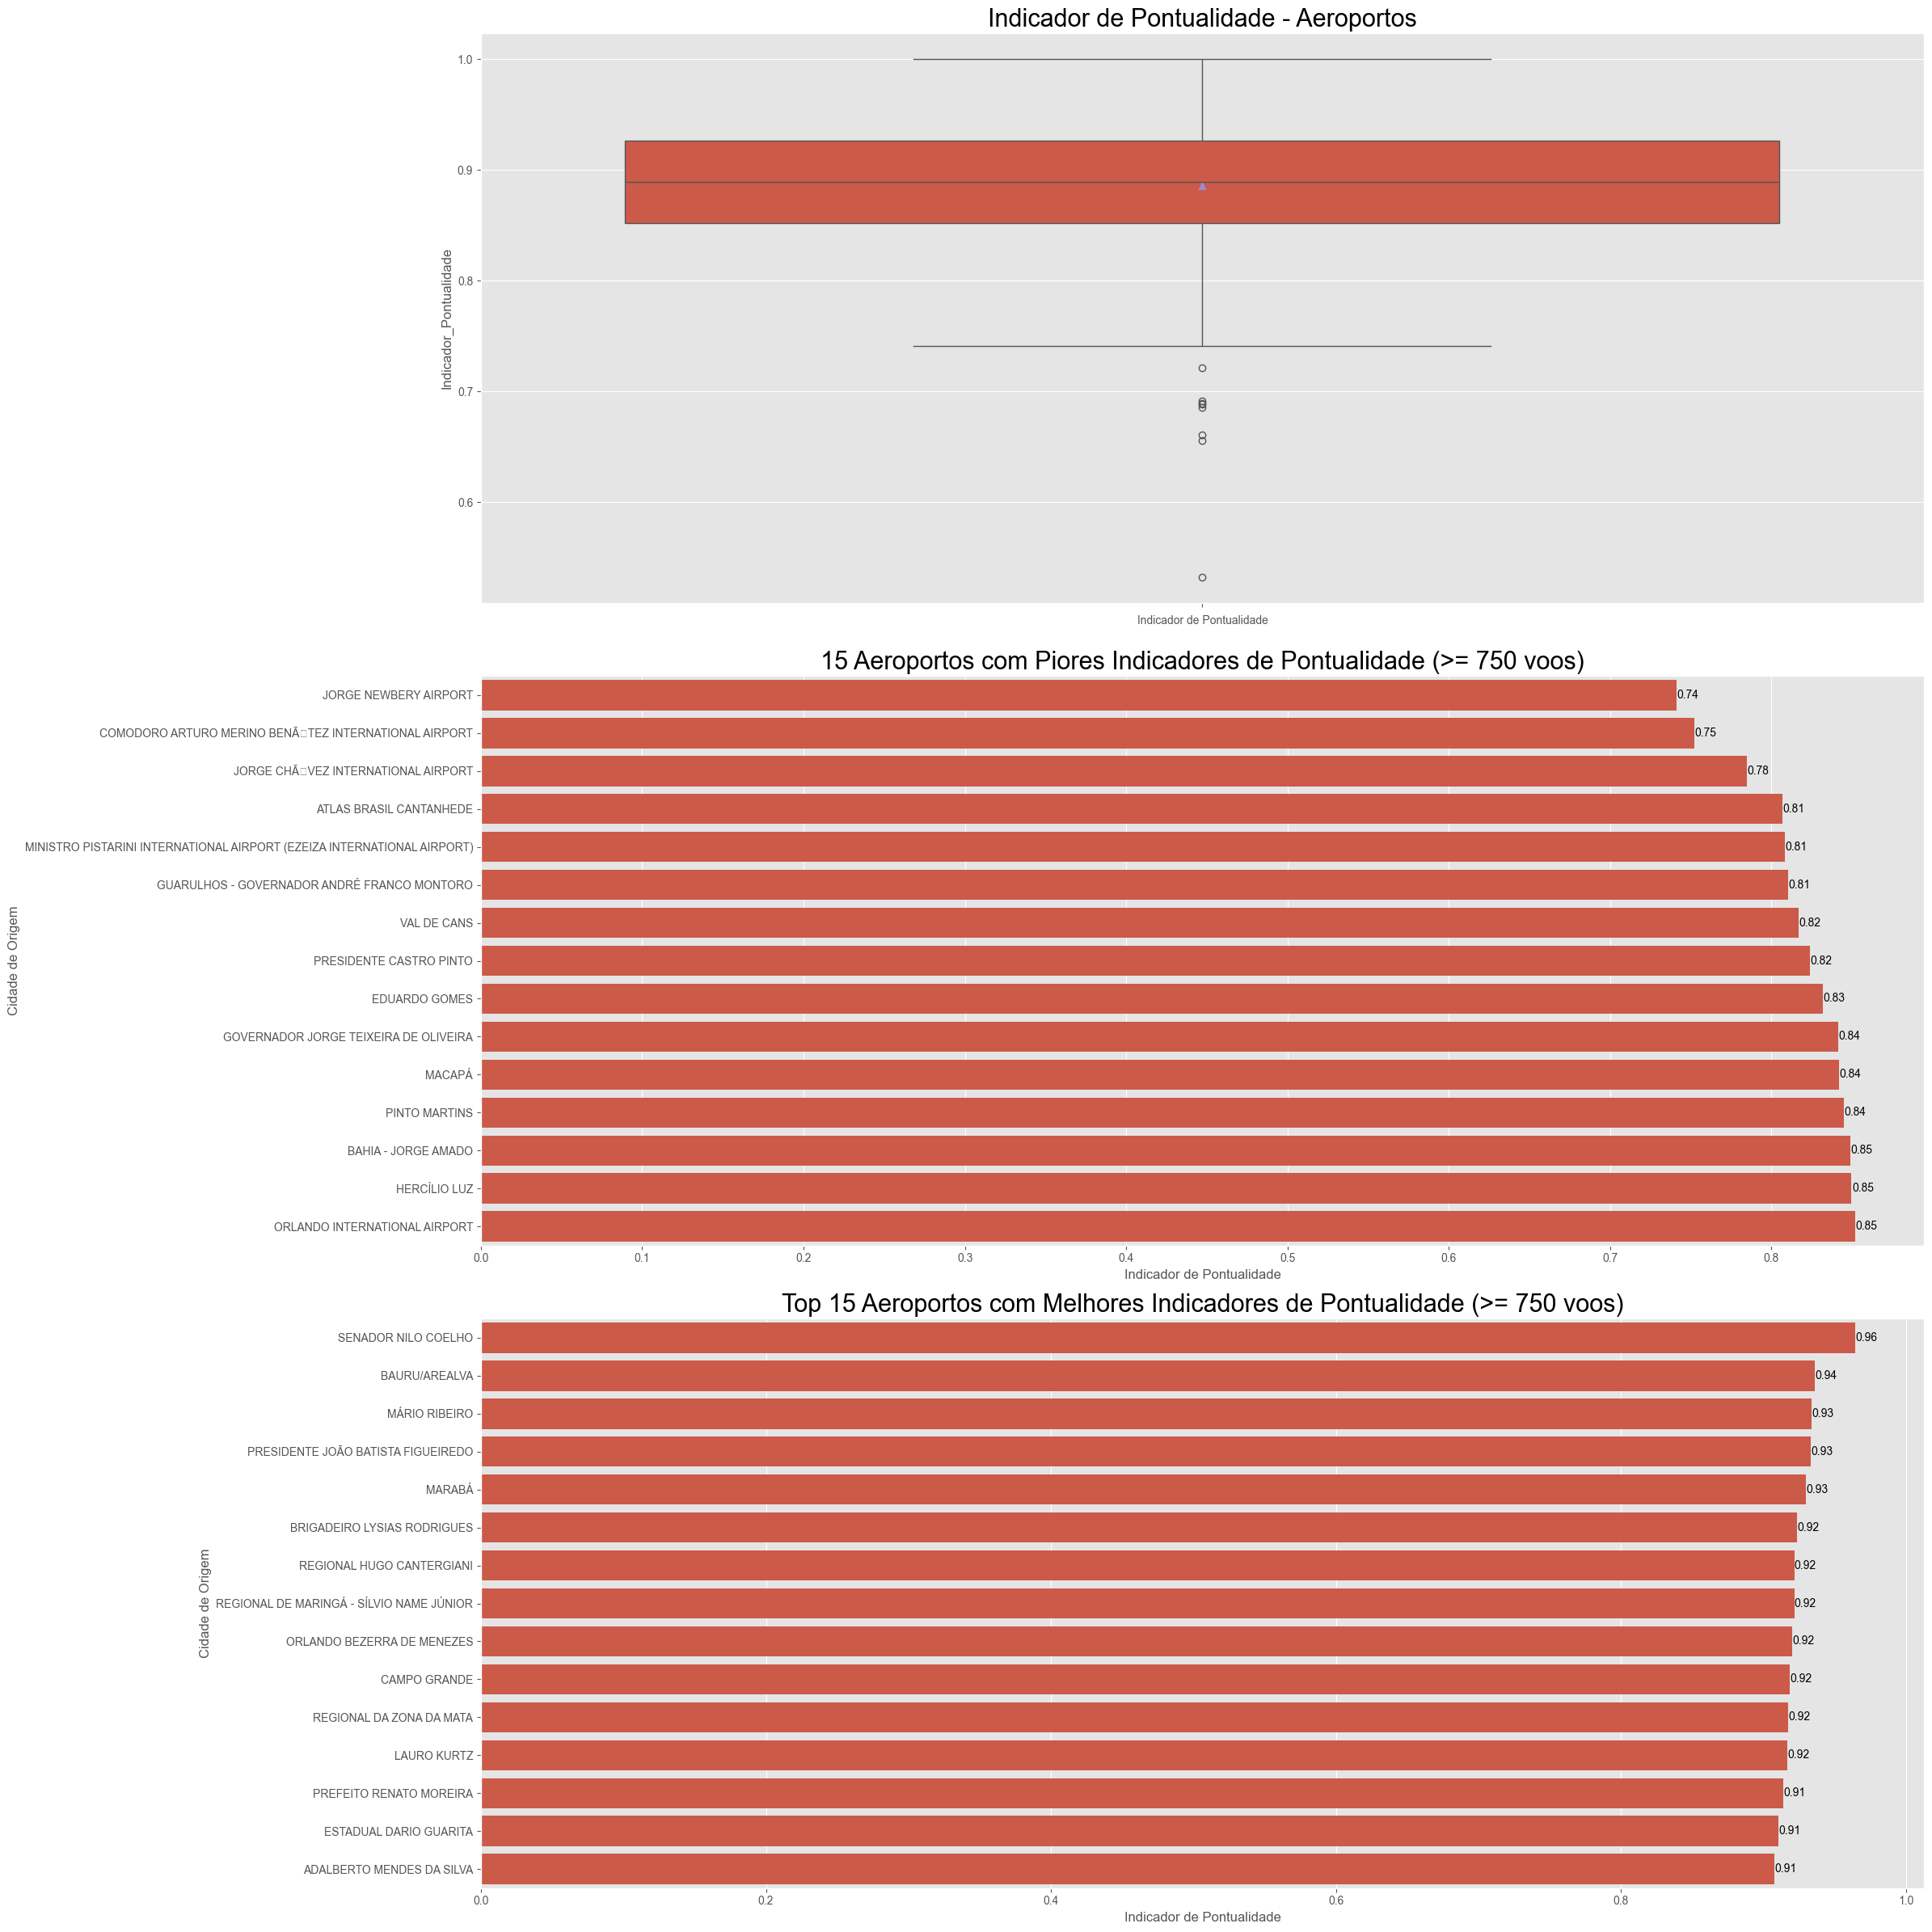

In [34]:
# Criação de Subplots para Análise do Indicador de Pontualidade em Aeroportos.

# Configurando um ambiente de plotagem com três subgráficos verticais.
fig, axes = plt.subplots(3, 1, figsize=(24, 24))

# Boxplot para o indicador de pontualidade de todos os aeroportos.
# Mostra a distribuição do indicador de pontualidade com a média incluída.
sns.boxplot(y='Indicador_Pontualidade', data=df_aeroporto_origem, ax=axes[0], showmeans=True)
axes[0].set_title('Indicador de Pontualidade - Aeroportos', fontsize=22)
axes[0].set_xlabel('Indicador de Pontualidade', fontsize=10)

# Gráfico de barras para os 10 aeroportos com os piores indicadores de pontualidade.
# Este gráfico destaca as localidades com os menores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='descricao_origem', data=df_aeroporto_origem_10_nsmallest, ax=axes[1])
axes[1].set_title('15 Aeroportos com Piores Indicadores de Pontualidade (>= 750 voos)', fontsize=22)
axes[1].set_xlabel('Indicador de Pontualidade', fontsize=12)
axes[1].set_ylabel('Cidade de Origem', fontsize=12)

# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico dos piores aeroportos.
for i, p in enumerate(axes[1].patches):
    axes[1].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(10, 0), textcoords='offset points')

# Gráfico de barras para os 10 aeroportos com os melhores indicadores de pontualidade.
# Este gráfico destaca as localidades com os maiores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='descricao_origem', data=df_aeroporto_origem_10_nlargest, ax=axes[2])
axes[2].set_title('Top 15 Aeroportos com Melhores Indicadores de Pontualidade (>= 750 voos)', fontsize=22)
axes[2].set_xlabel('Indicador de Pontualidade', fontsize=12)
axes[2].set_ylabel('Cidade de Origem', fontsize=12)

# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico dos melhores aeroportos.
for i, p in enumerate(axes[2].patches):
    axes[2].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(10, 0), textcoords='offset points')

# Ajustando o layout para melhorar a visualização e evitar sobreposição de elementos.
plt.tight_layout()

# Exibindo os gráficos.
plt.show()


### Aeroportos no brasil e indicador de pontualidade

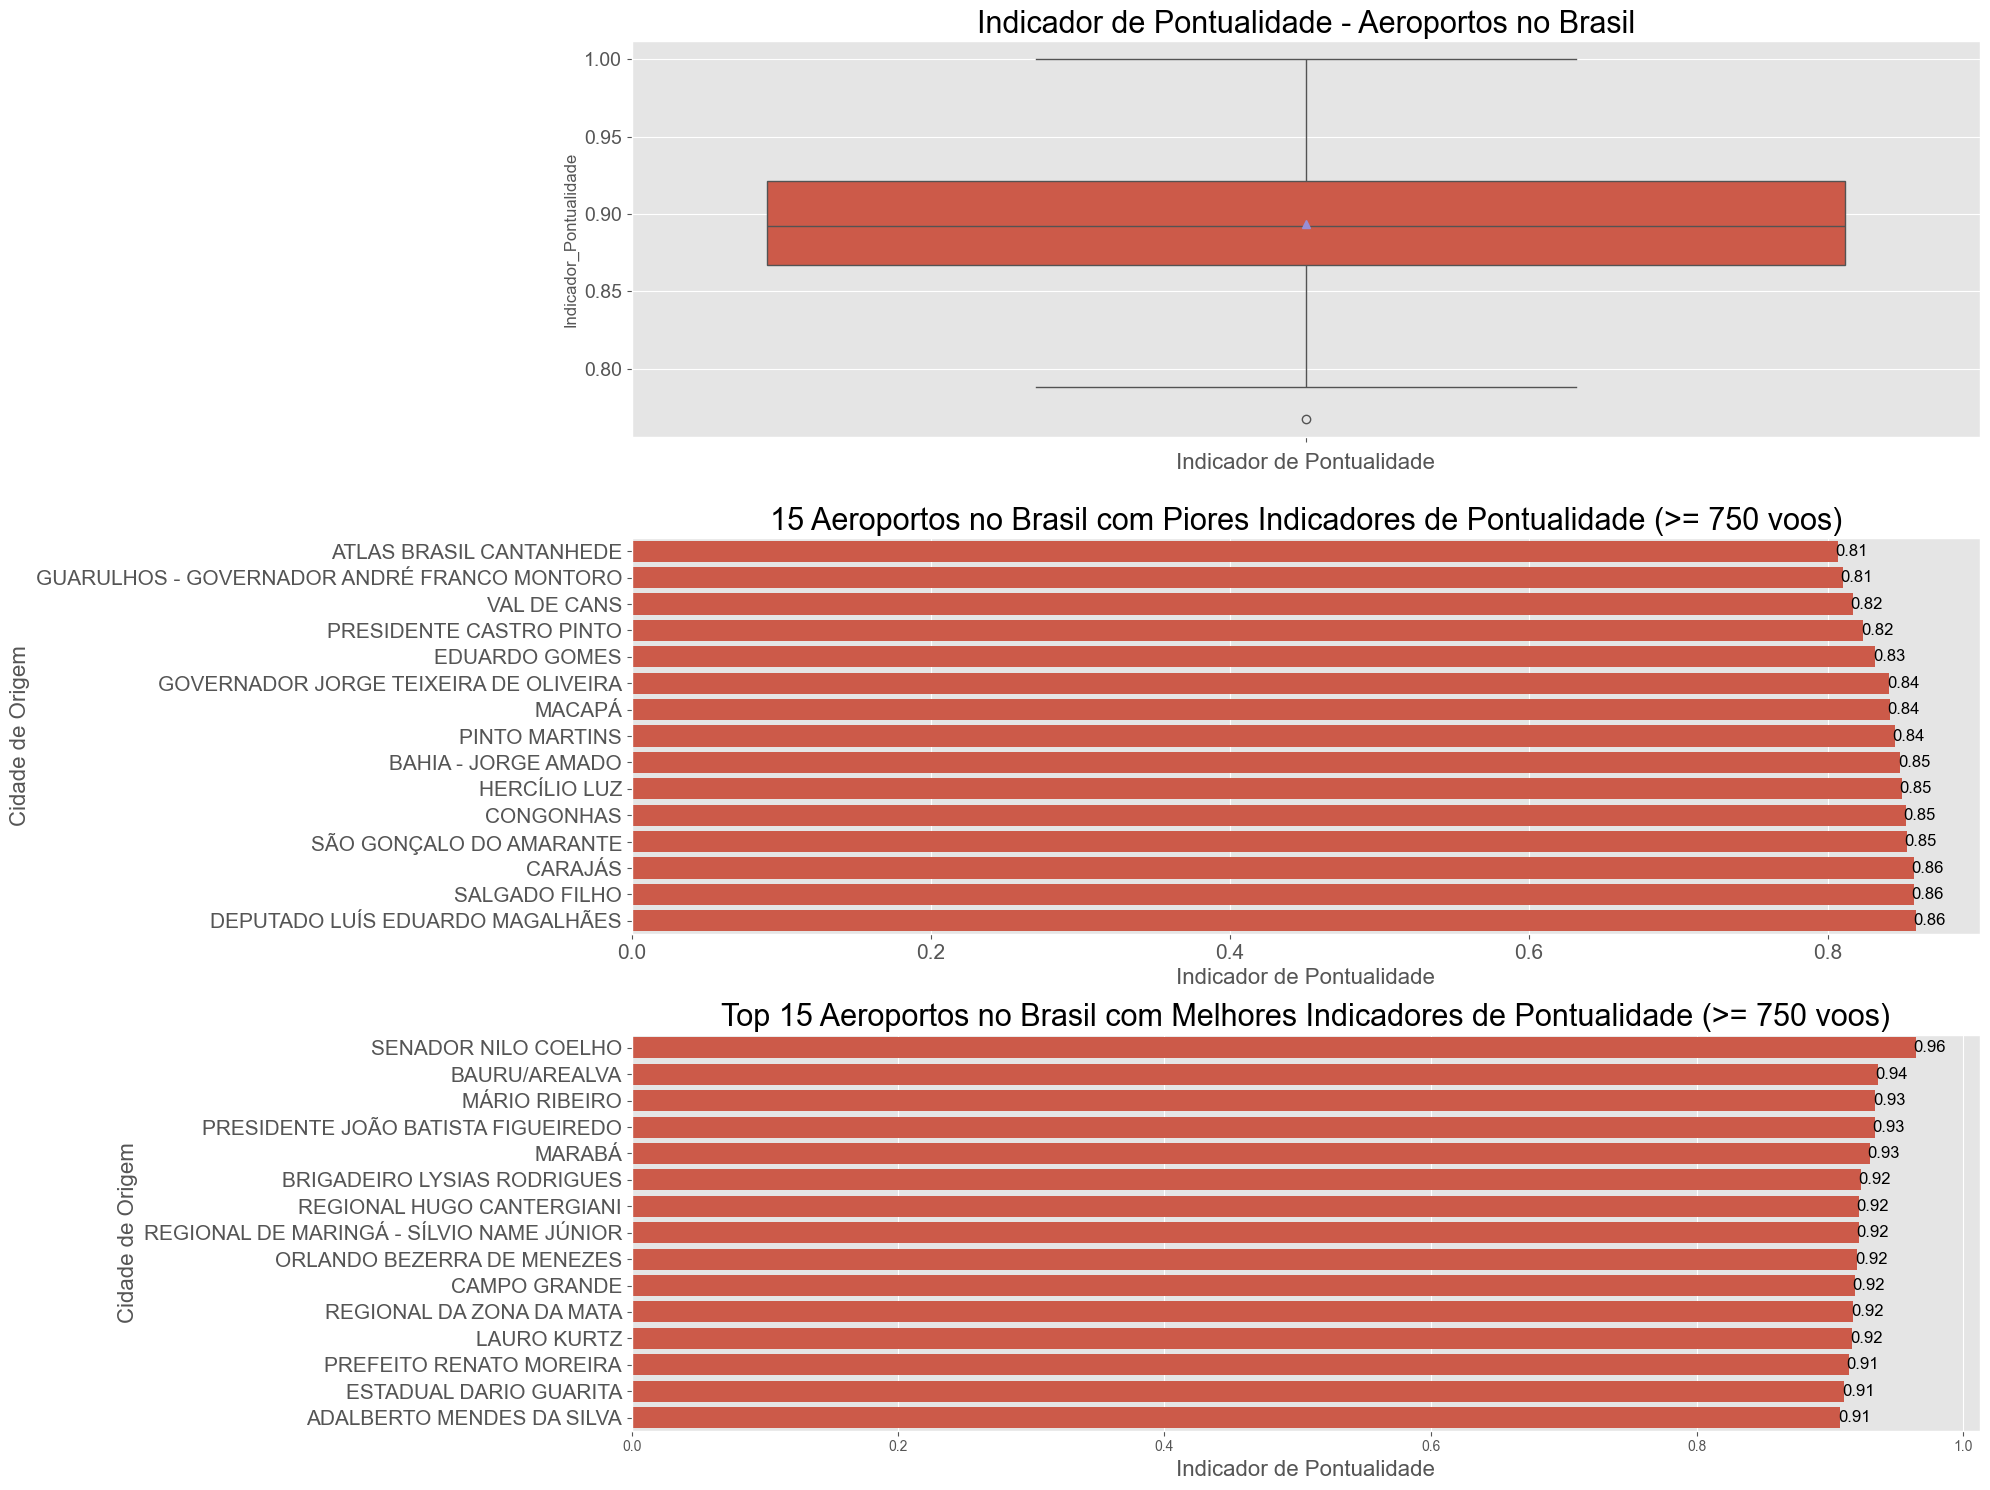

In [35]:
# Criação de Subplots para Análise do Indicador de Pontualidade em Aeroportos no Brasil.

# Configurando um ambiente de plotagem com três subgráficos verticais.
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

# Boxplot para o indicador de pontualidade de todos os aeroportos no Brasil.
# Este gráfico mostra a distribuição do indicador de pontualidade com a média incluída.
sns.boxplot(y='Indicador_Pontualidade', data=df_aeroporto_origem_brasil, ax=axes[0], showmeans=True)
axes[0].set_title('Indicador de Pontualidade - Aeroportos no Brasil', fontsize=22)
axes[0].set_xlabel('Indicador de Pontualidade', fontsize=16)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=14)  # Configuração dos rótulos do eixo y

# Gráfico de barras para os 10 aeroportos no Brasil com os piores indicadores de pontualidade.
# Este gráfico destaca as localidades com os menores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='descricao_origem', data=df_aeroporto_origem_brasil_10_nsmallest, ax=axes[1])
axes[1].set_title('15 Aeroportos no Brasil com Piores Indicadores de Pontualidade (>= 750 voos)', fontsize=22)
axes[1].set_xlabel('Indicador de Pontualidade', fontsize=16)
axes[1].set_ylabel('Cidade de Origem', fontsize=16)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, fontsize=15)  # Configuração dos rótulos do eixo x
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=15)
# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico dos piores aeroportos.
for i, p in enumerate(axes[1].patches):
    axes[1].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=12, color='black', xytext=(10, 0), textcoords='offset points')

# Gráfico de barras para os 10 aeroportos no Brasil com os melhores indicadores de pontualidade.
# Este gráfico destaca as localidades com os maiores valores de indicador de pontualidade.
sns.barplot(x='Indicador_Pontualidade', y='descricao_origem', data=df_aeroporto_origem_brasil_10_nlargest, ax=axes[2])
axes[2].set_title('Top 15 Aeroportos no Brasil com Melhores Indicadores de Pontualidade (>= 750 voos)', fontsize=22)
axes[2].set_xlabel('Indicador de Pontualidade', fontsize=16)
axes[2].set_ylabel('Cidade de Origem', fontsize=16)
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0, fontsize=15)  # Configuração dos rótulos do eixo y

# Adicionando anotações de valores exatos do indicador de pontualidade nas barras do gráfico dos melhores aeroportos.
for i, p in enumerate(axes[2].patches):
    axes[2].annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', fontsize=12, color='black', xytext=(10, 0), textcoords='offset points')

# Ajustando o layout para melhorar a visualização e evitar sobreposição de elementos.
plt.tight_layout()

# Exibindo os gráficos.
plt.show()


### Tempo e indicador de pontualidade

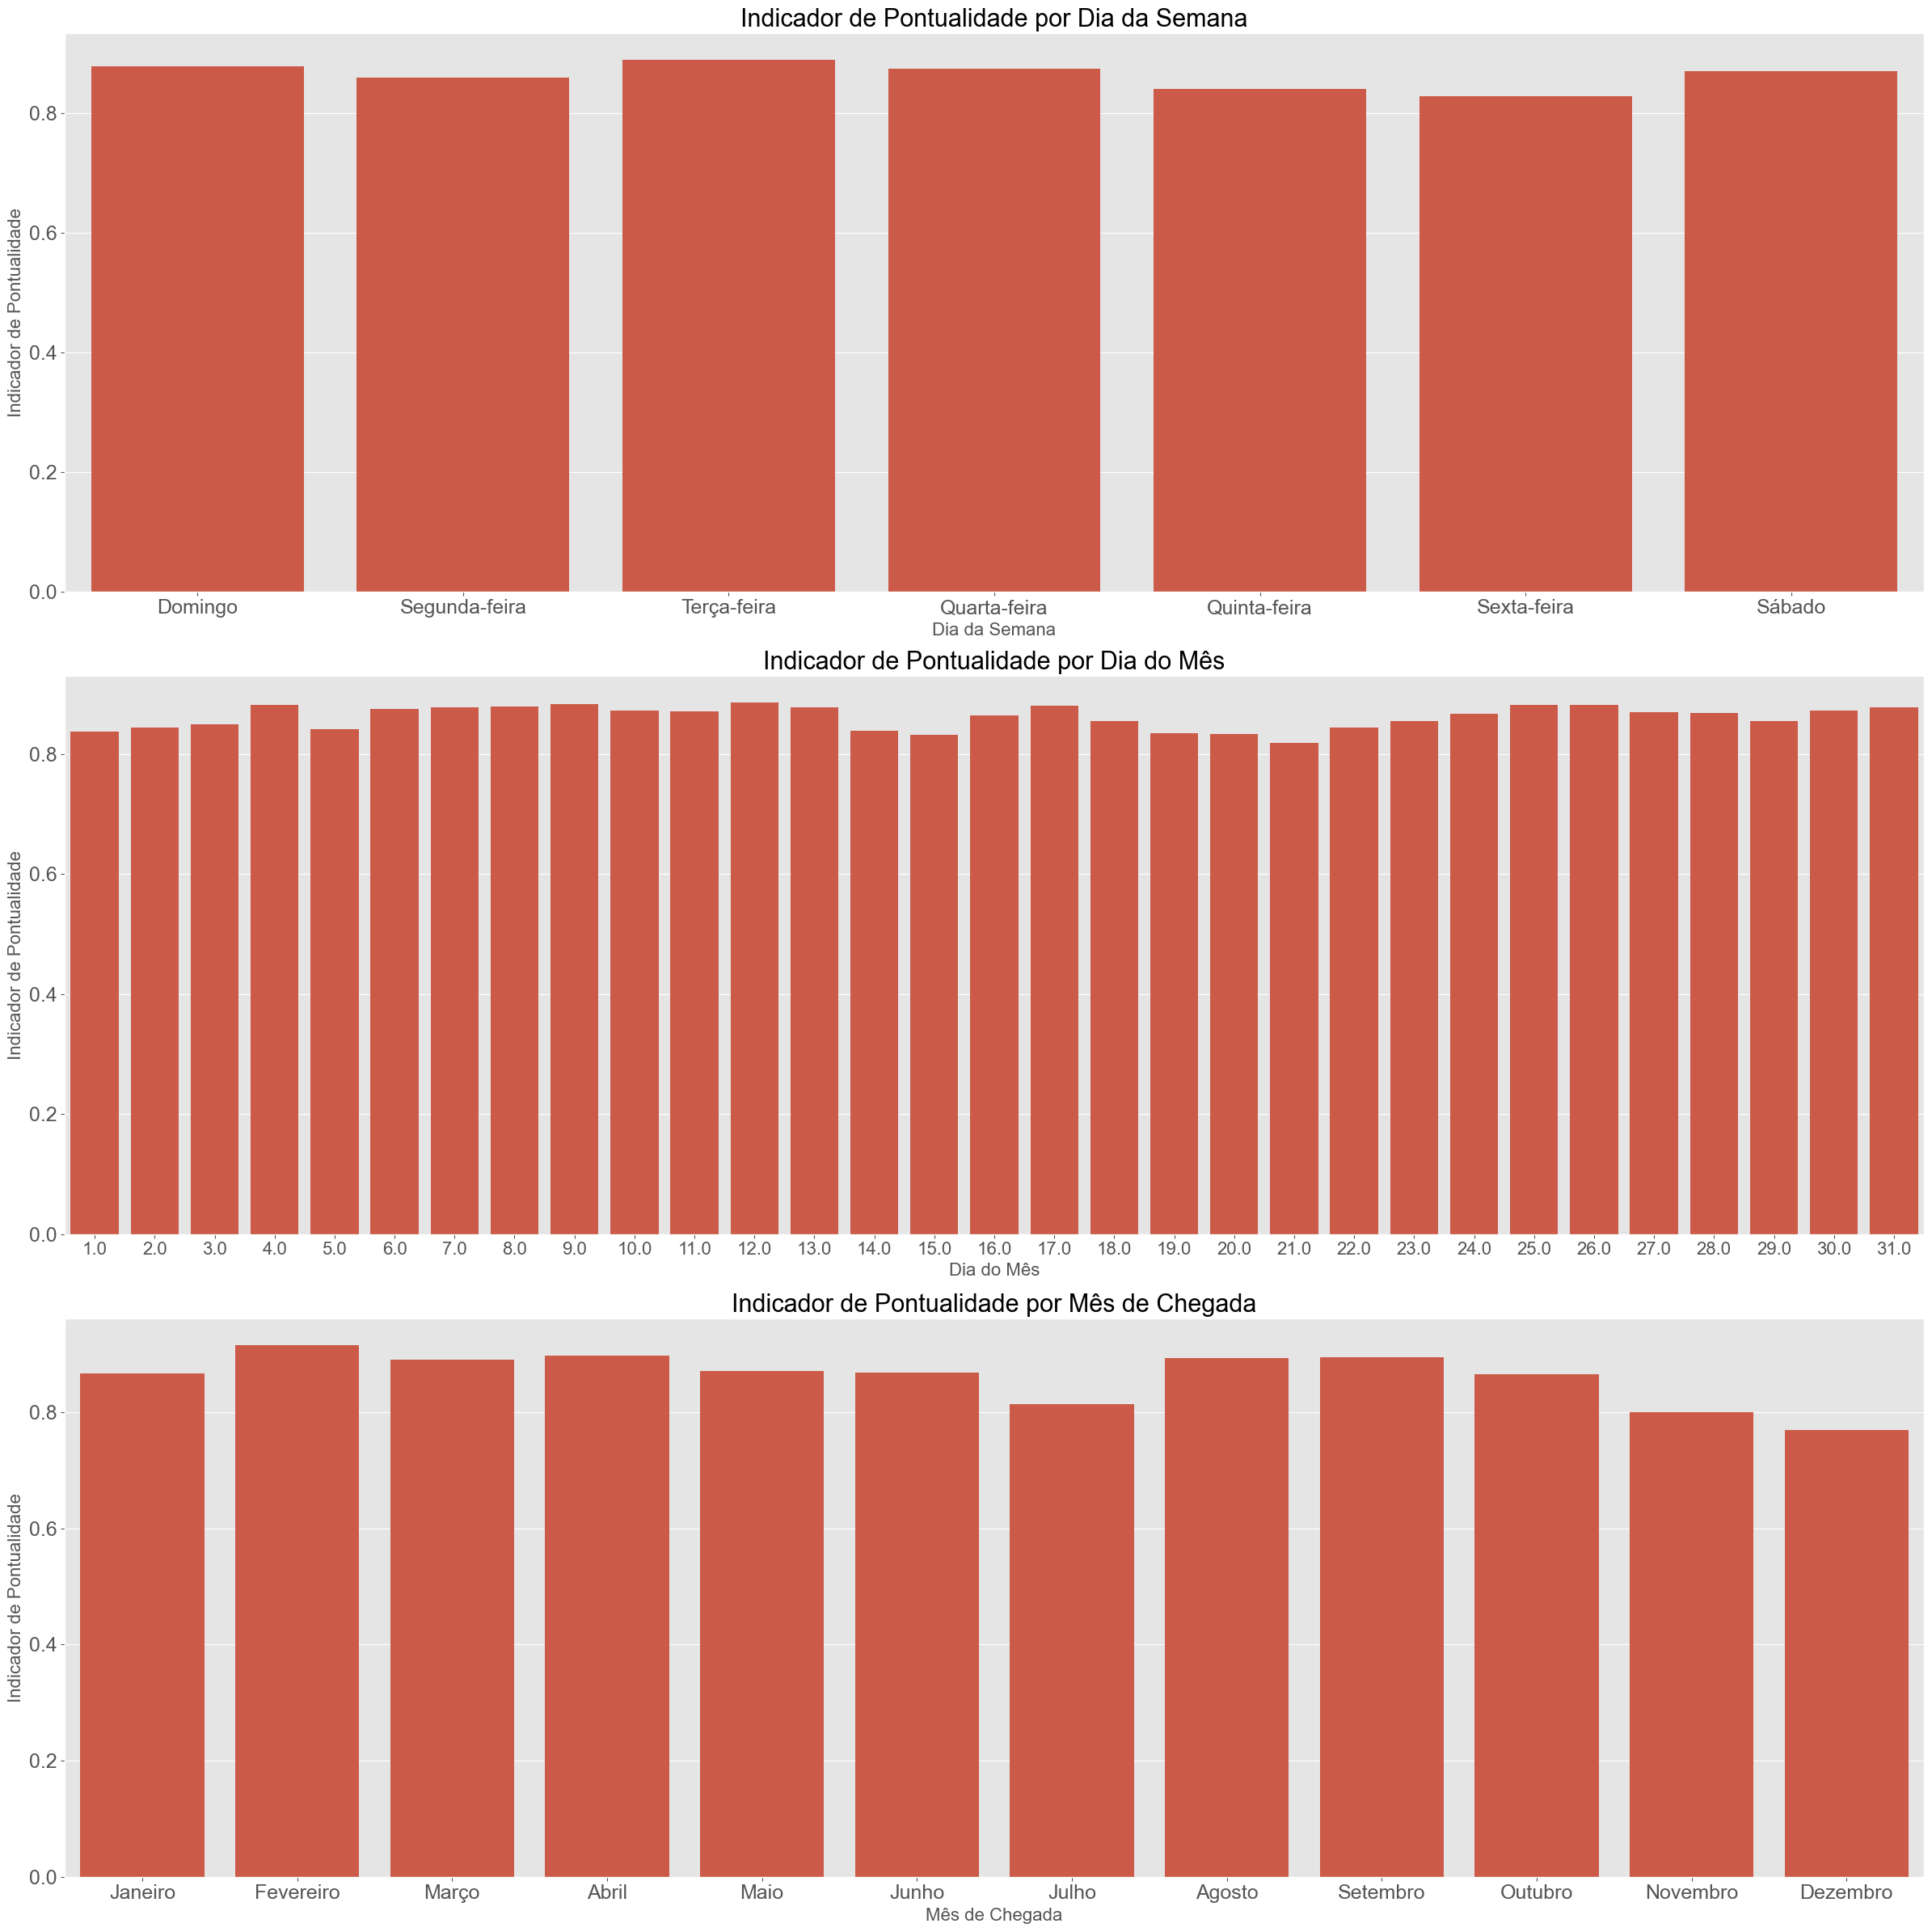

In [36]:
# Criação de Subplots para Análise do Indicador de Pontualidade em Relação a Variáveis Temporais.

# Configurando um ambiente de plotagem com três subgráficos verticais.
fig, axes = plt.subplots(3, 1, figsize=(24, 24))

# Primeiro Gráfico: Indicador de Pontualidade por Dia da Semana.
# Este gráfico mostra o indicador de pontualidade médio para cada dia da semana.
order_dias_semana = ["Domingo", "Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado"]
sns.barplot(ax=axes[0], x='dia_semana_chegada', y='Indicador_Pontualidade', data=df_dia_semana, order=order_dias_semana)
axes[0].set_title('Indicador de Pontualidade por Dia da Semana', fontsize=22)
axes[0].set_xlabel('Dia da Semana', fontsize=16)
axes[0].set_ylabel('Indicador de Pontualidade', fontsize=16)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, fontsize=18)  
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=18)  

# Segundo Gráfico: Indicador de Pontualidade por Dia do Mês.
# Este gráfico mostra o indicador de pontualidade médio para cada dia do mês.
df_dia_mes_sorted = df_dia_mes.sort_values(by='dia_mes_partida')
sns.barplot(ax=axes[1], x='dia_mes_partida', y='Indicador_Pontualidade', data=df_dia_mes_sorted)
axes[1].set_title('Indicador de Pontualidade por Dia do Mês', fontsize=22)
axes[1].set_xlabel('Dia do Mês', fontsize=16)
axes[1].set_ylabel('Indicador de Pontualidade', fontsize=16)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, fontsize=16)  
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=18)  

# Terceiro Gráfico: Indicador de Pontualidade por Mês de Chegada.
# Este gráfico mostra o indicador de pontualidade médio para cada mês do ano.
order_meses = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]
sns.barplot(ax=axes[2], x='mes_chegada', y='Indicador_Pontualidade', data=df_mes_chegada, order=order_meses)
axes[2].set_title('Indicador de Pontualidade por Mês de Chegada', fontsize=22)
axes[2].set_xlabel('Mês de Chegada', fontsize=16)
axes[2].set_ylabel('Indicador de Pontualidade', fontsize=16) 
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0, fontsize=18)  
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0, fontsize=18)  

# Ajustando o layout para melhorar a visualização e evitar sobreposição de elementos.
plt.tight_layout()

# Exibindo os gráficos.
plt.show()


### UF e indicador de pontualidade

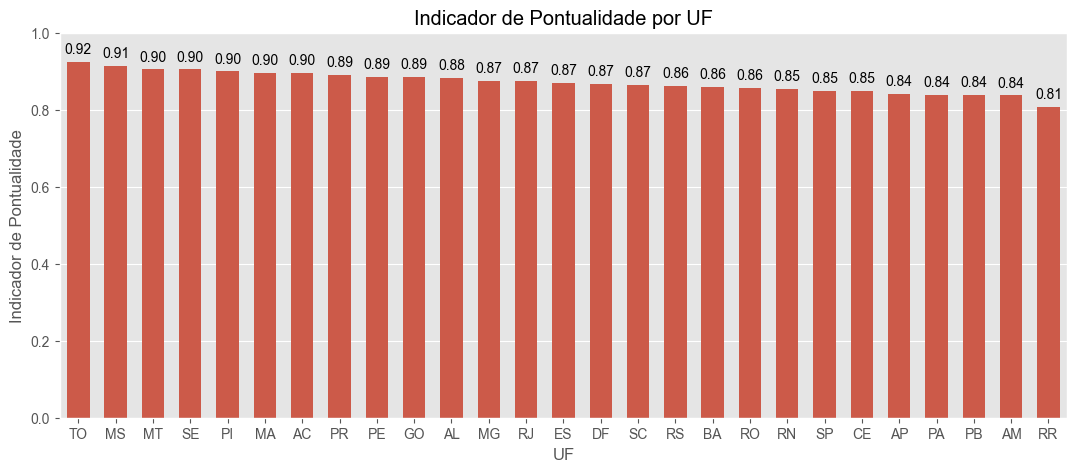

In [37]:
# Criação de um Gráfico de Barras para o Indicador de Pontualidade por UF.

# Configurando o tamanho da figura.
plt.figure(figsize=(13, 5))

# Criando um gráfico de barras para visualizar o indicador de pontualidade por UF.
# Os dados são ordenados em ordem decrescente de pontualidade.
ax = sns.barplot(x='uf_origem', y='Indicador_Pontualidade', data=df_uf.sort_values(by='Indicador_Pontualidade', ascending=False))

# Configuração do título e rótulos dos eixos do gráfico.
plt.title('Indicador de Pontualidade por UF')
plt.ylabel('Indicador de Pontualidade')
plt.xlabel('UF')
plt.ylim(0, 1)  # Limitando o eixo y para o intervalo [0, 1], já que o indicador varia neste intervalo.

# Adicionando anotações de valores exatos de pontualidade sobre cada barra do gráfico.
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

# Ajustando a largura das barras para melhor visualização.
change_width_x(ax, new_value=0.6)

# Exibindo o gráfico.
plt.show()


# Análise do Delta tempo de atraso

In [38]:
#showfliers = False

([0], [Text(0, 0, '')])

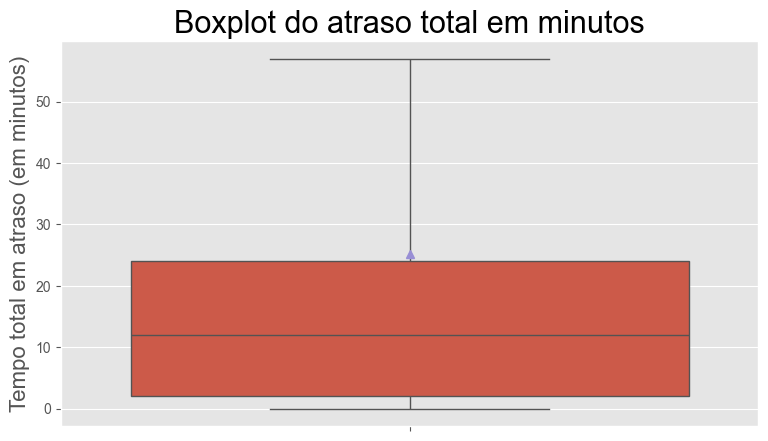

In [39]:
plt.figure(figsize=(9, 5))
sns.boxplot(y=df['delta_tempo_partida_int']+df['delta_tempo_chegada_int'], 
            data=df[(df['status_do_voo'] == 'Atrasado')&(df['delta_tempo_partida_int']+df['delta_tempo_chegada_int']<500)], 
            showmeans=True , showfliers = False)
plt.title('Boxplot do atraso total em minutos', fontsize=22)
plt.ylabel('Tempo total em atraso (em minutos)', fontsize=16)
plt.xlabel('', fontsize=16)
plt.xticks(rotation=0, fontsize=14)

### Delto tempo total em atraso por cia aerea

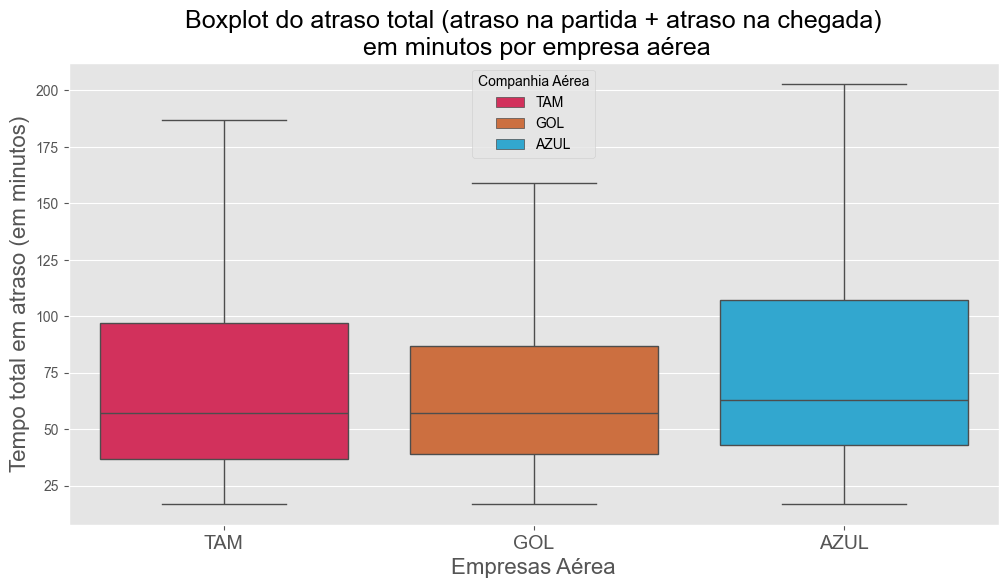

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(x= 'nome_empresas', y=df['delta_tempo_partida_int']+df['delta_tempo_chegada_int'], 
            data=df[(df['status_do_voo'] == 'Atrasado')&(df['delta_tempo_partida_int']+df['delta_tempo_chegada_int'])], 
            hue = 'nome_empresas',  showfliers = False,
            palette=cores_empresas)
plt.title('Boxplot do atraso total (atraso na partida + atraso na chegada)\n em minutos por empresa aérea', fontsize=18)
plt.ylabel('Tempo total em atraso (em minutos)', fontsize=16)
plt.xlabel('Empresas Aérea', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.legend(title='Companhia Aérea')#showmeans=True ,

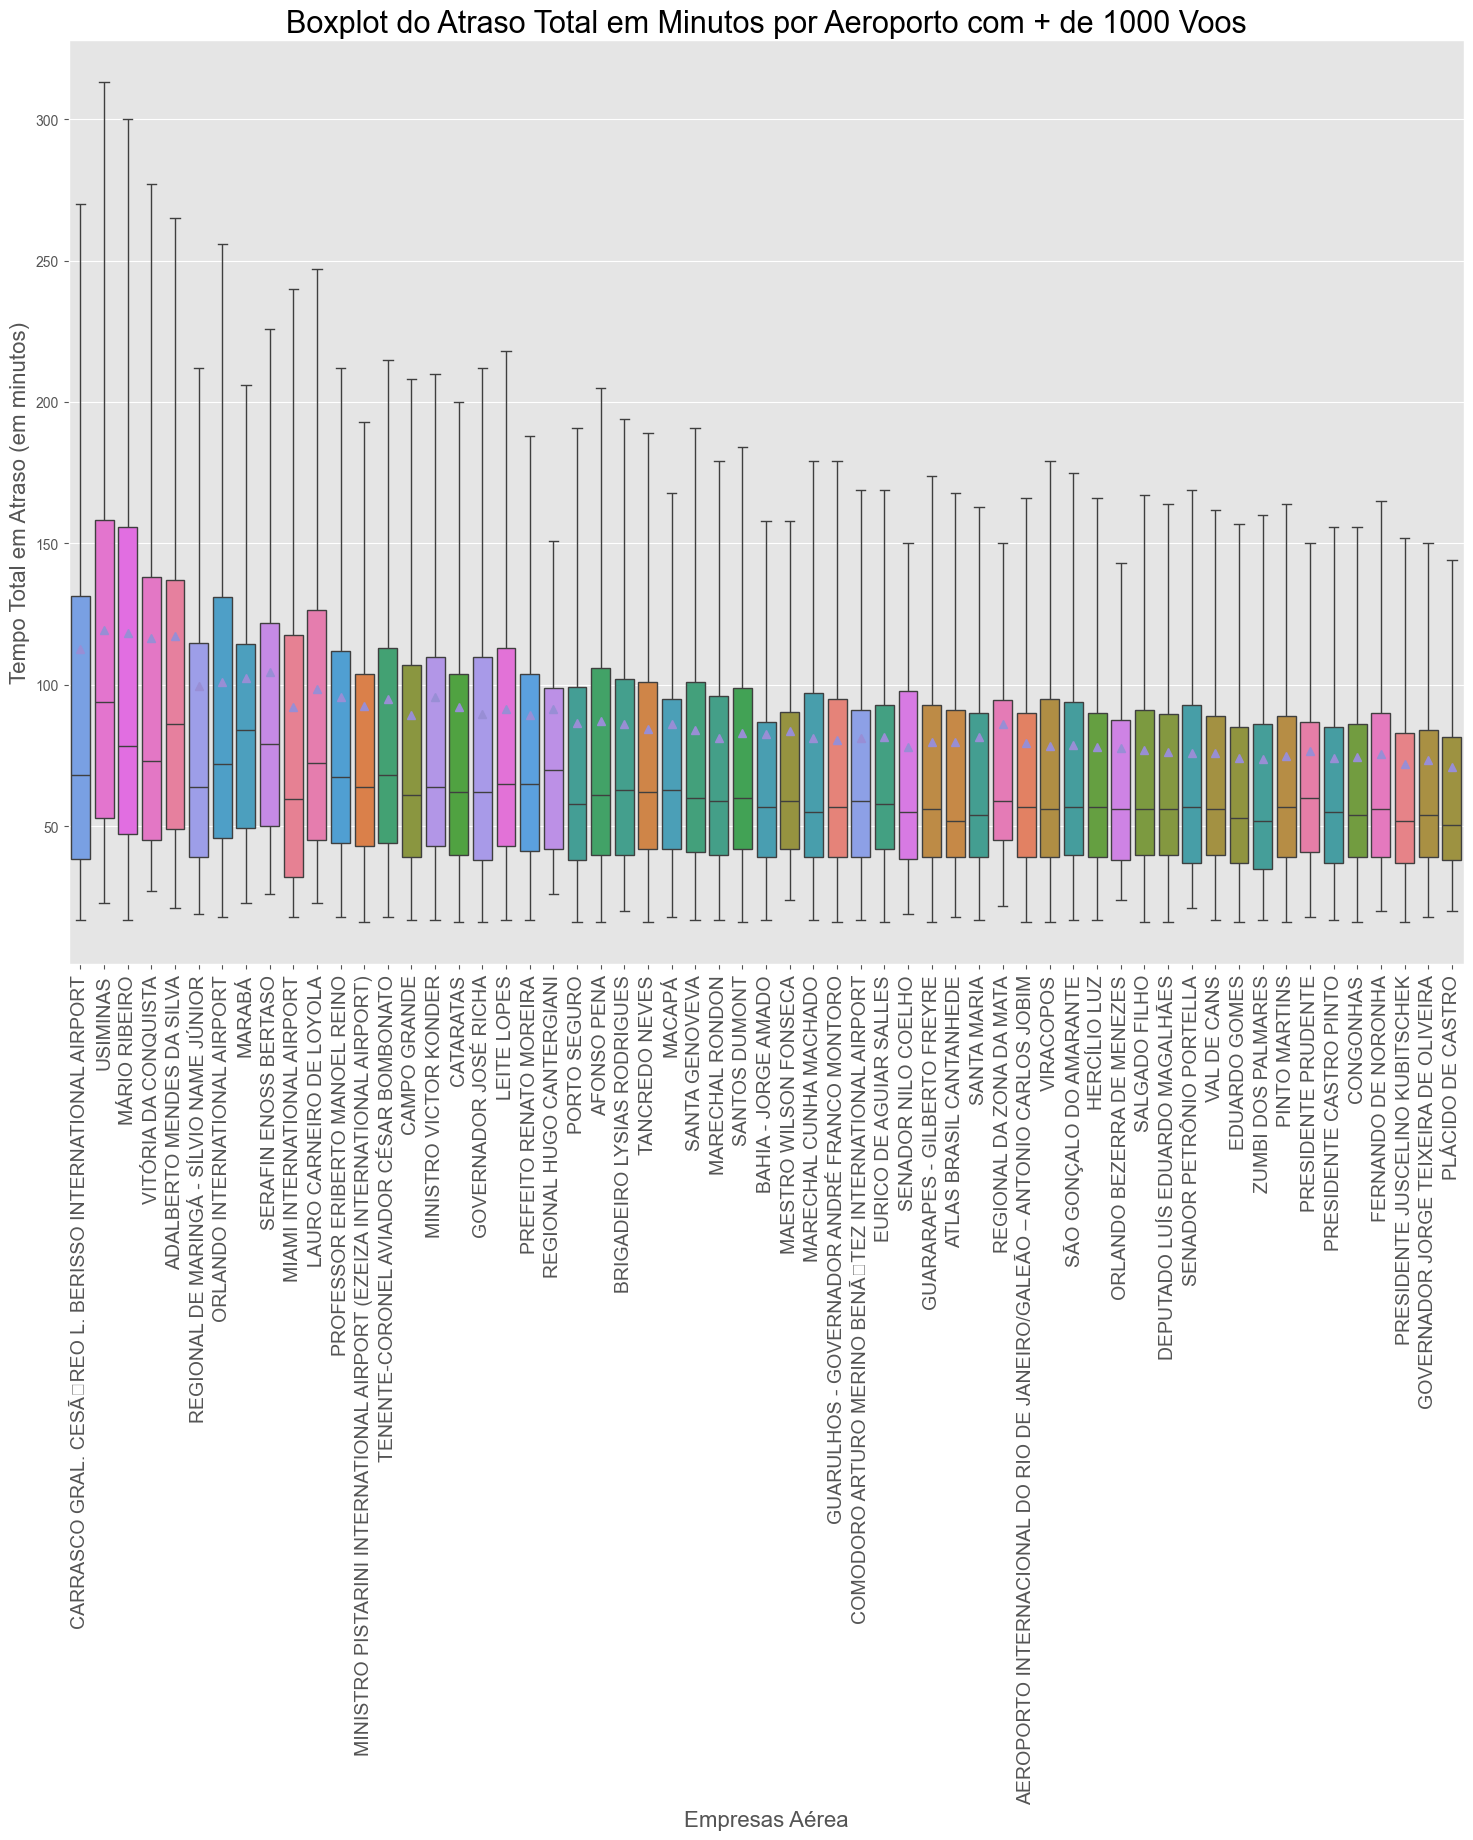

<Figure size 1000x600 with 0 Axes>

In [55]:
### Delto tempo total em atraso por aeroporto

# Análise Estatística do Atraso Total de Voos em Aeroportos com Mais de 1000 Voos.
plt.figure(figsize=(18, 12))
# Agrupamento dos voos por descrição de origem e status, contando os voos atrasados e pontuais.
grupo = df.groupby('descricao_origem')['status_do_voo'].value_counts().unstack(fill_value=0)

# Filtrando para considerar apenas aeroportos com mais de 1000 voos.
filtro = grupo[(grupo['Atrasado'] + grupo['Pontual'] >= 1000)].index

# Filtrando o DataFrame original para incluir apenas voos atrasados dos aeroportos selecionados,
# com a soma dos atrasos na partida e chegada inferiores a 500 minutos.
df_filtrado = df[
    (df['descricao_origem'].isin(filtro)) &
    (df['status_do_voo'] == 'Atrasado') &
    (df['delta_tempo_partida_int'] + df['delta_tempo_chegada_int'] < 500)
]

# Calculando a média do tempo de atraso na partida para cada aeroporto.
mean = df_filtrado.groupby('descricao_origem')['delta_tempo_partida_int'].mean()

# Ordenando as categorias com base na média de atraso.
ordered_categories = mean.sort_values(ascending=False).index

# Criando um boxplot para mostrar a distribuição do atraso total em minutos por aeroporto.
sns.boxplot(
    x='descricao_origem', 
    y=df_filtrado['delta_tempo_partida_int'] + df_filtrado['delta_tempo_chegada_int'], 
    data=df_filtrado, 
    hue='descricao_origem', 
    showmeans=True, 
    order=ordered_categories,
    showfliers=False)
plt.title('Boxplot do Atraso Total em Minutos por Aeroporto com + de 1000 Voos', fontsize=22)
plt.ylabel('Tempo Total em Atraso (em minutos)', fontsize=16)
plt.xlabel('Empresas Aérea', fontsize=16)
plt.xticks(rotation=90, fontsize=14)

# Exibindo o gráfico.
plt.show()
plt.tight_layout()